# Load Package

In [1]:
#待續
# 紅白酒資料>Ｙ分成01>split>score（recall, precision, AUC）
# 親代個數先設定權重數目的2倍
# 若無改善，試試看multi phase ES 迭代結果子代的10%再從頭開始
#

In [2]:
#https://github.com/YuTaNCCU/201902_ANN_Metaheuristic/tree/master/ES
import random
import pandas as pd
from string import ascii_lowercase
from copy import deepcopy
from abc import ABCMeta, abstractmethod
from copy import deepcopy
from collections import deque
from numpy import argmax
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential 
from keras.callbacks import TensorBoard,EarlyStopping
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
import  seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Load Data

In [3]:
url = 'https://raw.githubusercontent.com/YuTaNCCU/201902_ANN_Metaheuristic/master/Data/red.csv'
red = pd.read_csv(url)

url = 'https://raw.githubusercontent.com/YuTaNCCU/201902_ANN_Metaheuristic/master/Data/white.csv'
white = pd.read_csv(url)

red['WineCatg']='red'
white['WineCatg']='white'
Wine_Data = pd.concat([red, white])

display(
    red.shape,
  white.shape,
  Wine_Data.shape,
  Wine_Data.head(5),
  Wine_Data.tail(5)
)

(1599, 13)

(4898, 13)

(6497, 13)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality WineCatg  
0      9.4        5      red  
1      9.8        5      red  
2      9.8        5      red  
3      9.8        6      red  
4      9.4        5      red

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
4893                 24.0                  92.0  0.99114  3.27       0.50   
4894                 57.0                 168.0  0.99490  3.15       0.46   
4895                 30.0                 111.0  0.99254  2.99       0.46   
4896                 20.0                 110.0  0.98869  3.34       0.38   
4897                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality WineCatg  
4893     11.2        6    white  
4894      9.6        5    white  
4895      9.4        6    white  
4896     12.8        7    white  
4897     11.8        6    white

In [4]:
print( '原本各種quality記數: \n', Wine_Data.quality.value_counts().sort_index() )
Wine_Data_Y01 = Wine_Data.replace({'quality':[3,4,5,6,7,8,9]},{'quality':[0,0,0,1,1,1,1]})
print( '分類成好壞兩種quality記數: \n', Wine_Data_Y01.quality.value_counts().sort_index() )
Wine_Data_Y01.head(5)

原本各種quality記數: 
 3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: quality, dtype: int64
分類成好壞兩種quality記數: 
 0    2384
1    4113
Name: quality, dtype: int64


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality WineCatg  
0      9.4        0      red  
1      9.8        0      red  
2      9.8        0      red  
3      9.8        1      red  
4      9.4        0      red

In [5]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X=Wine_Data_Y01.drop(['quality', 'WineCatg'], axis=1)
y=Wine_Data_Y01['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state= 123)

display(
      X_train.shape,
      X_val.shape,
      X_test.shape,
      y_train.shape,
      y_val.shape,
      y_test.shape,
)

(4157, 11)

(1040, 11)

(1300, 11)

(4157,)

(1040,)

(1300,)

# Define Performance

In [6]:
def Performance(model):
    #######################
    ## Confusion Matrix  ##
    #######################

    # Predicting the Test set results
    y_score = model.predict(X_test) #X_train X_test
    y_pred = (y_score > 0.5)  #y_pred 有 NA

    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred) #y_train y_test
    #######################
    ###    accuracy      ##
    #######################
    print("Our accuracy is {}%".format(round(((cm[0][0] + cm[1][1])/sum(sum(cm)))*100,2)))

    sns.heatmap(cm,annot=True)
    #######################
    ###       AUC        ##
    #######################    
    from sklearn.metrics import roc_auc_score
    print("Our AUC is {}%".format(round((roc_auc_score(y_test, y_score)*100),2)))
    
    #######################
    ###    ROC curve     ##
    #######################
    import numpy as np
    import matplotlib.pyplot as plt
    from itertools import cycle

    from sklearn import svm, datasets
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import label_binarize
    from sklearn.multiclass import OneVsRestClassifier
    from scipy import interp
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes =2
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    #Plot of a ROC curve for a specific class
    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show() 

# Define Keras Model

In [7]:
def SummarizeHistory(modelcallbacks, prfix='', UseValid=False) :
    
    plt.figure()
    plt.plot(modelcallbacks.history[prfix+'loss'])  #loss mean_absolute_error 
    if UseValid==True:
        plt.plot(modelcallbacks.history['val_'+prfix+'loss'])  #val_loss 
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')
    plt.show()

    plt.figure()
    plt.plot(modelcallbacks.history[prfix+'acc'])  #loss mean_absolute_error 
    if UseValid==True:
        plt.plot(modelcallbacks.history['val_'+prfix+'acc'])  # val_mean_absolute_error
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()
    
def ModelCompile():
    from keras import backend as K
    from keras.layers import Dense
    from keras.models import Sequential, Model as keras_models_Model

    K.clear_session() 
    gpu_options = tf.GPUOptions(allow_growth=True)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    tf.keras.backend.set_session(sess)

    model = Sequential()
    model.add(Dense(round(X_train.shape[1]/2), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(round(X_train.shape[1]/2), activation='relu'))
    model.add(Dense(round(X_train.shape[1]/4), activation='relu', name = 'IntermediateLayer'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def ModelFit(model, weights):
    #class_weight = {0: 1., 1: 1525/2632}
    model.set_weights(weights)
    modelcallbacks = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1,
        validation_data = (X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=2, restore_best_weights=True)],
        shuffle=True) #, class_weight=class_weight
    SummarizeHistory(modelcallbacks, UseValid=True)                                        
    weights = model.get_weights() 
    return model, weights

# Define ES Class

In [8]:
class ES:
    """
    Conducts tabu search
    """
    __metaclass__ = ABCMeta

    #default hyper parameters
    InitialSigma = None
    ParentsSize = None
    ChildSize = None
    tao = None
    
    #for input/output
    KerasModels = None
    WeightsStrucure = None   
    weights = None
    
    #for record
    cur_steps = 1
    best_weight = None
    best_score = None
    
    UseOLSReg=None
    X_train=None
    y_train=None
    
    def __init__(self, KerasModels, X_train, y_train, UseOLSReg=False, InitialSigma = 0.1, ParentsSize = 15, ChildSize = 100, tao = 0.5):
        """
        :param KerasModels: a Keras model, like keras.engine.sequential.Sequential
        :param weights: initial weights, should be a Keras model weight
        :param max_steps: maximum number of steps to run algorithm for
        :param UseOLSReg: If True, than use "OLS Regression" for the last layer
        
        """
        self.KerasModels = KerasModels
        
        self.UseOLSReg = UseOLSReg
        
        self.X_train=X_train
        self.y_train=y_train
 
        if all(isinstance(x, float) for x in [InitialSigma, tao]) and all(x > 0 for x in [InitialSigma, tao]):
            self.InitialSigma = InitialSigma
            self.tao = tao
        else:
            raise TypeError('InitialSigma & tao must be a positive float')
            
        if all(isinstance(x, int) for x in [ParentsSize, ChildSize]) and all(x > 0 for x in [ParentsSize, ChildSize]):
            self.ParentsSize = ParentsSize
            self.ChildSize = ChildSize
        else:
            raise TypeError('ParentsSize, ChildSize & max_steps must be a positive integer')

    def __str__(self): 
        return ('ES STEPS: %d ' +
                'BEST SCORE: %.4f ') % \
               (self.cur_steps, self.best_score)

    def __repr__(self):
        return self.__str__() 
    
    def _FlattenWeights(self, weights):
        """
        flatten weights
        
        param weights: keras神經網路的權重格式:nparray包在list中
        return WeightsStrucure : 神經網路各層的權重shape包在list中，unflatten時會用到
        return FlattenedWeights : 一維list包含所有的權重
        """
        WeightsStrucure = []
        FlattenedWeights = []
        for i_layer in weights:
            WeightsStrucure.append(i_layer.shape)
            if len(i_layer.shape) == 1 :# 該層權重的shape為一維 e.g. (15,)      
                FlattenedWeights.extend(i_layer)
            else :# 該層權重的shape為二維 e.g. (30, 15)  
                for i_links in i_layer:
                    FlattenedWeights.extend(i_links)
        return WeightsStrucure, FlattenedWeights

    def _UnflattenWeights(self, WeightsStrucure, ModifiedWeights):
        """
        Unflatten(回復成原本的結構) weights  
        
        param WeightsStrucure : 神經網路各層的權重shape包在list中
        param ModifiedWeights : 一維list包含所有meteHeuristic修改過的權重
        return: keras神經網路的權重格式:nparray包在list中
        """
        UnflattenWeights = []
        i_index = 0 
        for i_layer in WeightsStrucure:
            if len(i_layer) == 1 : # 該層權重的shape為一維 e.g. (15,)      
                TempList = ModifiedWeights[i_index:(i_index + i_layer[0])]
                TempList = np.asarray(TempList)
                i_index = i_index + i_layer[0]
            else : # 該層權重的shape為二維 e.g. (30, 15)  
                TempList = ModifiedWeights[i_index:(i_index + (i_layer[0]*i_layer[1]))]
                TempList = np.reshape(TempList, i_layer )
                i_index = i_index + (i_layer[0]*i_layer[1])
            UnflattenWeights.append(TempList)
        return UnflattenWeights   
    
    def _best(self, Population_Child_score):
        """
        Finds the best member of a neighborhood
        :param Population_Child_score: a np array
        :return: the indtex of N best member, N = ParentsSize
        """
        return np.array( Population_Child_score ).argsort()[::-1]
    
    def _Recombination(self, Population_Parents_Weights, Population_Parents_Sigma, rows): #GenerateParents
        """
        Generate New Parents Polulation
        """
        Population_Weights_Recombination = np.zeros(shape = (rows, Population_Parents_Weights.shape[1]))
        Population_Sigma_Recombination = np.zeros(shape = (rows, Population_Parents_Weights.shape[1]))
        for index_row, _ in enumerate( Population_Weights_Recombination ):
            """
            可能可以平行計算
            """
            TwoRowschoiced = np.random.choice(Population_Parents_Weights.shape[0], size=2, replace=False,)
            Parent1Mask = np.random.randint(2, size=Population_Parents_Weights.shape[1])
            Parent2Mask = np.full(shape = Population_Parents_Weights.shape[1], fill_value = 1 )  - Parent1Mask
            
            Population_Weights_Recombination[index_row,:] = (Population_Parents_Weights[TwoRowschoiced] * [Parent1Mask, Parent2Mask]).sum(axis=0)
            Population_Sigma_Recombination[index_row,:] = Population_Parents_Sigma[TwoRowschoiced].mean(axis=0)
        return Population_Weights_Recombination, Population_Sigma_Recombination

    def _score(self, ModifiedWeights):
        
        """
        Returns objective function value of a state

        :param state: a state
        :return: objective function value of state
        """
        UnflattenedWeights = self._UnflattenWeights(WeightsStrucure = self.WeightsStrucure, ModifiedWeights = ModifiedWeights)
        self.KerasModels.set_weights(UnflattenedWeights)
        test_on_batch = self.KerasModels.test_on_batch(self.X_train, self.y_train, sample_weight=None) # return ['loss', 'acc']
        return test_on_batch[1]
    #==================
        #==================
          #==================
            #==================
    def _OLSReg(self, ModifiedWeights):
        
        """
        :param : 
        :return: Keras Models, objective function value of state
        """
        UnflattenedWeights = self._UnflattenWeights(WeightsStrucure = self.WeightsStrucure, ModifiedWeights = ModifiedWeights)
        
        #%% OLS Regression
        #obtain the output of an intermediate layer
        #https://keras.io/getting-started/faq/?fbclid=IwAR3Zv35V-vmEy85anudOrlxCExXYwyG6cRL1UR0AaLPU6sZEoBjsbX-8LXQ#how-can-i-obtain-the-output-of-an-intermediate-layer
        self.KerasModels.set_weights(UnflattenedWeights)
        layer_name = 'IntermediateLayer'
        intermediate_layer_model = keras_models_Model(inputs=self.KerasModels.input,
                                         outputs=self.KerasModels.get_layer(layer_name).output)
        intermediate_output = intermediate_layer_model.predict(self.X_train)

        #fit LM
        lm =  LogisticRegression(random_state=0, solver='liblinear').fit(intermediate_output, self.y_train)
        
        #lm =  LinearRegression().fit(intermediate_output, self.y_train)
        # 印出係數, 截距 print(lm.coef_, lm.intercept_)
        
        #score
        #score = log_loss(y_pred = lm.predict(intermediate_output), y_true= self.y_train)
        
        #get OutLayerWeights
        OutLayerWeights = [np.array(lm.coef_).reshape(self.WeightsStrucure[-2]),
                           np.array(lm.intercept_).reshape(self.WeightsStrucure[-1])]

        #update ES-optimized weights
        UnflattenedWeights[-2:] = OutLayerWeights        
        
        #self.KerasModels.set_weights(UnflattenedWeights)
        #test_on_batch = self.KerasModels.test_on_batch(self.X_train, self.y_train, sample_weight=None) # return ['loss', 'acc']
        
        #print( 'score',score, 'test_on_batch',test_on_batch)
        _, OLS_Optimized_Weight = self._FlattenWeights(UnflattenedWeights)
        return OLS_Optimized_Weight 

    def run(self, weights, max_steps=5, verbose=10, useOLSReg = False, Population_Parents_Weights=None, Population_Parents_Sigma=None):
        """
        Conducts ES
        :param weights: 
        :param Population_Parents_Weights: 如果想要重複使用Parents Population，則由此傳入Weights
        :param Population_Parents_Sigma: 如果想要重複使用Parents Population，則由此傳入Sigma
        :param max_steps: 
        :param verbose: int which indicates how many iter to show score
        :return: Keras Models, best state and objective function value of best state
        """
        
        if isinstance(weights, list)  :
          
            self.WeightsStrucure, self.weights = self._FlattenWeights(weights)
            self.best_weight = self.weights
            self.best_score = self._score(self.best_weight)
        else:
            raise TypeError('initial_state must be a list') 
            
        self.max_steps = max_steps
        
        #Step1 initial
        if (Population_Parents_Weights is None) & (Population_Parents_Sigma is None):
            Population_Parents_Weights = np.array([self.weights, self.weights])         
            Population_Parents_Sigma = np.full(shape = (self.ParentsSize, len(self.weights)), fill_value = self.InitialSigma ) 
            Population_Parents_Weights, _ = self._Recombination(Population_Parents_Weights, Population_Parents_Sigma, rows = self.ParentsSize )
        else: #接續上一個phase的10%最好的個體
            Population_Parents_Weights = Population_Parents_Weights
            Population_Parents_Sigma = Population_Parents_Sigma
            
        self.cur_steps = 1
        while True:   
            #Step2 Child
            ##Discrete Recombination
            Population_Child_Weights, Population_Child_Sigma = self._Recombination(Population_Parents_Weights, Population_Parents_Sigma, rows = self.ChildSize )
            ##mutation1
            RamdonNormalValue = np.random.normal(0, 1, 1)
            RamdonNormalValueDifferent = np.random.normal(0, 1, Population_Child_Sigma.shape)
            Population_Child_Sigma = np.exp( (1-self.tao)*RamdonNormalValue + self.tao*RamdonNormalValueDifferent )
            ##mutation2
            Population_Child_Weights = Population_Child_Weights + np.random.normal(0, Population_Child_Sigma, Population_Child_Sigma.shape)
            
            
            # OLS Regression
            if useOLSReg == True:
              for i, i_Child in enumerate(Population_Child_Weights) :
                  OLS_Optimized_Weight = self._OLSReg(i_Child)
                  #print(OLS_Optimized_Weight,'i:\n', i, Population_Child_Weights[i])
                  Population_Child_Weights[i] = OLS_Optimized_Weight
            
            
            #step3 Evaluation
            Population_Child_score = []
            for i_Child in Population_Child_Weights :
                """
                可能可以平行計算
                """
                Population_Child_score.append( self._score(i_Child) )
            
            #選出最好的ParentsSize個個體做為下一代的親代
            BestIndex = self._best(Population_Child_score)
            BestNIndex = BestIndex[:self.ParentsSize] 
            Population_Parents_Weights = Population_Child_Weights[BestNIndex,:]
            Population_Parents_Sigma = Population_Child_Sigma[BestNIndex,:]
            #選出最好的10%個體做為下一phase的親代
            Best_10Percent_Index = BestIndex[:round(self.ChildSize*0.1)] #Multiphase
            Population_Best_10PercentChild_Weights = Population_Child_Weights[Best_10Percent_Index,:]
            Population_Best_10PercentChild_Sigma = Population_Child_Sigma[Best_10Percent_Index,:] 
            
            #更新best
            best_weight_This_Iter =  Population_Child_Weights[BestNIndex,:][0]
            best_score_This_Iter = self._score(Population_Child_Weights[BestNIndex,:][0])
            if best_score_This_Iter > self.best_score:
                self.best_weight =  Population_Child_Weights[BestNIndex,:][0]
                self.best_score = self._score(Population_Child_Weights[BestNIndex,:][0])
        
            #print process 
            if ((self.cur_steps ) % verbose == 0) and verbose:
               print(self)
                
            self.cur_steps = self.cur_steps + 1
            #step4 check stop criteria
            if self.cur_steps > max_steps:
                print( 'Stop: Reach max_steps' )
                break
        return self._UnflattenWeights(WeightsStrucure = self.WeightsStrucure, ModifiedWeights = self.best_weight), self.best_score, Population_Best_10PercentChild_Weights, Population_Best_10PercentChild_Sigma

# Main

## 版本1：ParentsSize = 15, ChildSize = 100

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
IntermediateLayer (Dense)    (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 1 BEST SCORE: 0.6334 
ES STEPS: 2 BEST SCORE: 0.6425 
ES STEPS: 3 BEST SCORE: 0.6425 
Stop: Reach max_steps
Instructions for updating:
Use tf.cast instead.
Train on 4157 samples, validate on 104

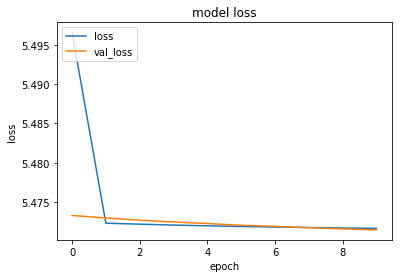

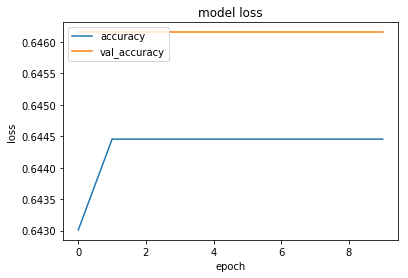

ES STEPS: 1 BEST SCORE: 0.6473 
ES STEPS: 2 BEST SCORE: 0.6473 
ES STEPS: 3 BEST SCORE: 0.6514 
ES STEPS: 4 BEST SCORE: 0.6514 
ES STEPS: 5 BEST SCORE: 0.6514 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.0182 - acc: 0.6517 - val_loss: 5.0306 - val_acc: 0.6452
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.9892 - acc: 0.6505 - val_loss: 4.9854 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.9301 - acc: 0.6490 - val_loss: 4.9531 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 85us/step - loss: 4.8179 - acc: 0.6507 - val_loss: 4.7869 - val_acc: 0.6471
Epoch 5/10
4157/4157 [==============================] - 0s 86us/step - loss: 4.6767 - acc: 0.6473 - val_loss: 4.7178 - val_acc: 0.6452
Epoch 6/10
4157/4157 [==============================] - 0s 85us/step - loss: 4.5663 - acc: 0.64

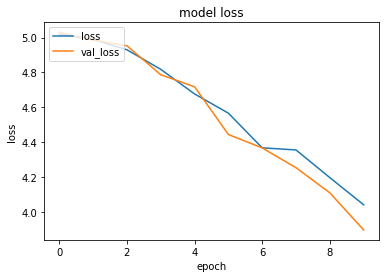

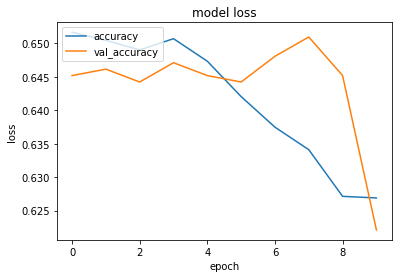

ES STEPS: 1 BEST SCORE: 0.6471 
ES STEPS: 2 BEST SCORE: 0.6476 
ES STEPS: 3 BEST SCORE: 0.6512 
ES STEPS: 4 BEST SCORE: 0.6512 
ES STEPS: 5 BEST SCORE: 0.6512 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4894 - acc: 0.6514 - val_loss: 5.5354 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.5505 - acc: 0.6461 - val_loss: 5.5396 - val_acc: 0.6490
Epoch 3/10
4157/4157 [==============================] - 0s 85us/step - loss: 5.6268 - acc: 0.6418 - val_loss: 5.7573 - val_acc: 0.6317
Epoch 4/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.5969 - acc: 0.6430 - val_loss: 5.6380 - val_acc: 0.6433
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


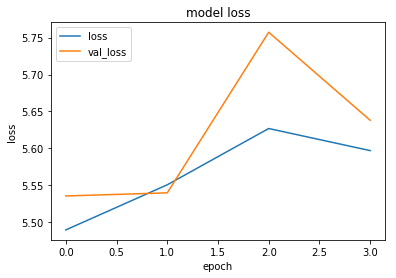

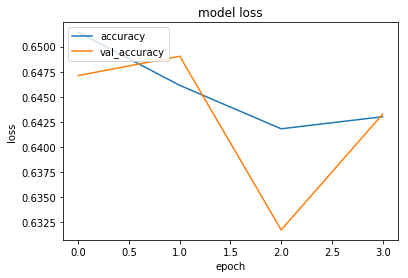

ES STEPS: 1 BEST SCORE: 0.6531 
ES STEPS: 2 BEST SCORE: 0.6531 
ES STEPS: 3 BEST SCORE: 0.6531 
ES STEPS: 4 BEST SCORE: 0.6531 
ES STEPS: 5 BEST SCORE: 0.6531 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 85us/step - loss: 5.4399 - acc: 0.6538 - val_loss: 5.4698 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4276 - acc: 0.6531 - val_loss: 5.4131 - val_acc: 0.6538
Epoch 3/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.4606 - acc: 0.6502 - val_loss: 5.6712 - val_acc: 0.6423
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5862 - acc: 0.6418 - val_loss: 5.6572 - val_acc: 0.6413
Epoch 5/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.5054 - acc: 0.6469 - val_loss: 5.4886 - val_acc: 0.6500
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


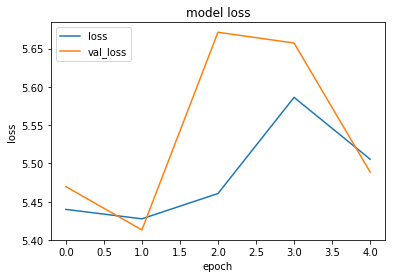

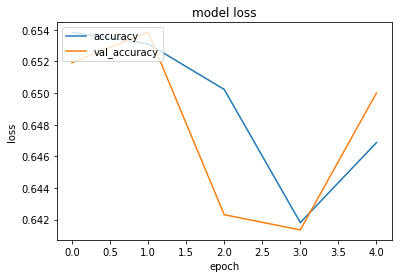

ES STEPS: 1 BEST SCORE: 0.6553 
ES STEPS: 2 BEST SCORE: 0.6553 
ES STEPS: 3 BEST SCORE: 0.6553 
ES STEPS: 4 BEST SCORE: 0.6553 
ES STEPS: 5 BEST SCORE: 0.6553 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.4167 - acc: 0.6538 - val_loss: 5.4423 - val_acc: 0.6558
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3990 - acc: 0.6529 - val_loss: 5.4029 - val_acc: 0.6538
Epoch 3/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.3940 - acc: 0.6536 - val_loss: 5.3696 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.4096 - acc: 0.6526 - val_loss: 5.4046 - val_acc: 0.6567
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4316 - acc: 0.6517 - val_loss: 5.4376 - val_acc: 0.6548
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3625 - acc: 0.65

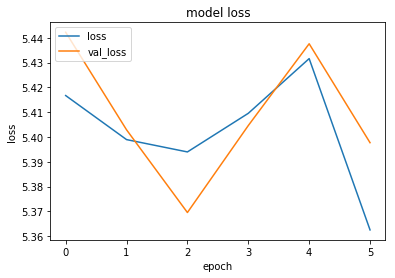

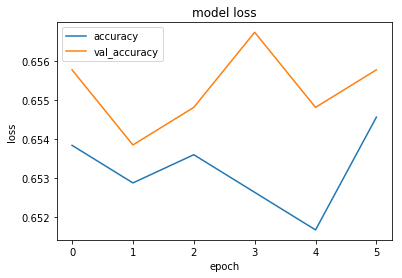

ES STEPS: 1 BEST SCORE: 0.6519 
ES STEPS: 2 BEST SCORE: 0.6519 
ES STEPS: 3 BEST SCORE: 0.6524 
ES STEPS: 4 BEST SCORE: 0.6524 
ES STEPS: 5 BEST SCORE: 0.6524 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.8862 - acc: 0.6512 - val_loss: 4.9093 - val_acc: 0.6500
Epoch 2/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.8601 - acc: 0.6493 - val_loss: 4.9092 - val_acc: 0.6500
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.8599 - acc: 0.6493 - val_loss: 4.9092 - val_acc: 0.6500
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.8597 - acc: 0.6493 - val_loss: 4.9092 - val_acc: 0.6500
Epoch 5/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.8596 - acc: 0.6493 - val_loss: 4.9092 - val_acc: 0.6500
Epoch 6/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.8595 - acc: 0.64

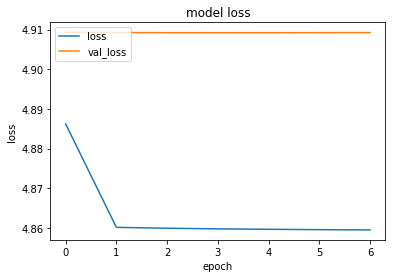

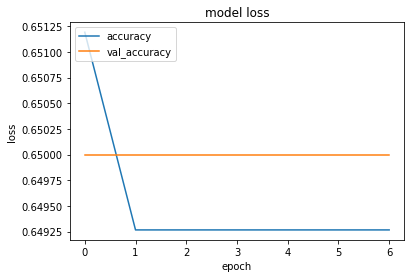

ES STEPS: 1 BEST SCORE: 0.6493 
ES STEPS: 2 BEST SCORE: 0.6493 
ES STEPS: 3 BEST SCORE: 0.6493 
ES STEPS: 4 BEST SCORE: 0.6493 
ES STEPS: 5 BEST SCORE: 0.6493 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 83us/step - loss: 4.8596 - acc: 0.6493 - val_loss: 4.9092 - val_acc: 0.6500
Epoch 2/10
4157/4157 [==============================] - 0s 85us/step - loss: 4.8595 - acc: 0.6493 - val_loss: 4.9092 - val_acc: 0.6500
Epoch 3/10
4157/4157 [==============================] - 0s 85us/step - loss: 4.8595 - acc: 0.6493 - val_loss: 4.9092 - val_acc: 0.6500
Epoch 4/10
4157/4157 [==============================] - 0s 84us/step - loss: 4.8594 - acc: 0.6493 - val_loss: 4.9092 - val_acc: 0.6500
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


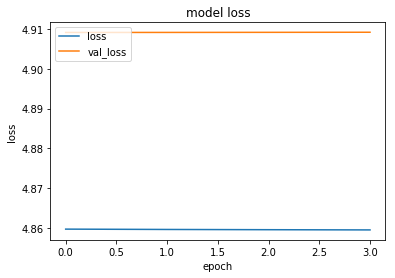

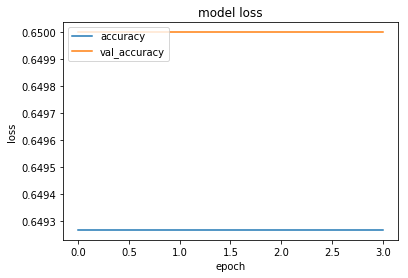

ES STEPS: 1 BEST SCORE: 0.6493 
ES STEPS: 2 BEST SCORE: 0.6493 
ES STEPS: 3 BEST SCORE: 0.6493 
ES STEPS: 4 BEST SCORE: 0.6493 
ES STEPS: 5 BEST SCORE: 0.6493 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.8596 - acc: 0.6493 - val_loss: 4.9092 - val_acc: 0.6500
Epoch 2/10
4157/4157 [==============================] - 0s 81us/step - loss: 4.8595 - acc: 0.6493 - val_loss: 4.9092 - val_acc: 0.6500
Epoch 3/10
4157/4157 [==============================] - 0s 80us/step - loss: 4.8594 - acc: 0.6493 - val_loss: 4.9092 - val_acc: 0.6500
Epoch 4/10
4157/4157 [==============================] - 0s 83us/step - loss: 4.8594 - acc: 0.6493 - val_loss: 4.9093 - val_acc: 0.6500
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


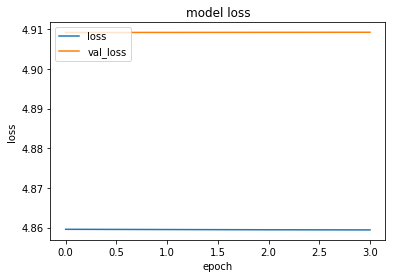

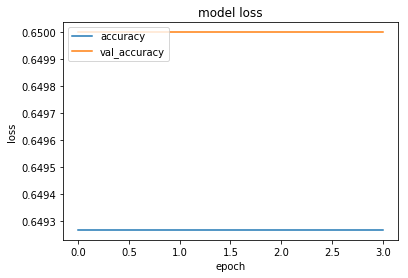

ES STEPS: 1 BEST SCORE: 0.6497 
ES STEPS: 2 BEST SCORE: 0.6497 
ES STEPS: 3 BEST SCORE: 0.6497 
ES STEPS: 4 BEST SCORE: 0.6497 
ES STEPS: 5 BEST SCORE: 0.6497 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 84us/step - loss: 4.8132 - acc: 0.6481 - val_loss: 4.3984 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 89us/step - loss: 4.2126 - acc: 0.6394 - val_loss: 4.2546 - val_acc: 0.6394
Epoch 3/10
4157/4157 [==============================] - 0s 82us/step - loss: 4.0758 - acc: 0.6344 - val_loss: 4.2481 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 83us/step - loss: 3.9377 - acc: 0.6271 - val_loss: 3.9959 - val_acc: 0.6192
Epoch 5/10
4157/4157 [==============================] - 0s 81us/step - loss: 3.8332 - acc: 0.6182 - val_loss: 3.9380 - val_acc: 0.6231
Epoch 6/10
4157/4157 [==============================] - 0s 83us/step - loss: 3.8231 - acc: 0.61

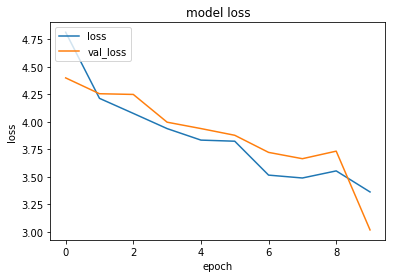

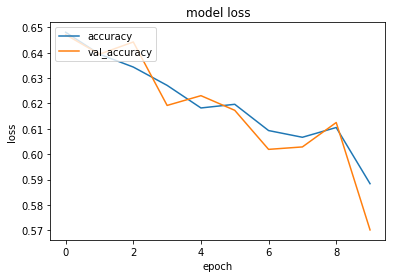

ES STEPS: 1 BEST SCORE: 0.6377 
ES STEPS: 2 BEST SCORE: 0.6394 
ES STEPS: 3 BEST SCORE: 0.6493 
ES STEPS: 4 BEST SCORE: 0.6493 
ES STEPS: 5 BEST SCORE: 0.6493 
Stop: Reach max_steps
Our accuracy is 63.85%
Our AUC is 52.26%


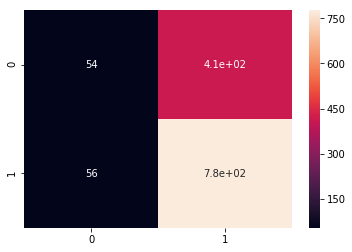

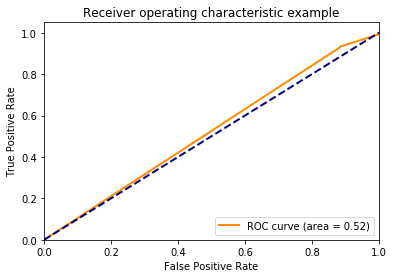

In [9]:
# Initialize
model = ModelCompile()
weights = model.get_weights() 
MyES = ES(model, X_train, y_train, InitialSigma = 0.1, ParentsSize = 15, ChildSize = 100, tao = 0.5)   
weights, ES_Optimized_ObjVal, _, _  = MyES.run(weights, useOLSReg =False, max_steps=3, verbose = 1)

# Optimize
GlobalBestAccuracy = 0
NoImproveTimes = 0
while True:
  # Gradient-based Optimize
  model, weights = ModelFit(model=model, weights=weights)

  # ES
  weights, ES_Optimized_ObjVal, _, _ = MyES.run(weights, max_steps=5, verbose = 1)
    
  # Stop Criteria
  if ES_Optimized_ObjVal > GlobalBestAccuracy:
    GlobalBestAccuracy = ES_Optimized_ObjVal
    NoImproveTimes = 0
  else: 
    NoImproveTimes = NoImproveTimes + 1
    if NoImproveTimes == 5:
      break
    
Performance(model)

## 版本2：ParentsSize = #param x2, ChildSize = ParentsSize*7

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
IntermediateLayer (Dense)    (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 1 BEST SCORE: 0.6538 
ES STEPS: 2 BEST SCORE: 0.6538 
ES STEPS: 3 BEST SCORE: 0.6538 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 1s 128us/step - loss: 5.5769 - acc: 0.6500 - val_loss:

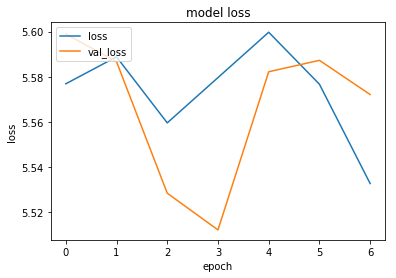

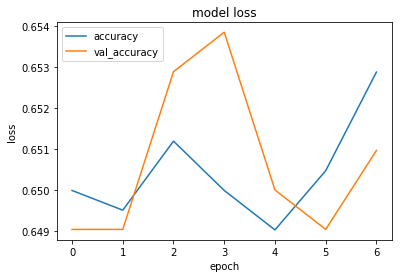

ES STEPS: 1 BEST SCORE: 0.6584 
ES STEPS: 2 BEST SCORE: 0.6584 
ES STEPS: 3 BEST SCORE: 0.6584 
ES STEPS: 4 BEST SCORE: 0.6584 
ES STEPS: 5 BEST SCORE: 0.6584 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6138 - acc: 0.6473 - val_loss: 5.4307 - val_acc: 0.6596
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7446 - acc: 0.6392 - val_loss: 5.9879 - val_acc: 0.6240
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.8266 - acc: 0.6341 - val_loss: 5.9939 - val_acc: 0.6240
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.8294 - acc: 0.6344 - val_loss: 5.9939 - val_acc: 0.6240
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


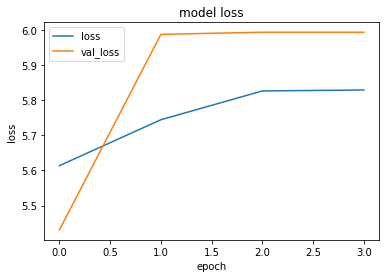

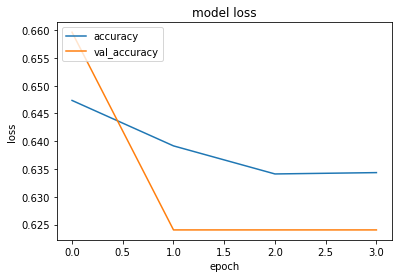

ES STEPS: 1 BEST SCORE: 0.6642 
ES STEPS: 2 BEST SCORE: 0.6642 
ES STEPS: 3 BEST SCORE: 0.6642 
ES STEPS: 4 BEST SCORE: 0.6642 
ES STEPS: 5 BEST SCORE: 0.6642 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.4647 - acc: 0.6572 - val_loss: 5.6737 - val_acc: 0.6442
Epoch 2/10
4157/4157 [==============================] - 0s 89us/step - loss: 5.4025 - acc: 0.6613 - val_loss: 5.4769 - val_acc: 0.6567
Epoch 3/10
4157/4157 [==============================] - 0s 86us/step - loss: 5.4143 - acc: 0.6603 - val_loss: 5.5985 - val_acc: 0.6490
Epoch 4/10
4157/4157 [==============================] - 0s 86us/step - loss: 5.4679 - acc: 0.6565 - val_loss: 5.6755 - val_acc: 0.6433
Epoch 5/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4235 - acc: 0.6599 - val_loss: 5.6725 - val_acc: 0.6442
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


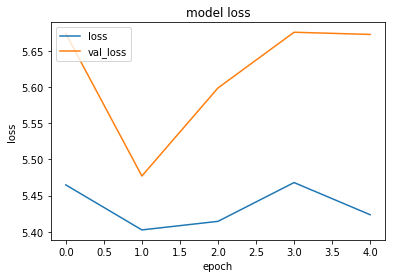

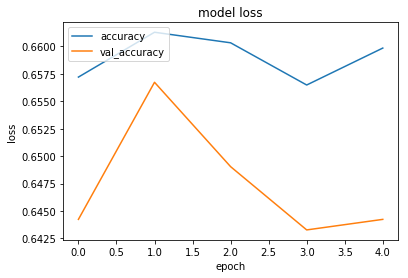

ES STEPS: 1 BEST SCORE: 0.6700 
ES STEPS: 2 BEST SCORE: 0.6700 
ES STEPS: 3 BEST SCORE: 0.6700 
ES STEPS: 4 BEST SCORE: 0.6700 
ES STEPS: 5 BEST SCORE: 0.6700 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.2943 - acc: 0.6678 - val_loss: 5.3244 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3051 - acc: 0.6671 - val_loss: 5.2708 - val_acc: 0.6702
Epoch 3/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.3226 - acc: 0.6666 - val_loss: 5.1911 - val_acc: 0.6750
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.2746 - acc: 0.6690 - val_loss: 5.2812 - val_acc: 0.6683
Epoch 5/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.3039 - acc: 0.6671 - val_loss: 5.3093 - val_acc: 0.6673
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3682 - acc: 0.66

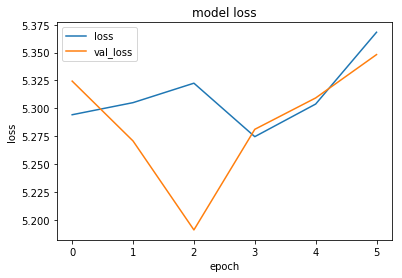

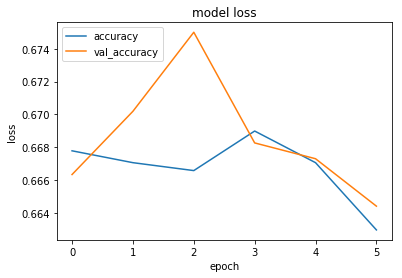

ES STEPS: 1 BEST SCORE: 0.6675 
ES STEPS: 2 BEST SCORE: 0.6675 
ES STEPS: 3 BEST SCORE: 0.6675 
ES STEPS: 4 BEST SCORE: 0.6675 
ES STEPS: 5 BEST SCORE: 0.6675 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3375 - acc: 0.6654 - val_loss: 5.2643 - val_acc: 0.6702
Epoch 2/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.3265 - acc: 0.6656 - val_loss: 5.3473 - val_acc: 0.6644
Epoch 3/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.3805 - acc: 0.6625 - val_loss: 5.3086 - val_acc: 0.6673
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.2593 - acc: 0.6704 - val_loss: 5.2776 - val_acc: 0.6692
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


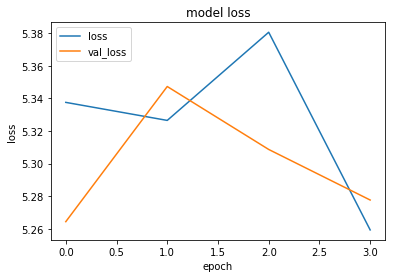

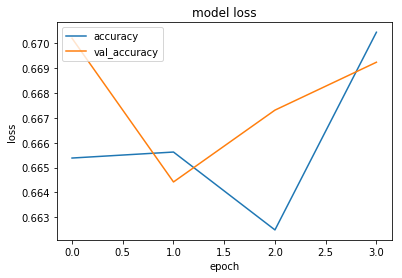

ES STEPS: 1 BEST SCORE: 0.6700 
ES STEPS: 2 BEST SCORE: 0.6700 
ES STEPS: 3 BEST SCORE: 0.6700 
ES STEPS: 4 BEST SCORE: 0.6700 
ES STEPS: 5 BEST SCORE: 0.6700 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.2747 - acc: 0.6695 - val_loss: 5.5459 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.2685 - acc: 0.6695 - val_loss: 5.5710 - val_acc: 0.6510
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4684 - acc: 0.6572 - val_loss: 5.8608 - val_acc: 0.6327
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4958 - acc: 0.6555 - val_loss: 5.8487 - val_acc: 0.6327
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


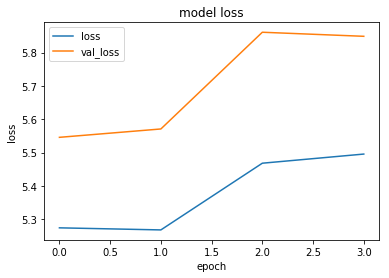

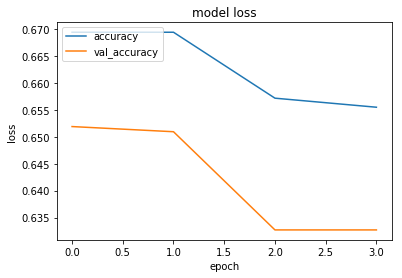

Our accuracy is 67.0%
Our AUC is 57.88%


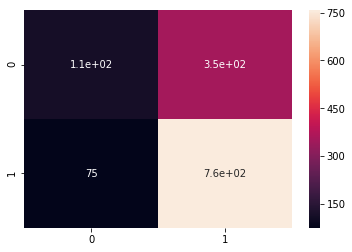

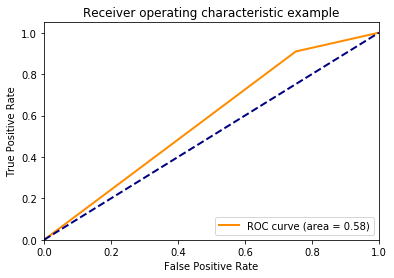

In [12]:
# Initialize
model = ModelCompile()
weights = model.get_weights() 
MyES = ES(model, X_train, y_train, InitialSigma = 0.1, ParentsSize = model.count_params()*2, ChildSize = model.count_params()*2*7, tao = 0.5)   
weights, ES_Optimized_ObjVal, _, _  = MyES.run(weights, useOLSReg =False, max_steps=3, verbose = 1)

# Optimize
GlobalBestAccuracy = 0
NoImproveTimes = 0
while True:
  # Gradient-based Optimize
  model, weights = ModelFit(model=model, weights=weights)

  # ES
  weights, ES_Optimized_ObjVal,_,_ = MyES.run(weights, max_steps=5, verbose = 1)

  # Stop Criteria
  if ES_Optimized_ObjVal > GlobalBestAccuracy:
    GlobalBestAccuracy = ES_Optimized_ObjVal
    NoImproveTimes = 0
  else: 
    NoImproveTimes = NoImproveTimes + 1
    if NoImproveTimes == 2:
      break
    
# Gradient-based Optimize
model, weights = ModelFit(model=model, weights=weights)    

Performance(model)

## 版本3：ParentsSize = #param x2, ChildSize = ParentsSize*7 With MultiPgase

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
IntermediateLayer (Dense)    (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 139
Trainable params: 139
Non-trainable params: 0
_________________________________________________________________
ES STEPS: 1 BEST SCORE: 0.6336 
ES STEPS: 2 BEST SCORE: 0.6375 
ES STEPS: 3 BEST SCORE: 0.6375 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 1s 126us/step - loss: 5.6822 - acc: 0.6418 - val_loss:

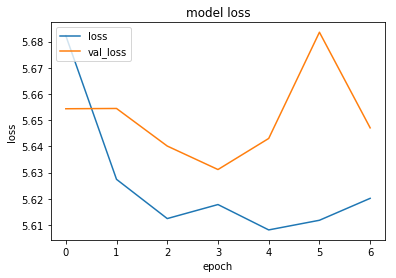

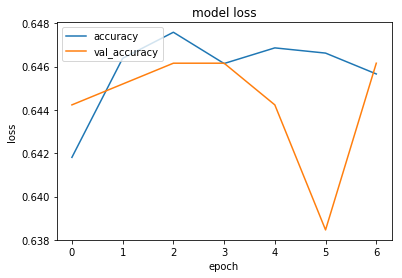

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 92us/step - loss: 5.6256 - acc: 0.6447 - val_loss: 5.6072 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 93us/step - loss: 5.6348 - acc: 0.6464 - val_loss: 5.6231 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 86us/step - loss: 5.6078 - acc: 0.6469 - val_loss: 5.5990 - val_acc: 0.6481
Epoch 4/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.6031 - acc: 0.6481 - val_loss: 5.6468 - val_acc: 0.6462
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6196 - acc: 0.6471 - val_loss: 5.6622 - val_acc: 0.6452
Epoch 6/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.6123 - acc: 0.6476 - val_loss: 5.6800 - val_acc: 0.6423
Restoring model weights from the end of the best epoch
Epoch 00006: early stopping


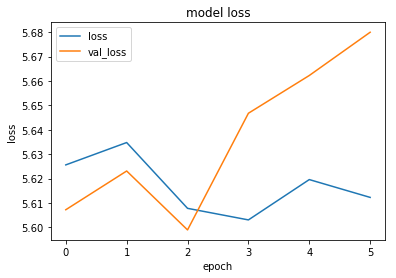

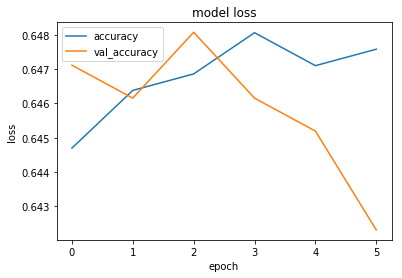

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6384 - acc: 0.6454 - val_loss: 5.6271 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6305 - acc: 0.6457 - val_loss: 5.6312 - val_acc: 0.6452
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.7107 - acc: 0.6404 - val_loss: 5.6534 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6715 - acc: 0.6425 - val_loss: 5.6087 - val_acc: 0.6462
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5901 - acc: 0.6485 - val_loss: 5.5882 - val_acc: 0.6500
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6280 - acc: 0.6452 - val_loss: 5.6552 - val_acc: 0.6452
Epoch 7/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.6268 - acc: 0.6461 - val_loss: 5.6490 - val_acc: 0.6452
Epoch 8

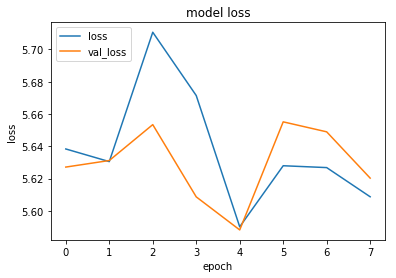

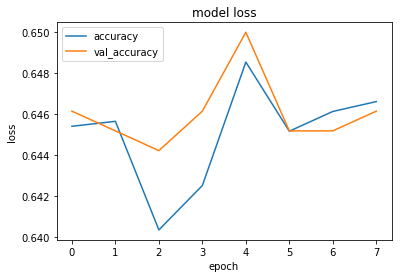

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6395 - acc: 0.6445 - val_loss: 5.5875 - val_acc: 0.6481
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6096 - acc: 0.6473 - val_loss: 5.5655 - val_acc: 0.6500
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6280 - acc: 0.6459 - val_loss: 5.6245 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.6250 - acc: 0.6454 - val_loss: 5.6055 - val_acc: 0.6481
Epoch 5/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.5912 - acc: 0.6485 - val_loss: 5.6356 - val_acc: 0.6442
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


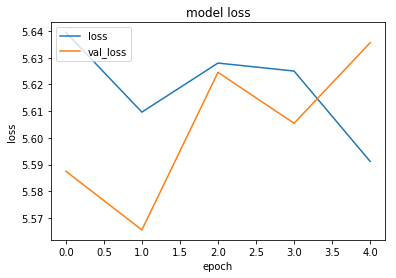

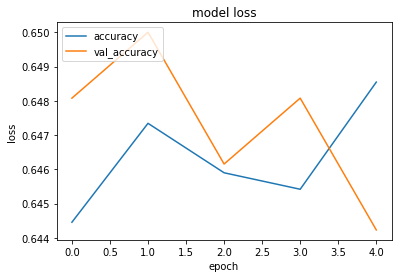

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.6235 - acc: 0.6461 - val_loss: 5.6236 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6148 - acc: 0.6461 - val_loss: 5.6217 - val_acc: 0.6471
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6337 - acc: 0.6457 - val_loss: 5.6394 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.5869 - acc: 0.6476 - val_loss: 5.6807 - val_acc: 0.6433
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5833 - acc: 0.6488 - val_loss: 5.7023 - val_acc: 0.6413
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


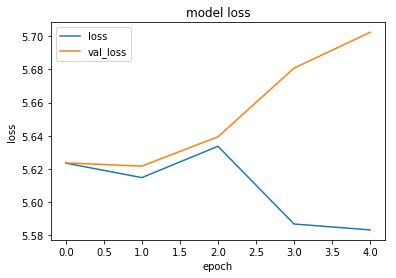

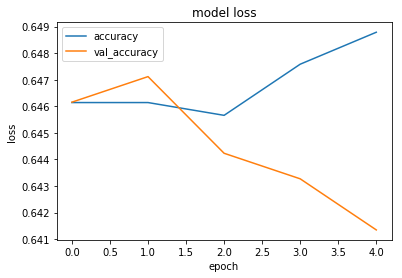

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6051 - acc: 0.6476 - val_loss: 5.6317 - val_acc: 0.6452
Epoch 2/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.6437 - acc: 0.6445 - val_loss: 5.6226 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.6044 - acc: 0.6461 - val_loss: 5.6274 - val_acc: 0.6471
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6185 - acc: 0.6461 - val_loss: 5.6383 - val_acc: 0.6452
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6202 - acc: 0.6466 - val_loss: 5.6479 - val_acc: 0.6452
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


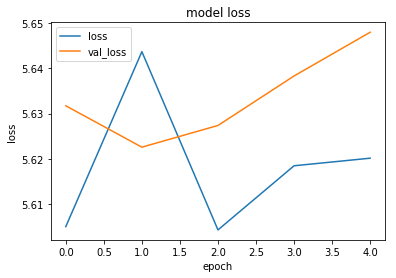

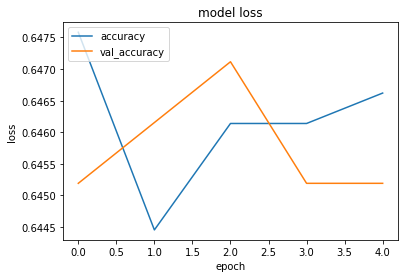

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6233 - acc: 0.6459 - val_loss: 5.6295 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6340 - acc: 0.6459 - val_loss: 5.6272 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6788 - acc: 0.6433 - val_loss: 5.6738 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6384 - acc: 0.6452 - val_loss: 5.6411 - val_acc: 0.6462
Epoch 5/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6237 - acc: 0.6464 - val_loss: 5.6506 - val_acc: 0.6452
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


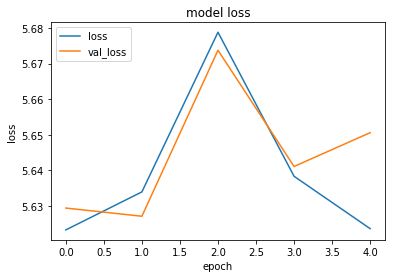

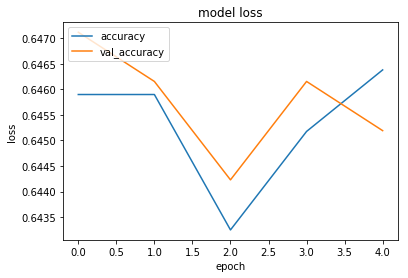

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6168 - acc: 0.6459 - val_loss: 5.7281 - val_acc: 0.6394
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6252 - acc: 0.6459 - val_loss: 5.6174 - val_acc: 0.6481
Epoch 3/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6134 - acc: 0.6471 - val_loss: 5.6197 - val_acc: 0.6471
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.7051 - acc: 0.6408 - val_loss: 5.6356 - val_acc: 0.6442
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6369 - acc: 0.6449 - val_loss: 5.6095 - val_acc: 0.6471
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6123 - acc: 0.6459 - val_loss: 5.6768 - val_acc: 0.6433
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6227 - acc: 0.6457 - val_loss: 5.6593 - val_acc: 0.6452
Epoch 8

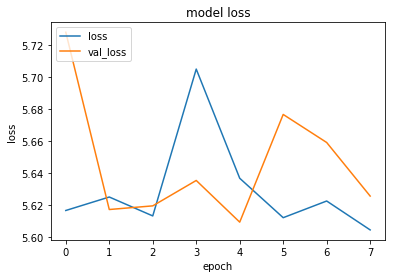

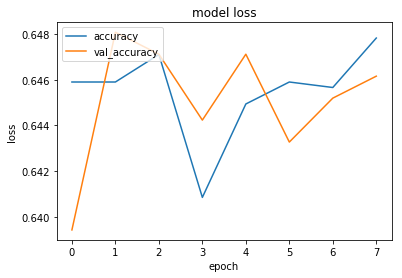

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6581 - acc: 0.6437 - val_loss: 5.6083 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6322 - acc: 0.6454 - val_loss: 5.6170 - val_acc: 0.6471
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6124 - acc: 0.6464 - val_loss: 5.6393 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6273 - acc: 0.6459 - val_loss: 5.6427 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


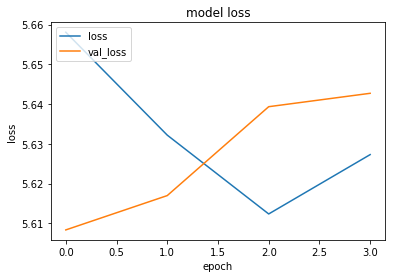

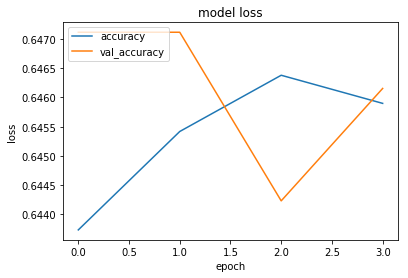

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.6038 - acc: 0.6476 - val_loss: 5.7459 - val_acc: 0.6394
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6719 - acc: 0.6430 - val_loss: 5.6864 - val_acc: 0.6404
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6279 - acc: 0.6454 - val_loss: 5.6776 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6226 - acc: 0.6464 - val_loss: 5.6183 - val_acc: 0.6481
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6087 - acc: 0.6481 - val_loss: 5.6189 - val_acc: 0.6471
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6327 - acc: 0.6452 - val_loss: 5.6442 - val_acc: 0.6442
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5972 - acc: 0.6478 - val_loss: 5.6007 - val_acc: 0.6481
Epoch 8

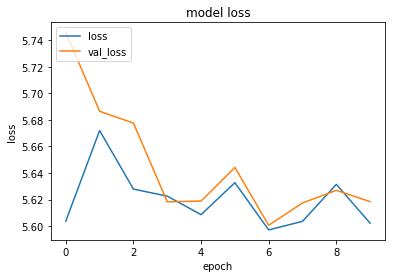

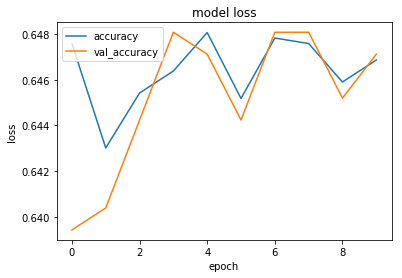

ES STEPS: 1 BEST SCORE: 0.6476 
ES STEPS: 2 BEST SCORE: 0.6476 
ES STEPS: 3 BEST SCORE: 0.6476 
ES STEPS: 4 BEST SCORE: 0.6476 
ES STEPS: 5 BEST SCORE: 0.6476 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6413 - acc: 0.6461 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


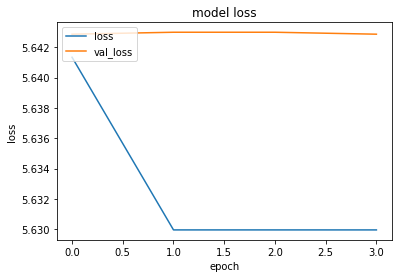

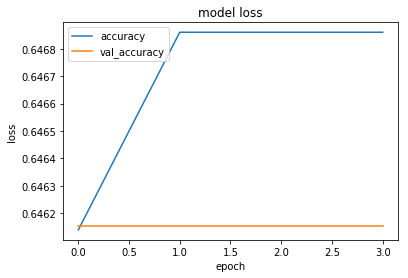

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 84us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


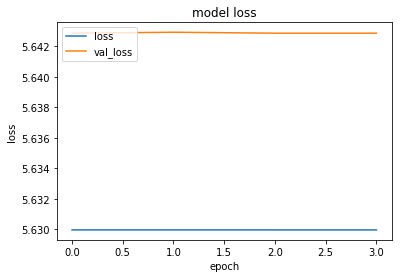

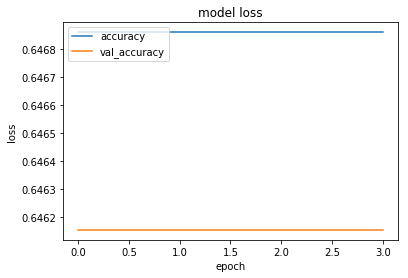

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6220 - acc: 0.6473 - val_loss: 5.6277 - val_acc: 0.6471
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6322 - acc: 0.6466 - val_loss: 5.6122 - val_acc: 0.6481
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6322 - acc: 0.6466 - val_loss: 5.6122 - val_acc: 0.6481
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6322 - acc: 0.6466 - val_loss: 5.6122 - val_acc: 0.6481
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6322 - acc: 0.6466 - val_loss: 5.6122 - val_acc: 0.6481
Restori

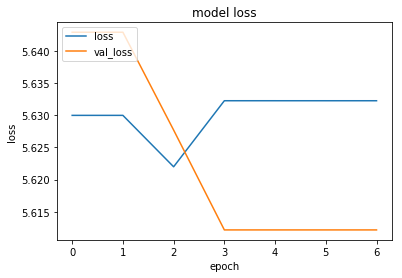

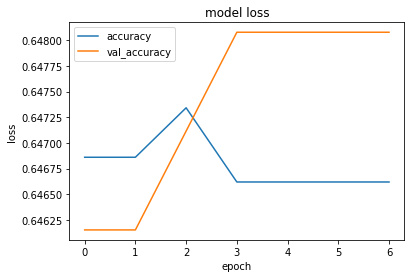

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6428 - val_acc: 0.6462
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 6/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Restori

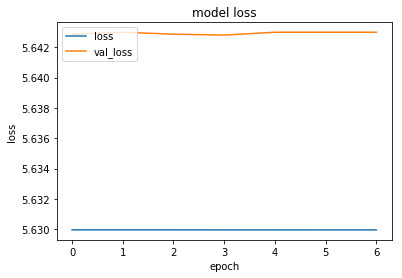

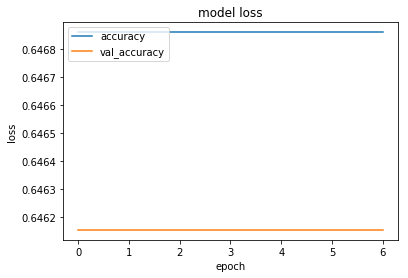

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6431 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 5/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6431 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00006: early stopping


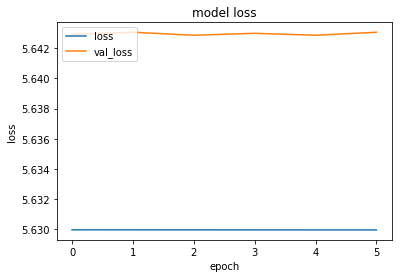

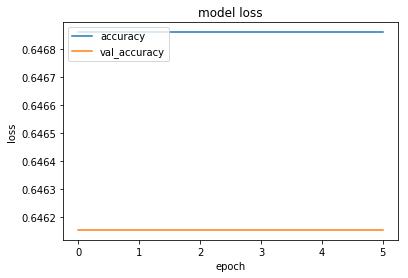

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6431 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 6/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 7/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Restori

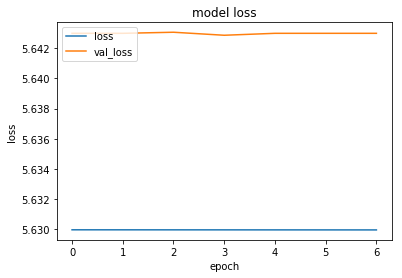

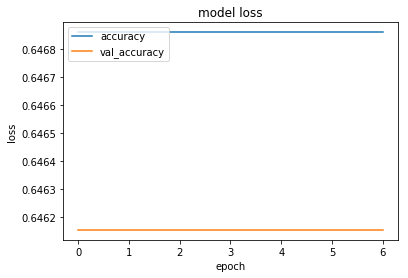

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


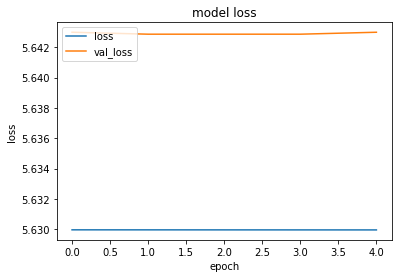

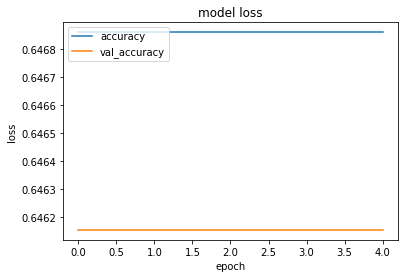

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 5/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


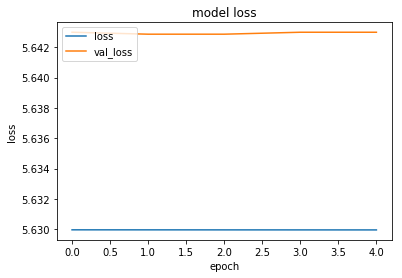

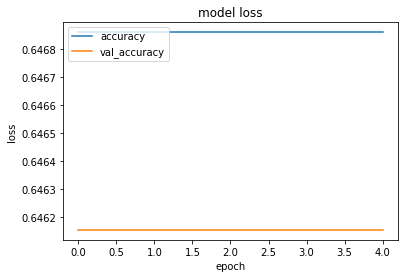

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6430 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 84us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 84us/step - loss: 5.6326 - acc: 0.6466 - val_loss: 5.5967 - val_acc: 0.6490
Epoch 5/10
4157/4157 [==============================] - 0s 84us/step - loss: 5.6283 - acc: 0.6469 - val_loss: 5.5967 - val_acc: 0.6490
Epoch 6/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6283 - acc: 0.6469 - val_loss: 5.5967 - val_acc: 0.6490
Epoch 7/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6283 - acc: 0.6469 - val_loss: 5.5967 - val_acc: 0.6490
Restori

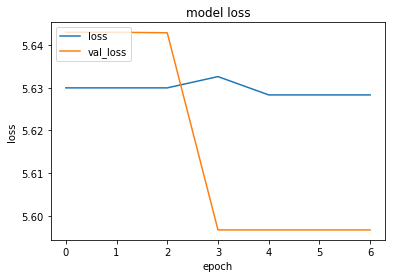

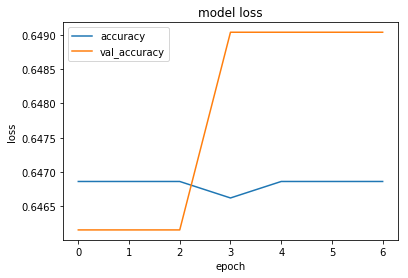

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6300 - acc: 0.6469 - val_loss: 5.6429 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


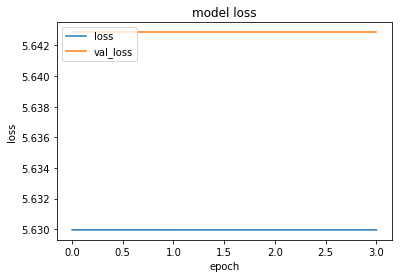

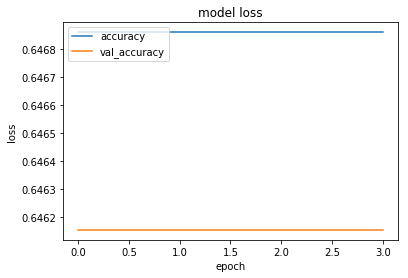

ES STEPS: 1 BEST SCORE: 0.6469 
ES STEPS: 2 BEST SCORE: 0.6469 
ES STEPS: 3 BEST SCORE: 0.6469 
ES STEPS: 4 BEST SCORE: 0.6469 
ES STEPS: 5 BEST SCORE: 0.6469 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


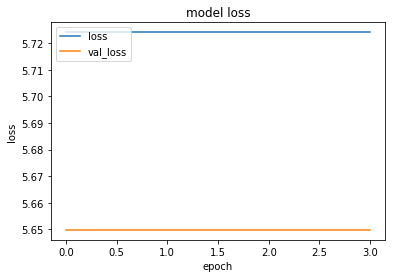

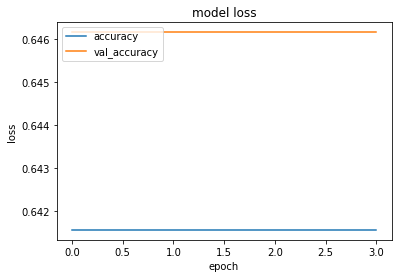

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


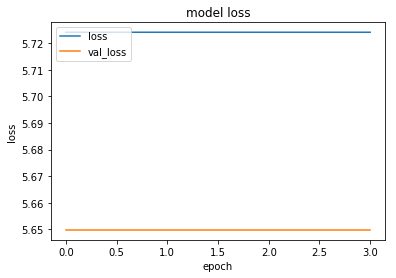

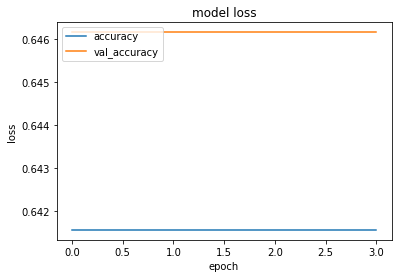

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


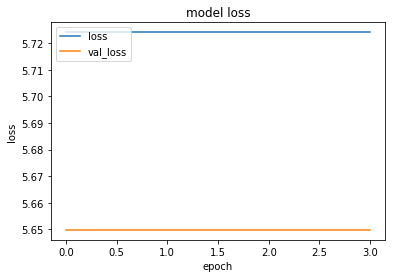

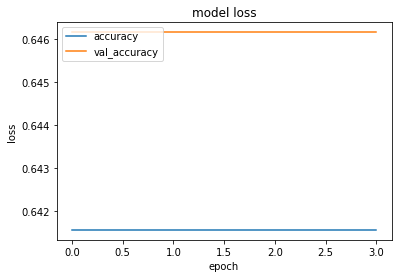

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


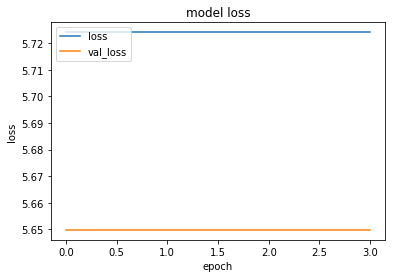

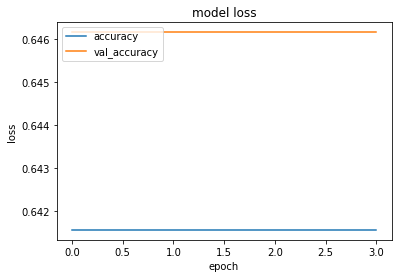

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


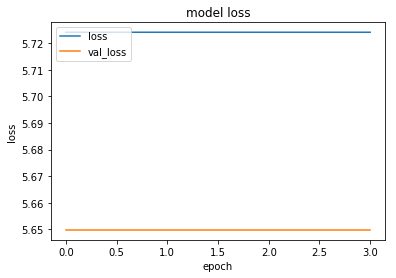

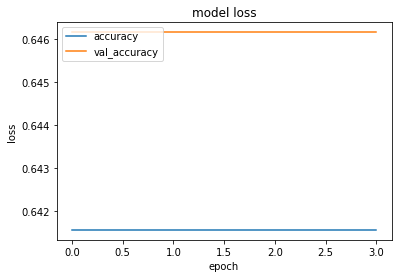

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


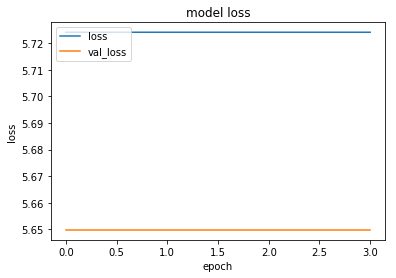

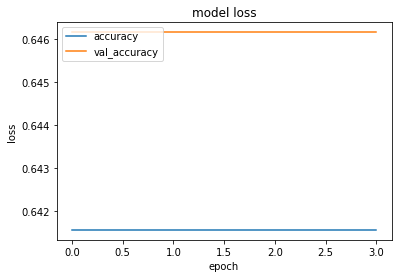

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


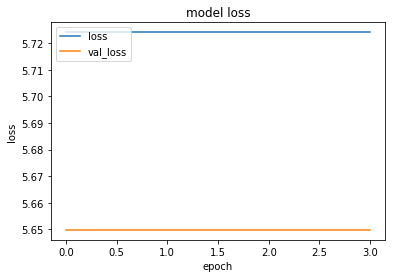

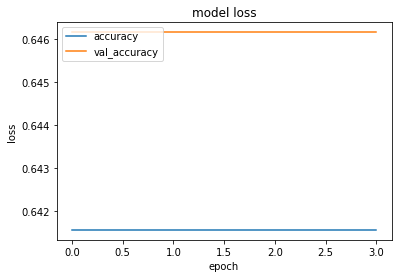

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 84us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


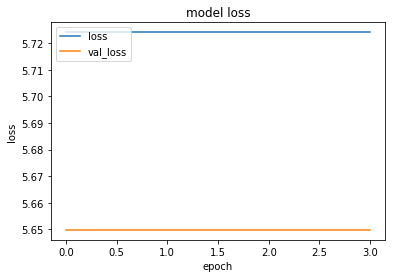

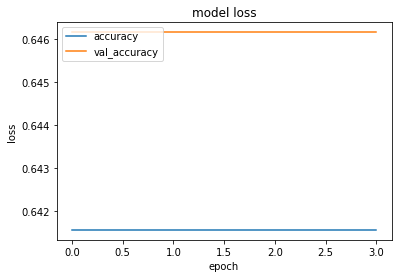

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 85us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


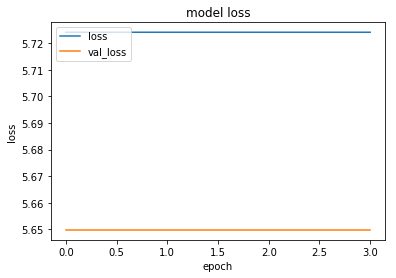

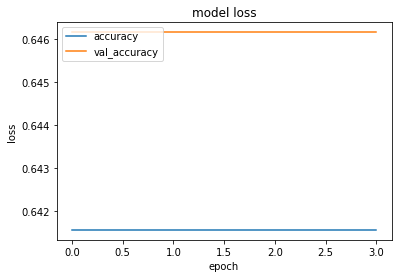

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.7241 - acc: 0.6416 - val_loss: 5.6498 - val_acc: 0.6462
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


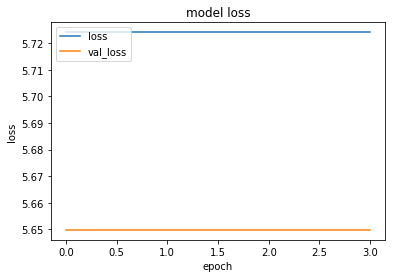

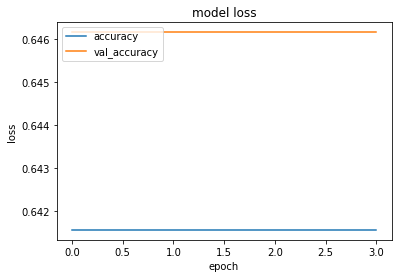

ES STEPS: 1 BEST SCORE: 0.6466 
ES STEPS: 2 BEST SCORE: 0.6466 
ES STEPS: 3 BEST SCORE: 0.6466 
ES STEPS: 4 BEST SCORE: 0.6478 
ES STEPS: 5 BEST SCORE: 0.6478 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


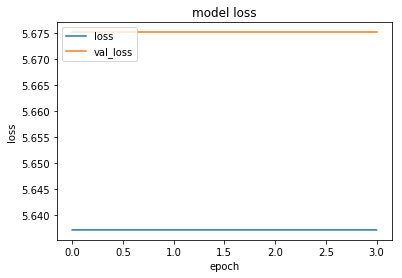

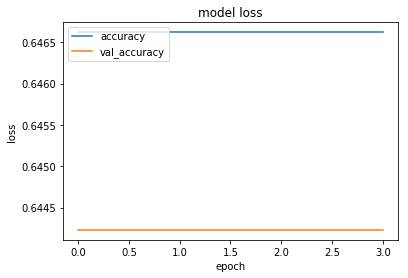

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


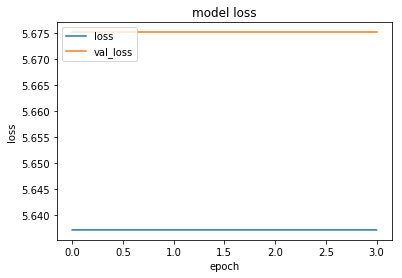

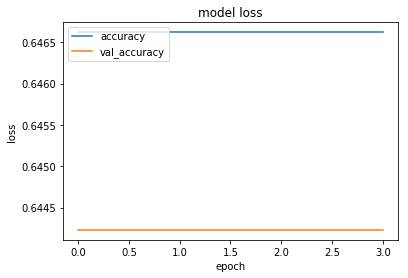

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 74us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 3/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


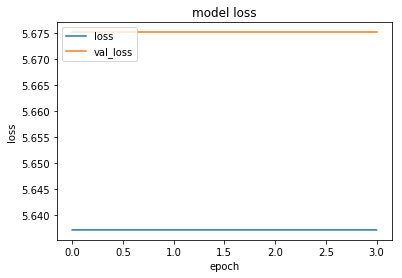

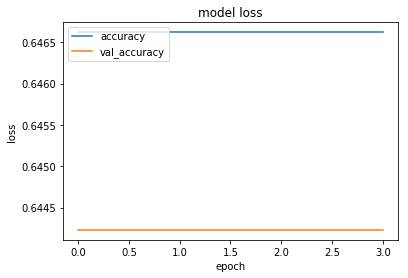

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


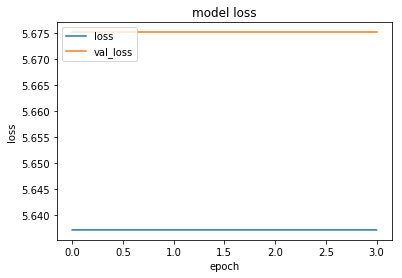

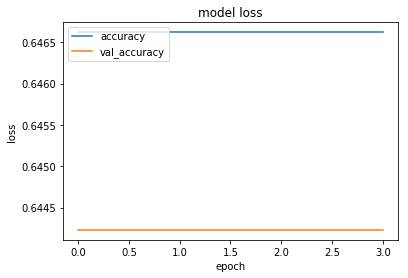

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


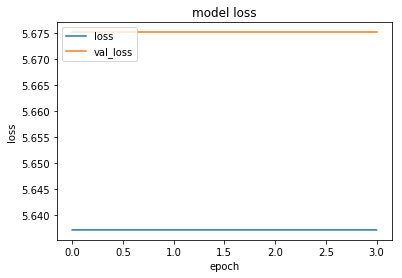

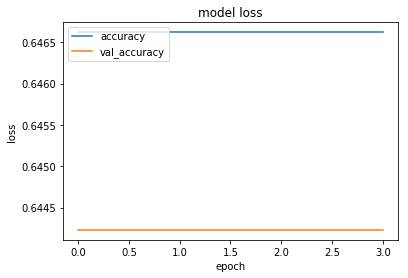

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


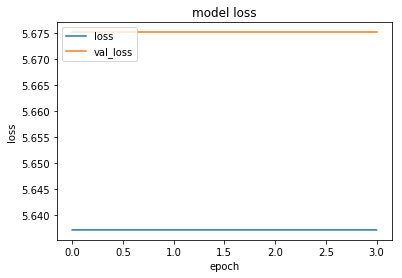

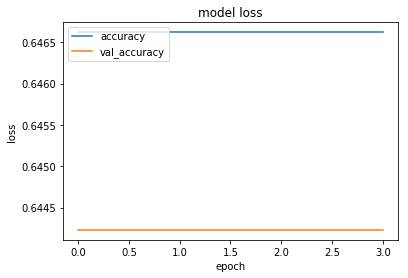

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


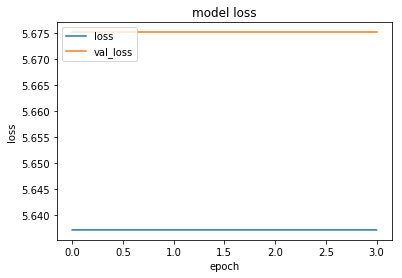

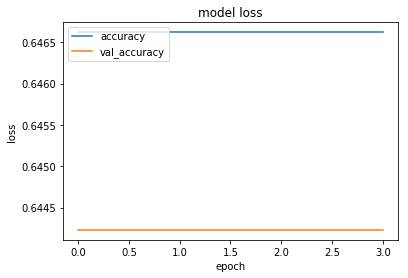

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 2/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 3/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


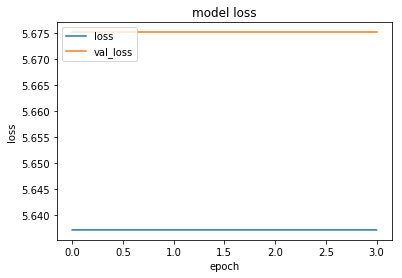

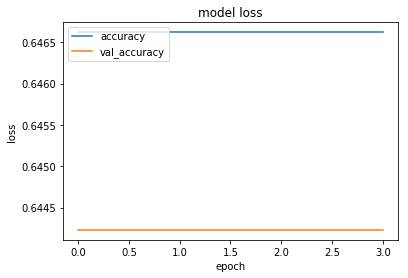

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


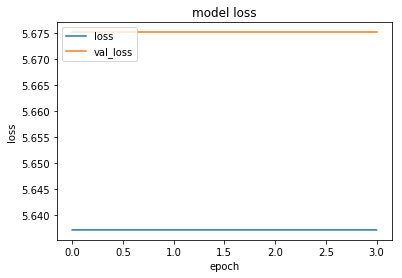

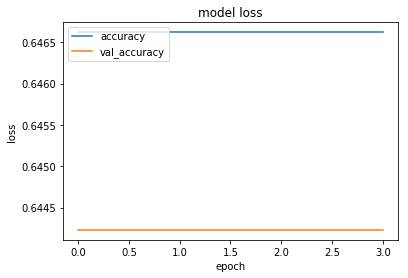

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 2/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 3/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Epoch 4/10
4157/4157 [==============================] - 0s 84us/step - loss: 5.6371 - acc: 0.6466 - val_loss: 5.6752 - val_acc: 0.6442
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


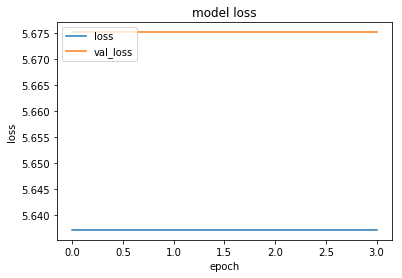

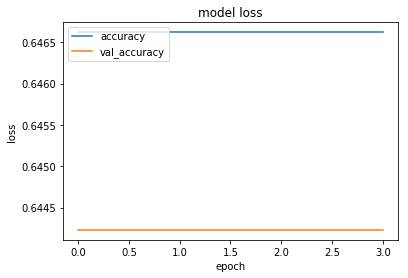

ES STEPS: 1 BEST SCORE: 0.6473 
ES STEPS: 2 BEST SCORE: 0.6485 
ES STEPS: 3 BEST SCORE: 0.6485 
ES STEPS: 4 BEST SCORE: 0.6485 
ES STEPS: 5 BEST SCORE: 0.6502 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1602 - acc: 0.6502 - val_loss: 5.1538 - val_acc: 0.6452
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1423 - acc: 0.6502 - val_loss: 5.1376 - val_acc: 0.6452
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1300 - acc: 0.6502 - val_loss: 5.1246 - val_acc: 0.6452
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1197 - acc: 0.6502 - val_loss: 5.1132 - val_acc: 0.6452
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1104 - acc: 0.6502 - val_loss: 5.1028 - val_acc: 0.6452
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1020 - acc: 0.65

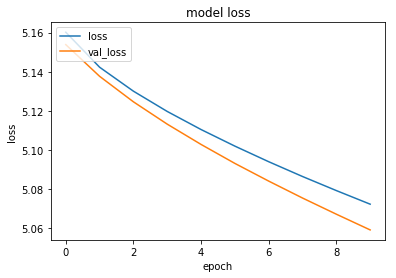

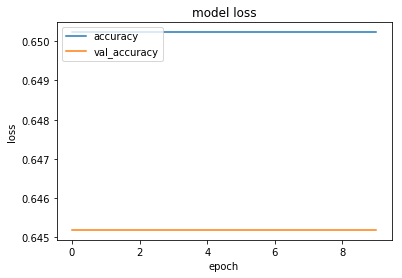

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.0655 - acc: 0.6502 - val_loss: 5.0511 - val_acc: 0.6452
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0589 - acc: 0.6502 - val_loss: 5.0433 - val_acc: 0.6452
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0523 - acc: 0.6502 - val_loss: 5.0357 - val_acc: 0.6452
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0459 - acc: 0.6502 - val_loss: 5.0282 - val_acc: 0.6452
Epoch 5/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.0396 - acc: 0.6502 - val_loss: 5.0209 - val_acc: 0.6452
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0334 - acc: 0.6502 - val_loss: 5.0137 - val_acc: 0.6452
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0272 - acc: 0.6502 - val_loss: 5.0063 - val_acc: 0.6452
Epoch 8

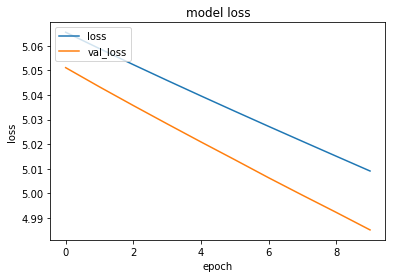

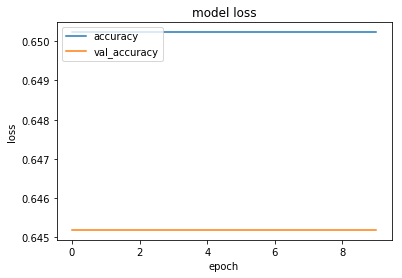

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.0659 - acc: 0.6502 - val_loss: 5.0520 - val_acc: 0.6452
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0599 - acc: 0.6502 - val_loss: 5.0449 - val_acc: 0.6452
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.0539 - acc: 0.6502 - val_loss: 5.0379 - val_acc: 0.6452
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0480 - acc: 0.6502 - val_loss: 5.0310 - val_acc: 0.6452
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0421 - acc: 0.6502 - val_loss: 5.0241 - val_acc: 0.6452
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0362 - acc: 0.6502 - val_loss: 5.0172 - val_acc: 0.6452
Epoch 7/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.0303 - acc: 0.6502 - val_loss: 5.0102 - val_acc: 0.6452
Epoch 8

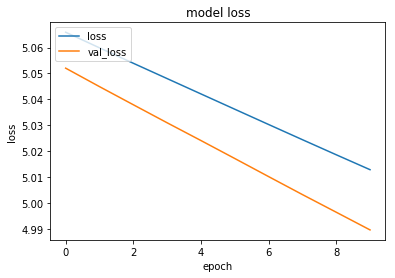

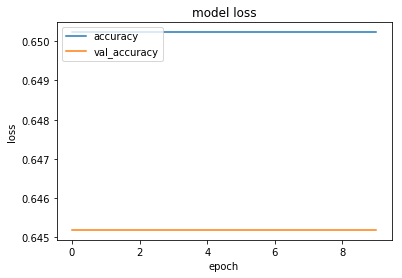

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.0661 - acc: 0.6502 - val_loss: 5.0524 - val_acc: 0.6452
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.0603 - acc: 0.6502 - val_loss: 5.0455 - val_acc: 0.6452
Epoch 3/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.0545 - acc: 0.6502 - val_loss: 5.0387 - val_acc: 0.6452
Epoch 4/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.0487 - acc: 0.6502 - val_loss: 5.0318 - val_acc: 0.6452
Epoch 5/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.0429 - acc: 0.6502 - val_loss: 5.0252 - val_acc: 0.6452
Epoch 6/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.0371 - acc: 0.6502 - val_loss: 5.0183 - val_acc: 0.6452
Epoch 7/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.0313 - acc: 0.6502 - val_loss: 5.0115 - val_acc: 0.6452
Epoch 8

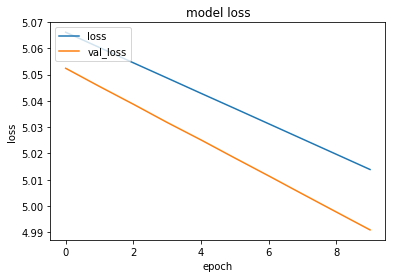

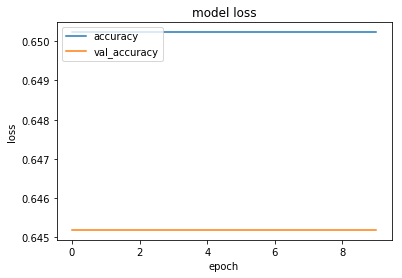

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.0660 - acc: 0.6502 - val_loss: 5.0522 - val_acc: 0.6452
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0602 - acc: 0.6502 - val_loss: 5.0453 - val_acc: 0.6452
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0543 - acc: 0.6502 - val_loss: 5.0384 - val_acc: 0.6452
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.0484 - acc: 0.6502 - val_loss: 5.0315 - val_acc: 0.6452
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.0426 - acc: 0.6502 - val_loss: 5.0247 - val_acc: 0.6452
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0367 - acc: 0.6502 - val_loss: 5.0178 - val_acc: 0.6452
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0309 - acc: 0.6502 - val_loss: 5.0109 - val_acc: 0.6452
Epoch 8

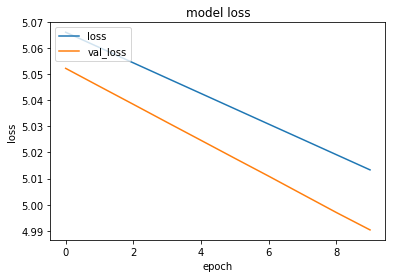

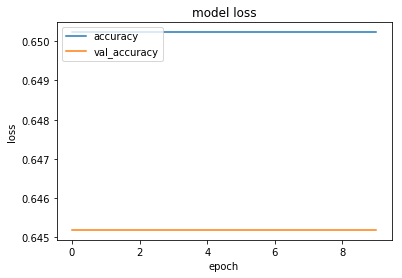

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.0659 - acc: 0.6502 - val_loss: 5.0521 - val_acc: 0.6452
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.0601 - acc: 0.6502 - val_loss: 5.0451 - val_acc: 0.6452
Epoch 3/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.0542 - acc: 0.6502 - val_loss: 5.0384 - val_acc: 0.6452
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0483 - acc: 0.6502 - val_loss: 5.0316 - val_acc: 0.6452
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.0425 - acc: 0.6502 - val_loss: 5.0245 - val_acc: 0.6452
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0367 - acc: 0.6502 - val_loss: 5.0178 - val_acc: 0.6452
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0309 - acc: 0.6502 - val_loss: 5.0111 - val_acc: 0.6452
Epoch 8

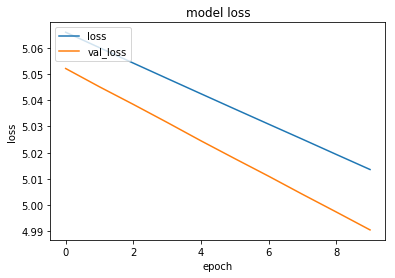

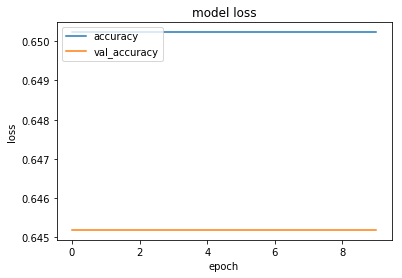

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0661 - acc: 0.6502 - val_loss: 5.0523 - val_acc: 0.6452
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0602 - acc: 0.6502 - val_loss: 5.0455 - val_acc: 0.6452
Epoch 3/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.0544 - acc: 0.6502 - val_loss: 5.0386 - val_acc: 0.6452
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0486 - acc: 0.6502 - val_loss: 5.0318 - val_acc: 0.6452
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0428 - acc: 0.6502 - val_loss: 5.0250 - val_acc: 0.6452
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0370 - acc: 0.6502 - val_loss: 5.0182 - val_acc: 0.6452
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.0312 - acc: 0.6502 - val_loss: 5.0113 - val_acc: 0.6452
Epoch 8

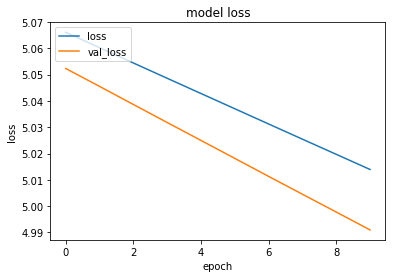

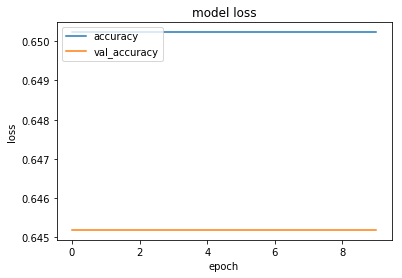

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 85us/step - loss: 5.0661 - acc: 0.6502 - val_loss: 5.0522 - val_acc: 0.6452
Epoch 2/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.0603 - acc: 0.6502 - val_loss: 5.0454 - val_acc: 0.6452
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.0545 - acc: 0.6502 - val_loss: 5.0386 - val_acc: 0.6452
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.0487 - acc: 0.6502 - val_loss: 5.0318 - val_acc: 0.6452
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.0428 - acc: 0.6502 - val_loss: 5.0250 - val_acc: 0.6452
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0370 - acc: 0.6502 - val_loss: 5.0182 - val_acc: 0.6452
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0312 - acc: 0.6502 - val_loss: 5.0114 - val_acc: 0.6452
Epoch 8

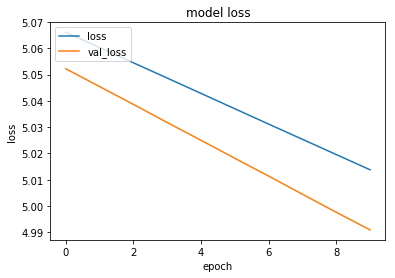

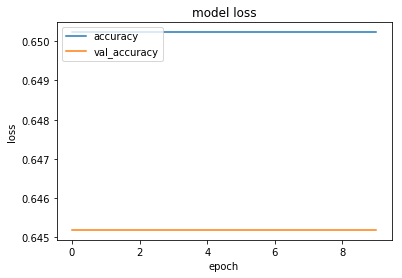

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.0660 - acc: 0.6502 - val_loss: 5.0521 - val_acc: 0.6452
Epoch 2/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.0601 - acc: 0.6502 - val_loss: 5.0454 - val_acc: 0.6452
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.0544 - acc: 0.6502 - val_loss: 5.0386 - val_acc: 0.6452
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0486 - acc: 0.6502 - val_loss: 5.0316 - val_acc: 0.6452
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0427 - acc: 0.6502 - val_loss: 5.0249 - val_acc: 0.6452
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0370 - acc: 0.6502 - val_loss: 5.0182 - val_acc: 0.6452
Epoch 7/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.0312 - acc: 0.6502 - val_loss: 5.0112 - val_acc: 0.6452
Epoch 8

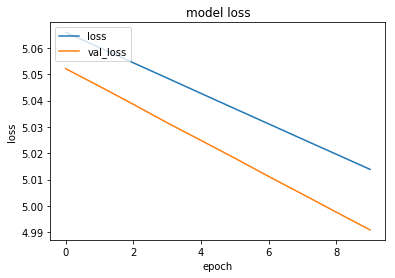

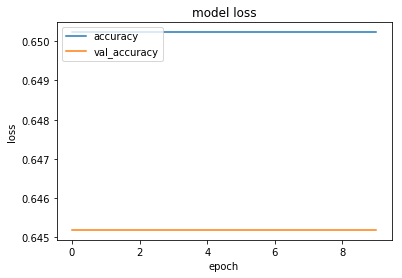

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.0661 - acc: 0.6502 - val_loss: 5.0524 - val_acc: 0.6452
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0603 - acc: 0.6502 - val_loss: 5.0456 - val_acc: 0.6452
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0545 - acc: 0.6502 - val_loss: 5.0386 - val_acc: 0.6452
Epoch 4/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.0486 - acc: 0.6502 - val_loss: 5.0318 - val_acc: 0.6452
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0428 - acc: 0.6502 - val_loss: 5.0251 - val_acc: 0.6452
Epoch 6/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.0370 - acc: 0.6502 - val_loss: 5.0183 - val_acc: 0.6452
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.0312 - acc: 0.6502 - val_loss: 5.0112 - val_acc: 0.6452
Epoch 8

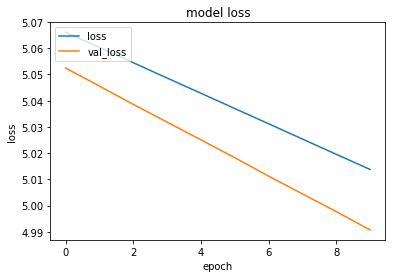

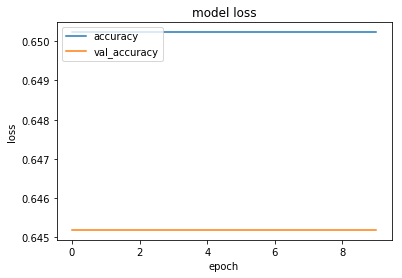

ES STEPS: 1 BEST SCORE: 0.6502 
ES STEPS: 2 BEST SCORE: 0.6502 
ES STEPS: 3 BEST SCORE: 0.6502 
ES STEPS: 4 BEST SCORE: 0.6502 
ES STEPS: 5 BEST SCORE: 0.6502 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5741 - acc: 0.6485 - val_loss: 5.5087 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5741 - acc: 0.6485 - val_loss: 5.5086 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5740 - acc: 0.6485 - val_loss: 5.5086 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5740 - acc: 0.6485 - val_loss: 5.5086 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5740 - acc: 0.6485 - val_loss: 5.5085 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5739 - acc: 0.64

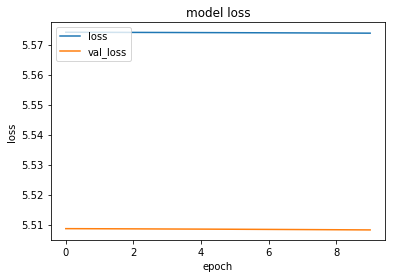

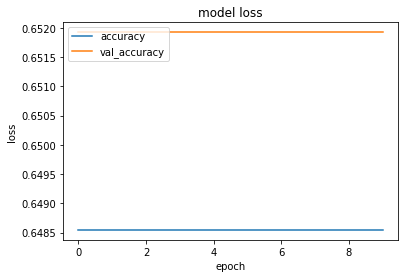

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5737 - acc: 0.6485 - val_loss: 5.5082 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5737 - acc: 0.6485 - val_loss: 5.5081 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5736 - acc: 0.6485 - val_loss: 5.5080 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5736 - acc: 0.6485 - val_loss: 5.5080 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5735 - acc: 0.6485 - val_loss: 5.5079 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5735 - acc: 0.6485 - val_loss: 5.5078 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5734 - acc: 0.6485 - val_loss: 5.5077 - val_acc: 0.6519
Epoch 8

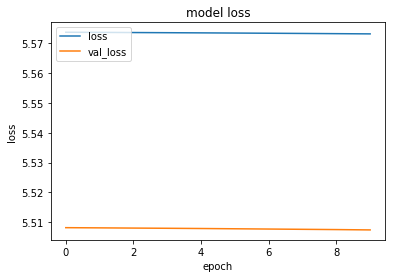

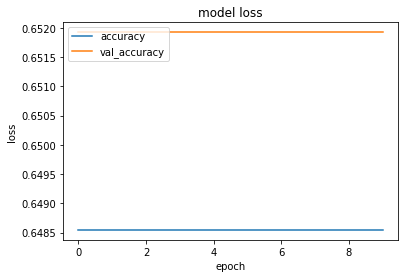

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5737 - acc: 0.6485 - val_loss: 5.5081 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5736 - acc: 0.6485 - val_loss: 5.5080 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.5736 - acc: 0.6485 - val_loss: 5.5079 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.5735 - acc: 0.6485 - val_loss: 5.5078 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.5734 - acc: 0.6485 - val_loss: 5.5077 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.5733 - acc: 0.6485 - val_loss: 5.5075 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5732 - acc: 0.6485 - val_loss: 5.5074 - val_acc: 0.6519
Epoch 8

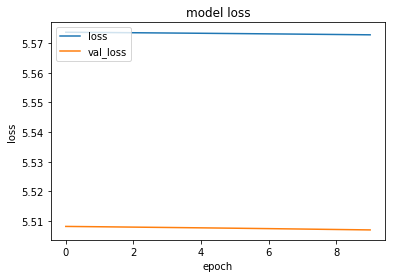

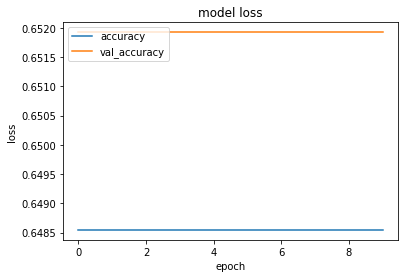

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5737 - acc: 0.6485 - val_loss: 5.5081 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5736 - acc: 0.6485 - val_loss: 5.5079 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5735 - acc: 0.6485 - val_loss: 5.5078 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5733 - acc: 0.6485 - val_loss: 5.5076 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5732 - acc: 0.6485 - val_loss: 5.5074 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5731 - acc: 0.6485 - val_loss: 5.5073 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5730 - acc: 0.6485 - val_loss: 5.5071 - val_acc: 0.6519
Epoch 8

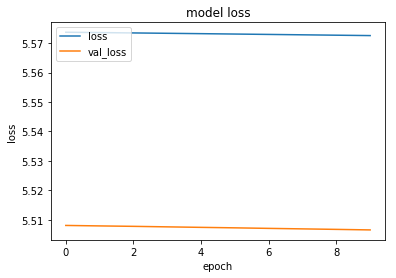

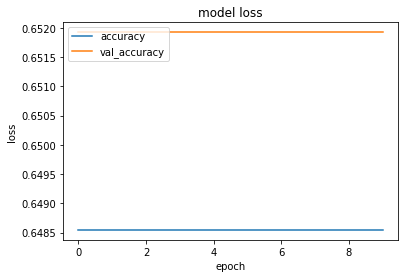

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5737 - acc: 0.6485 - val_loss: 5.5081 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5736 - acc: 0.6485 - val_loss: 5.5079 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5734 - acc: 0.6485 - val_loss: 5.5077 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.5733 - acc: 0.6485 - val_loss: 5.5075 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5731 - acc: 0.6485 - val_loss: 5.5073 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5730 - acc: 0.6485 - val_loss: 5.5071 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5729 - acc: 0.6485 - val_loss: 5.5070 - val_acc: 0.6519
Epoch 8

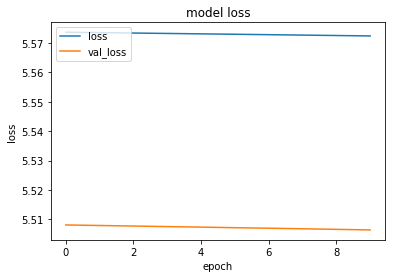

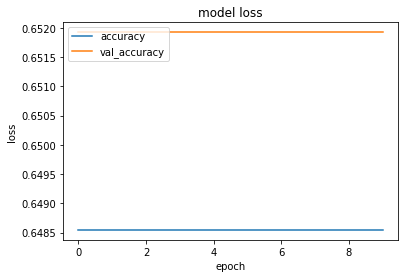

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.5737 - acc: 0.6485 - val_loss: 5.5080 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5735 - acc: 0.6485 - val_loss: 5.5079 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5734 - acc: 0.6485 - val_loss: 5.5077 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5733 - acc: 0.6485 - val_loss: 5.5075 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5731 - acc: 0.6485 - val_loss: 5.5073 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5730 - acc: 0.6485 - val_loss: 5.5071 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5728 - acc: 0.6485 - val_loss: 5.5069 - val_acc: 0.6519
Epoch 8

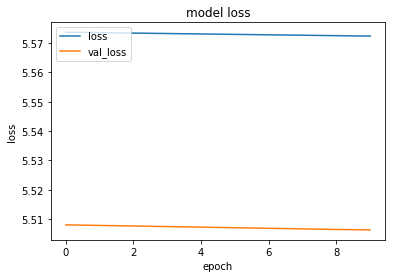

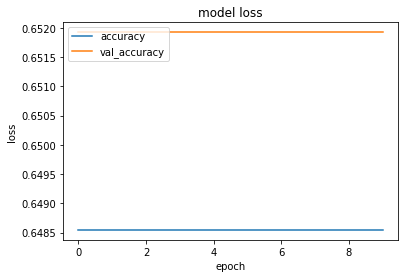

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5737 - acc: 0.6485 - val_loss: 5.5080 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5735 - acc: 0.6485 - val_loss: 5.5078 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5734 - acc: 0.6485 - val_loss: 5.5076 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5732 - acc: 0.6485 - val_loss: 5.5075 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5731 - acc: 0.6485 - val_loss: 5.5072 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5729 - acc: 0.6485 - val_loss: 5.5071 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5728 - acc: 0.6485 - val_loss: 5.5069 - val_acc: 0.6519
Epoch 8

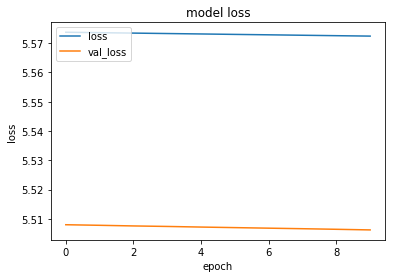

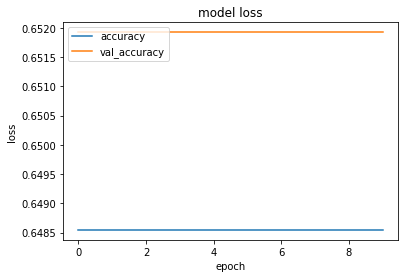

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 87us/step - loss: 5.5737 - acc: 0.6485 - val_loss: 5.5080 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 86us/step - loss: 5.5735 - acc: 0.6485 - val_loss: 5.5079 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.5734 - acc: 0.6485 - val_loss: 5.5077 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5733 - acc: 0.6485 - val_loss: 5.5075 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.5731 - acc: 0.6485 - val_loss: 5.5073 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5730 - acc: 0.6485 - val_loss: 5.5071 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 85us/step - loss: 5.5728 - acc: 0.6485 - val_loss: 5.5069 - val_acc: 0.6519
Epoch 8

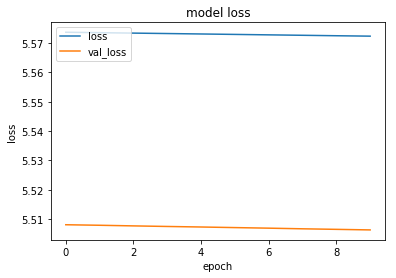

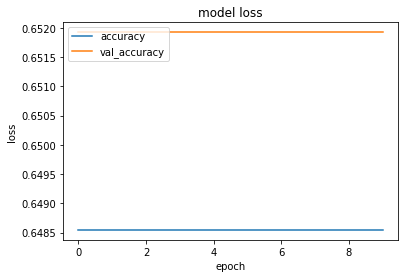

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5737 - acc: 0.6485 - val_loss: 5.5080 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5735 - acc: 0.6485 - val_loss: 5.5078 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5734 - acc: 0.6485 - val_loss: 5.5077 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.5732 - acc: 0.6485 - val_loss: 5.5075 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5731 - acc: 0.6485 - val_loss: 5.5072 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5729 - acc: 0.6485 - val_loss: 5.5071 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5728 - acc: 0.6485 - val_loss: 5.5069 - val_acc: 0.6519
Epoch 8

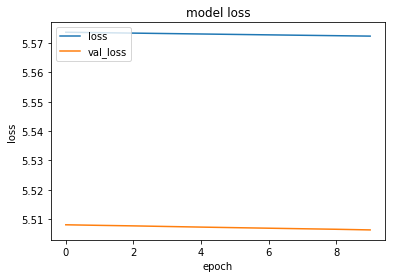

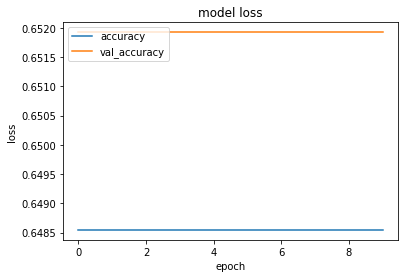

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5737 - acc: 0.6485 - val_loss: 5.5080 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5735 - acc: 0.6485 - val_loss: 5.5078 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5734 - acc: 0.6485 - val_loss: 5.5076 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5732 - acc: 0.6485 - val_loss: 5.5075 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5731 - acc: 0.6485 - val_loss: 5.5073 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5730 - acc: 0.6485 - val_loss: 5.5071 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5728 - acc: 0.6485 - val_loss: 5.5069 - val_acc: 0.6519
Epoch 8

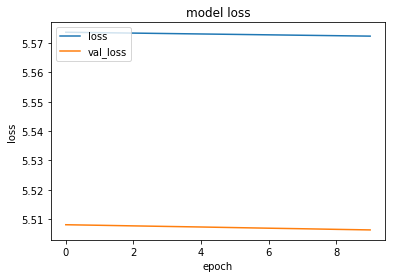

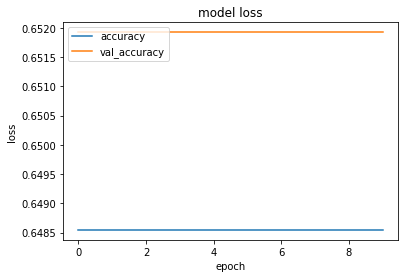

ES STEPS: 1 BEST SCORE: 0.6512 
ES STEPS: 2 BEST SCORE: 0.6512 
ES STEPS: 3 BEST SCORE: 0.6512 
ES STEPS: 4 BEST SCORE: 0.6512 
ES STEPS: 5 BEST SCORE: 0.6512 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5850 - acc: 0.6481 - val_loss: 5.5215 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5847 - acc: 0.6481 - val_loss: 5.5211 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5843 - acc: 0.6481 - val_loss: 5.5208 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5840 - acc: 0.6481 - val_loss: 5.5205 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5837 - acc: 0.6481 - val_loss: 5.5201 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5834 - acc: 0.64

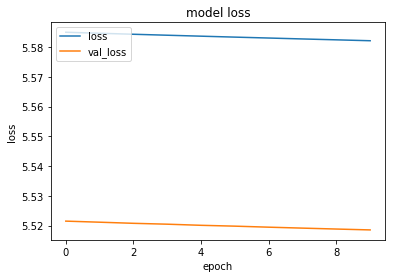

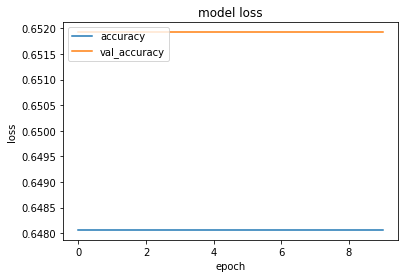

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5819 - acc: 0.6481 - val_loss: 5.5182 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.5816 - acc: 0.6481 - val_loss: 5.5179 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.5813 - acc: 0.6481 - val_loss: 5.5176 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.5810 - acc: 0.6481 - val_loss: 5.5173 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.5807 - acc: 0.6481 - val_loss: 5.5170 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5804 - acc: 0.6481 - val_loss: 5.5167 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.5801 - acc: 0.6481 - val_loss: 5.5164 - val_acc: 0.6519
Epoch 8

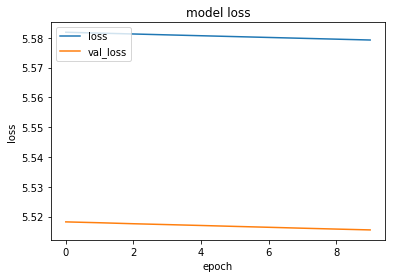

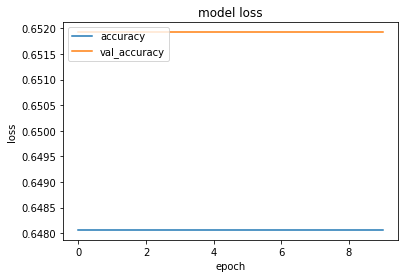

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5819 - acc: 0.6481 - val_loss: 5.5182 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5816 - acc: 0.6481 - val_loss: 5.5179 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5813 - acc: 0.6481 - val_loss: 5.5177 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5810 - acc: 0.6481 - val_loss: 5.5173 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5807 - acc: 0.6481 - val_loss: 5.5170 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5804 - acc: 0.6481 - val_loss: 5.5168 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5802 - acc: 0.6481 - val_loss: 5.5164 - val_acc: 0.6519
Epoch 8

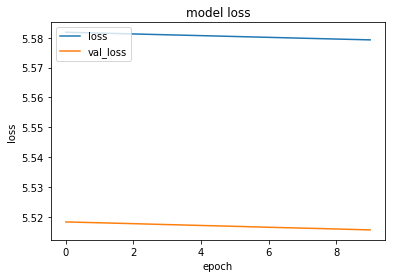

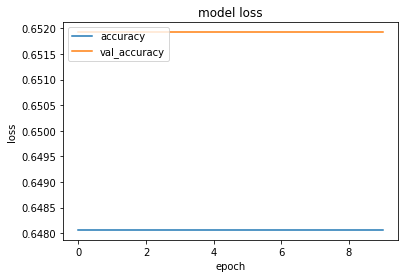

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5819 - acc: 0.6481 - val_loss: 5.5183 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5816 - acc: 0.6481 - val_loss: 5.5180 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5813 - acc: 0.6481 - val_loss: 5.5177 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5811 - acc: 0.6481 - val_loss: 5.5174 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5808 - acc: 0.6481 - val_loss: 5.5171 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5805 - acc: 0.6481 - val_loss: 5.5168 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5802 - acc: 0.6481 - val_loss: 5.5165 - val_acc: 0.6519
Epoch 8

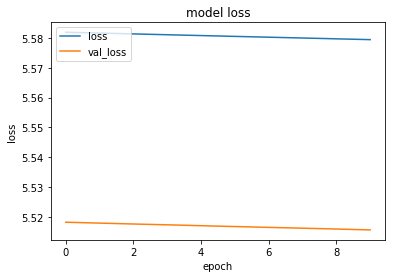

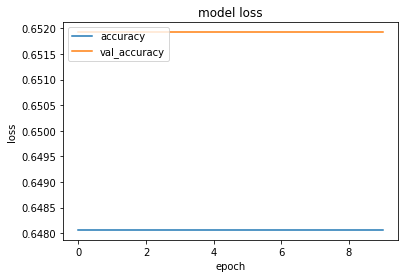

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5819 - acc: 0.6481 - val_loss: 5.5183 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5816 - acc: 0.6481 - val_loss: 5.5180 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5813 - acc: 0.6481 - val_loss: 5.5177 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5811 - acc: 0.6481 - val_loss: 5.5174 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5808 - acc: 0.6481 - val_loss: 5.5171 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5805 - acc: 0.6481 - val_loss: 5.5168 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5802 - acc: 0.6481 - val_loss: 5.5165 - val_acc: 0.6519
Epoch 8

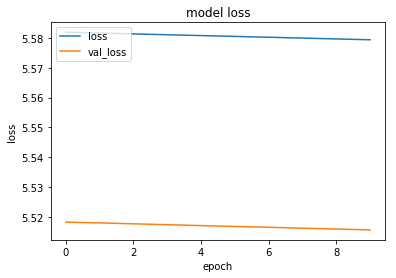

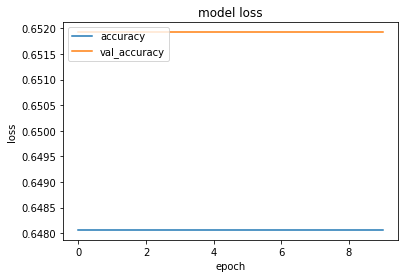

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.5819 - acc: 0.6481 - val_loss: 5.5182 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.5816 - acc: 0.6481 - val_loss: 5.5179 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5813 - acc: 0.6481 - val_loss: 5.5177 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5810 - acc: 0.6481 - val_loss: 5.5173 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5807 - acc: 0.6481 - val_loss: 5.5171 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5805 - acc: 0.6481 - val_loss: 5.5168 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5802 - acc: 0.6481 - val_loss: 5.5165 - val_acc: 0.6519
Epoch 8

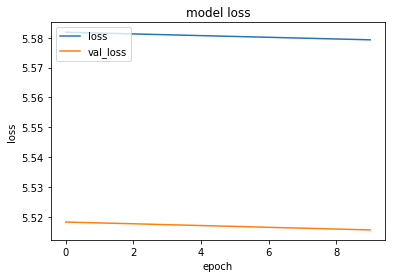

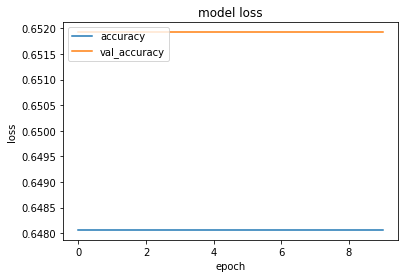

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.5819 - acc: 0.6481 - val_loss: 5.5182 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.5816 - acc: 0.6481 - val_loss: 5.5179 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5813 - acc: 0.6481 - val_loss: 5.5177 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5810 - acc: 0.6481 - val_loss: 5.5174 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5808 - acc: 0.6481 - val_loss: 5.5171 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5805 - acc: 0.6481 - val_loss: 5.5168 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5802 - acc: 0.6481 - val_loss: 5.5165 - val_acc: 0.6519
Epoch 8

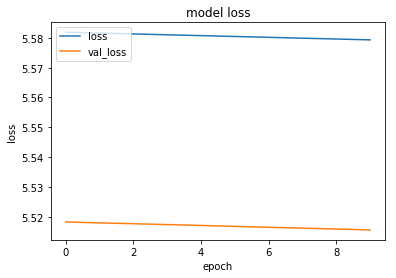

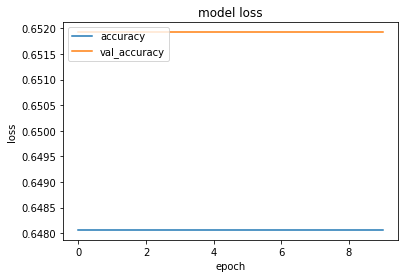

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5819 - acc: 0.6481 - val_loss: 5.5183 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5816 - acc: 0.6481 - val_loss: 5.5180 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5813 - acc: 0.6481 - val_loss: 5.5177 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5810 - acc: 0.6481 - val_loss: 5.5174 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5808 - acc: 0.6481 - val_loss: 5.5171 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5805 - acc: 0.6481 - val_loss: 5.5168 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5802 - acc: 0.6481 - val_loss: 5.5165 - val_acc: 0.6519
Epoch 8

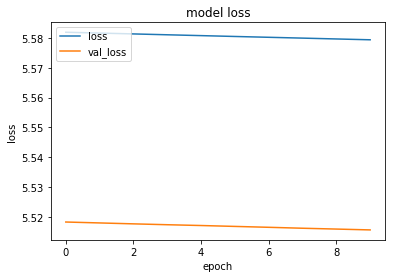

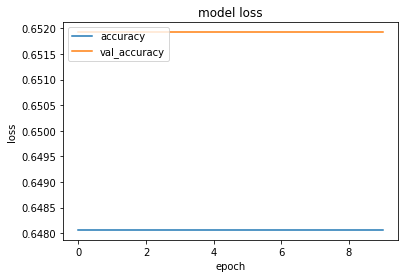

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5819 - acc: 0.6481 - val_loss: 5.5183 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5816 - acc: 0.6481 - val_loss: 5.5180 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5813 - acc: 0.6481 - val_loss: 5.5177 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5810 - acc: 0.6481 - val_loss: 5.5174 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5808 - acc: 0.6481 - val_loss: 5.5171 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5805 - acc: 0.6481 - val_loss: 5.5168 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5802 - acc: 0.6481 - val_loss: 5.5165 - val_acc: 0.6519
Epoch 8

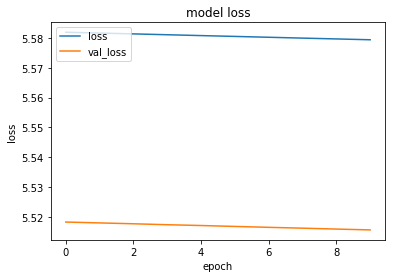

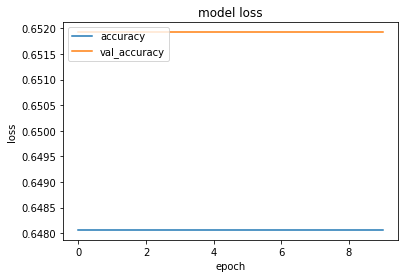

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5819 - acc: 0.6481 - val_loss: 5.5182 - val_acc: 0.6519
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5816 - acc: 0.6481 - val_loss: 5.5180 - val_acc: 0.6519
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5813 - acc: 0.6481 - val_loss: 5.5177 - val_acc: 0.6519
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5811 - acc: 0.6481 - val_loss: 5.5174 - val_acc: 0.6519
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5808 - acc: 0.6481 - val_loss: 5.5171 - val_acc: 0.6519
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5805 - acc: 0.6481 - val_loss: 5.5168 - val_acc: 0.6519
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5802 - acc: 0.6481 - val_loss: 5.5165 - val_acc: 0.6519
Epoch 8

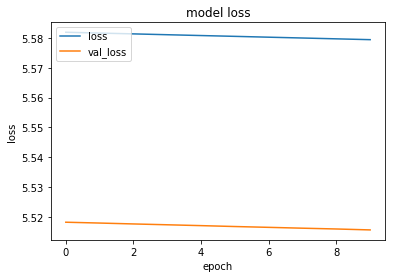

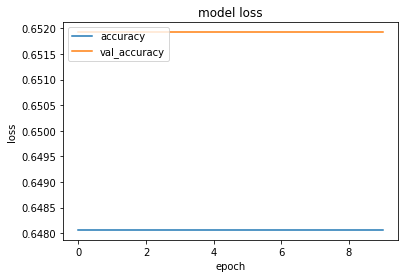

ES STEPS: 1 BEST SCORE: 0.6481 
ES STEPS: 2 BEST SCORE: 0.6485 
ES STEPS: 3 BEST SCORE: 0.6490 
ES STEPS: 4 BEST SCORE: 0.6497 
ES STEPS: 5 BEST SCORE: 0.6505 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 3/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 4/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


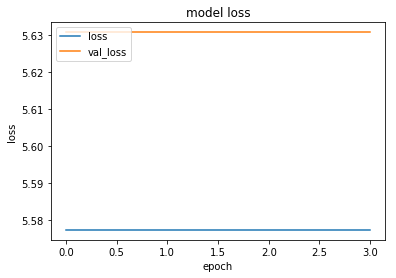

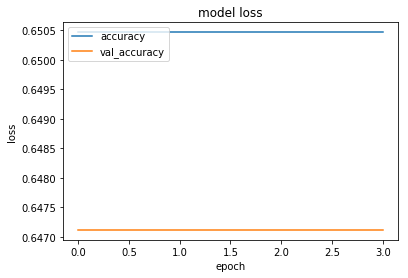

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


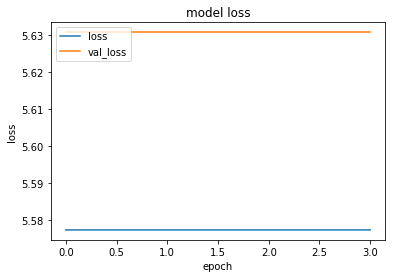

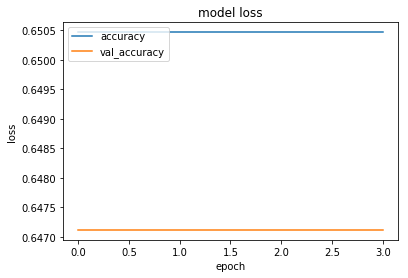

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


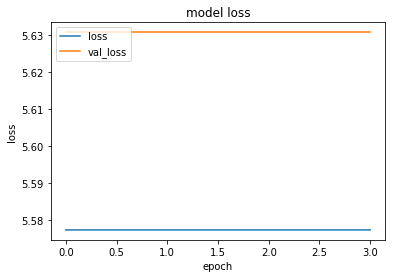

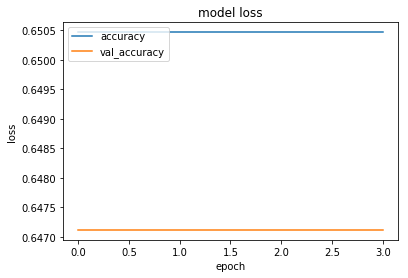

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


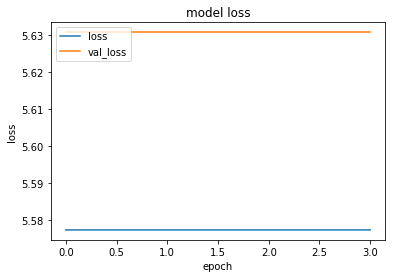

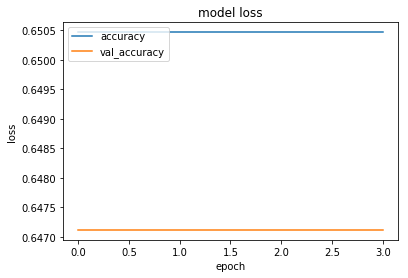

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


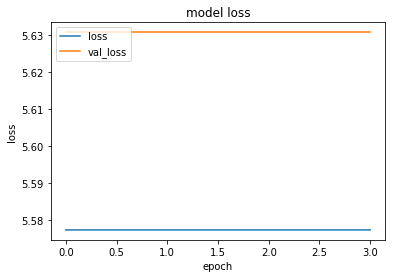

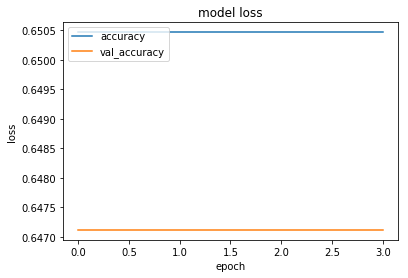

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


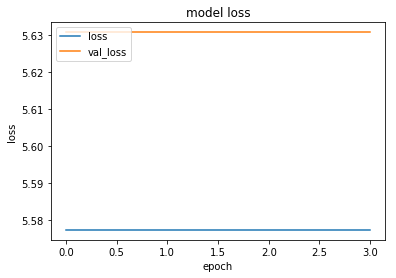

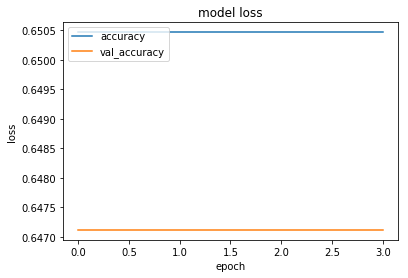

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


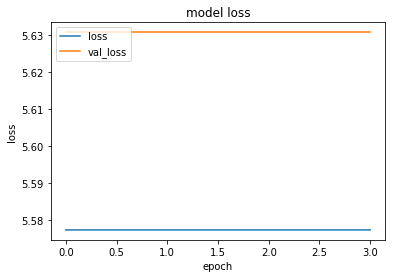

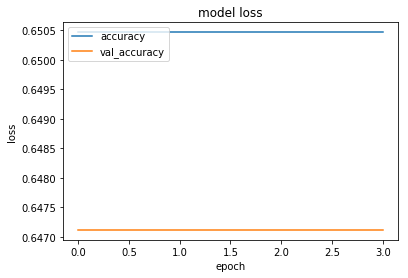

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


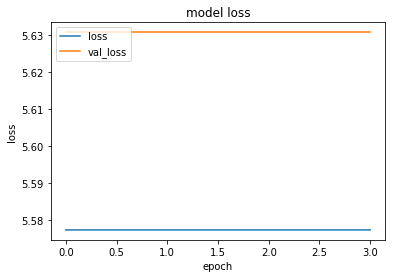

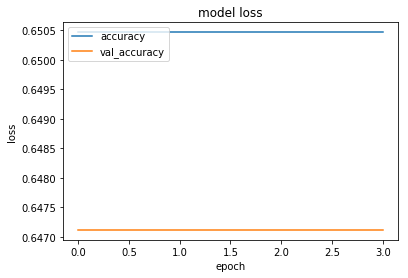

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


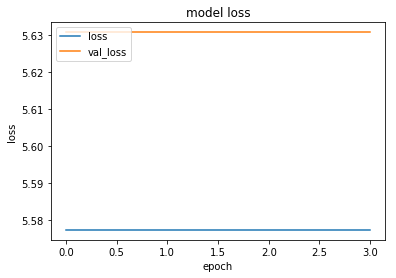

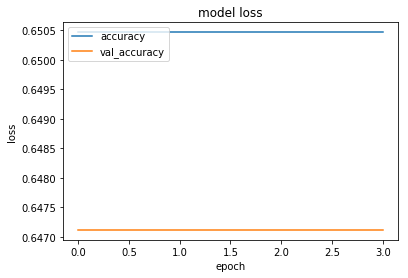

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5773 - acc: 0.6505 - val_loss: 5.6307 - val_acc: 0.6471
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


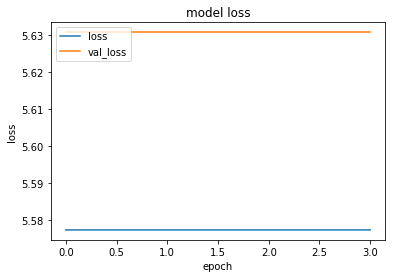

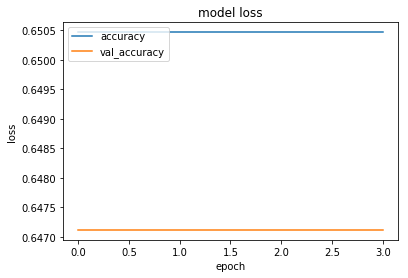

ES STEPS: 1 BEST SCORE: 0.6514 
ES STEPS: 2 BEST SCORE: 0.6514 
ES STEPS: 3 BEST SCORE: 0.6531 
ES STEPS: 4 BEST SCORE: 0.6534 
ES STEPS: 5 BEST SCORE: 0.6534 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


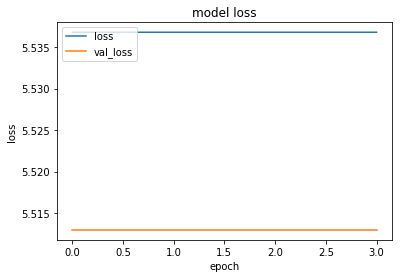

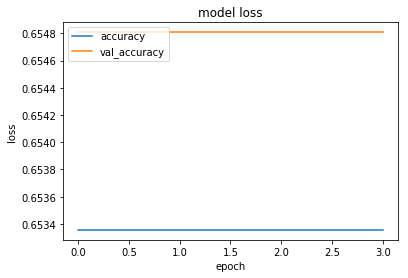

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


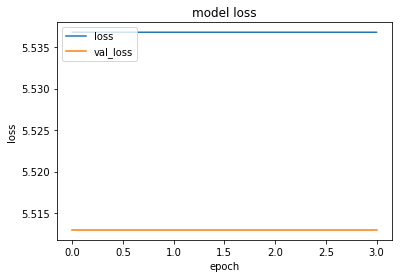

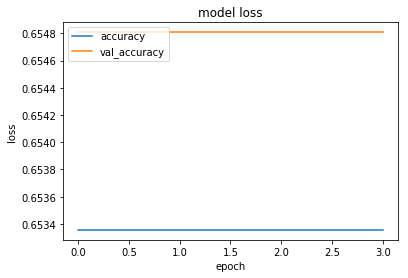

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


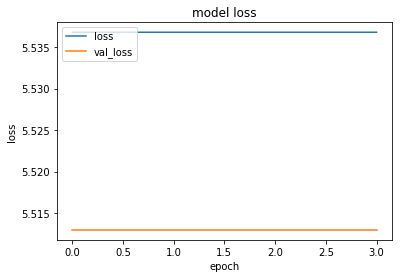

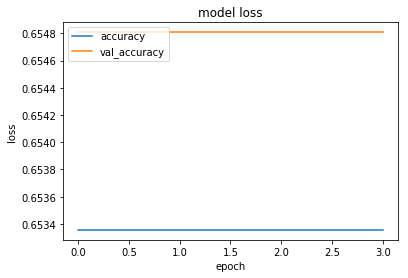

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


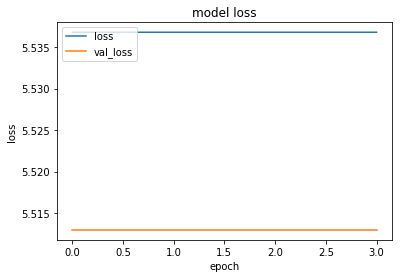

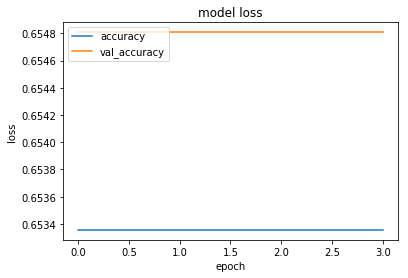

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


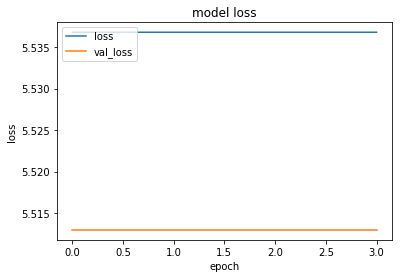

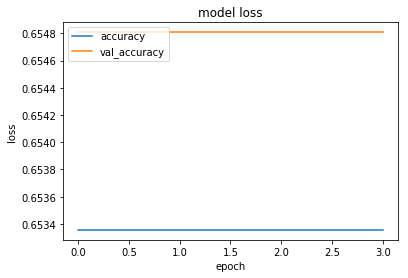

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


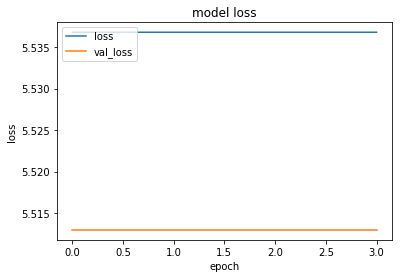

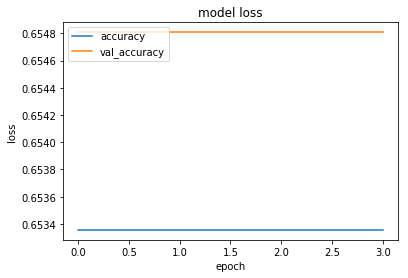

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


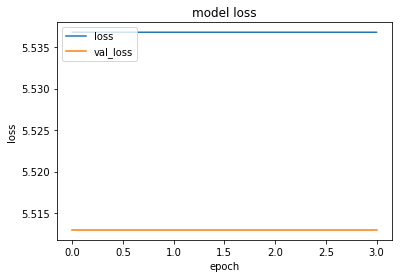

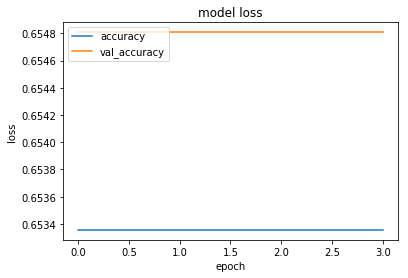

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


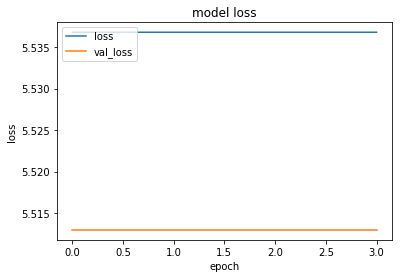

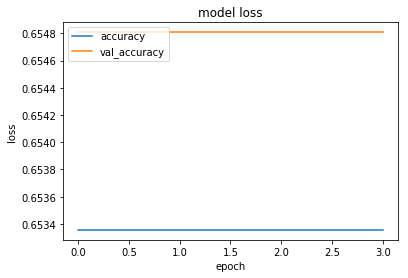

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


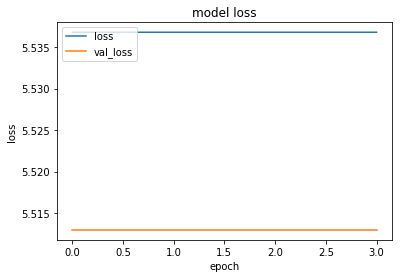

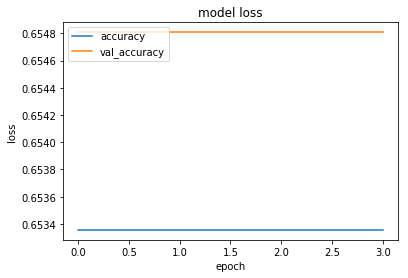

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5368 - acc: 0.6534 - val_loss: 5.5130 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


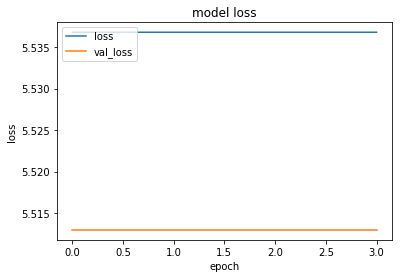

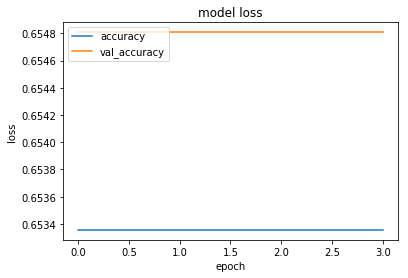

ES STEPS: 1 BEST SCORE: 0.6534 
ES STEPS: 2 BEST SCORE: 0.6541 
ES STEPS: 3 BEST SCORE: 0.6541 
ES STEPS: 4 BEST SCORE: 0.6541 
ES STEPS: 5 BEST SCORE: 0.6541 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5706 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 2/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.5706 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 3/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 4/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


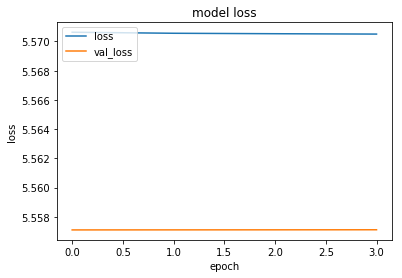

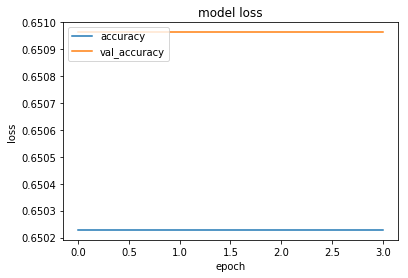

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.5706 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


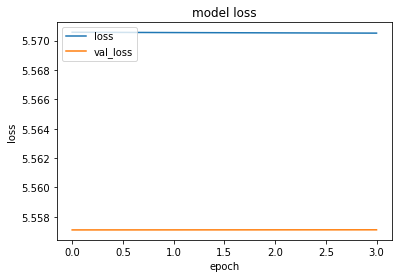

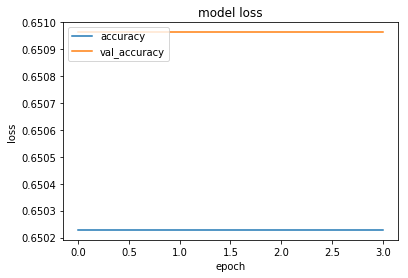

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5706 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 2/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


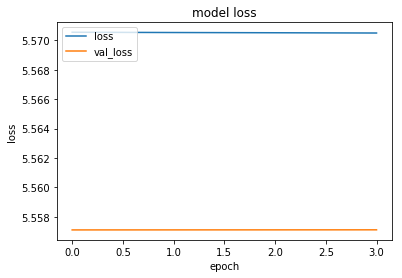

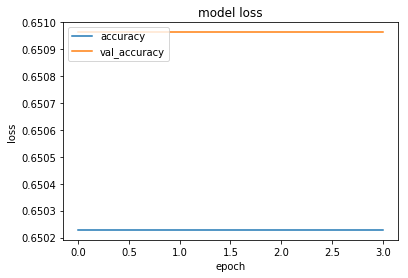

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5706 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 4/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


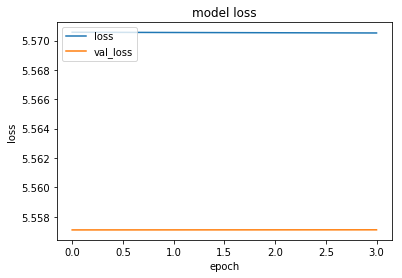

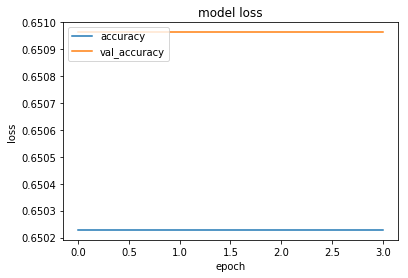

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5706 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 2/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


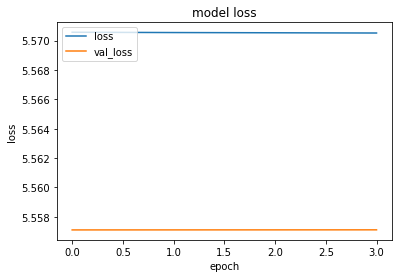

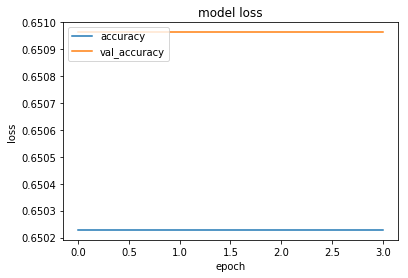

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5706 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5706 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


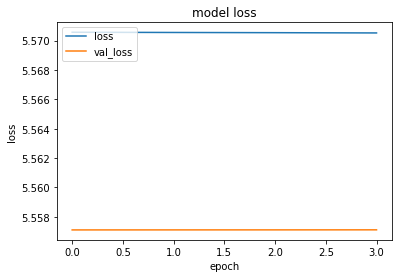

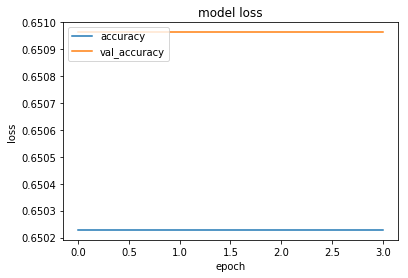

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5706 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


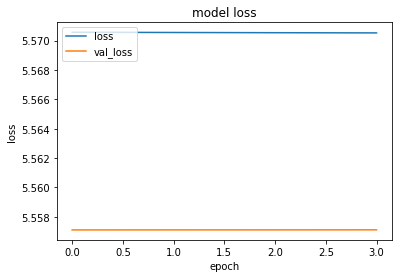

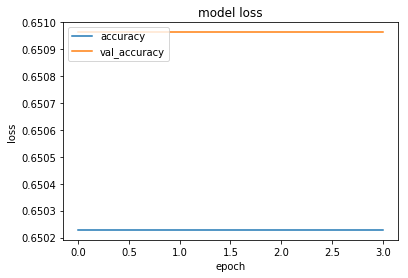

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5706 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


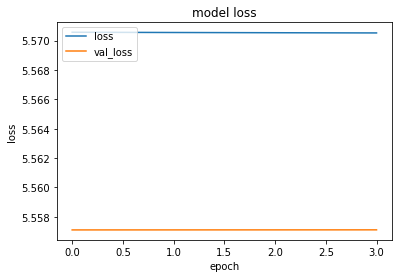

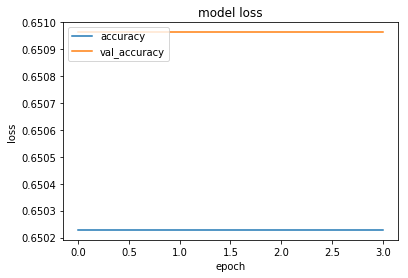

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5706 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


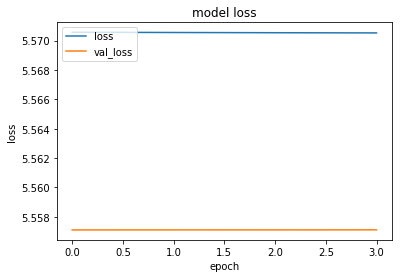

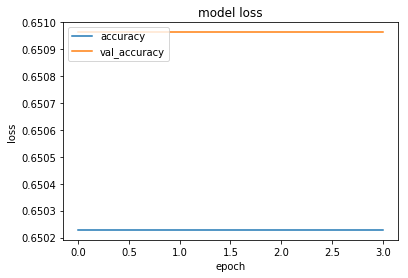

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5706 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5706 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5705 - acc: 0.6502 - val_loss: 5.5571 - val_acc: 0.6510
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


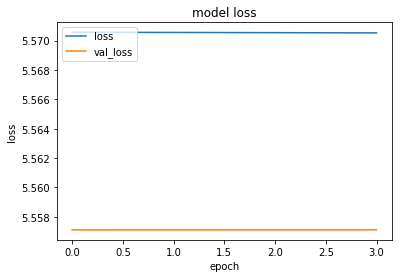

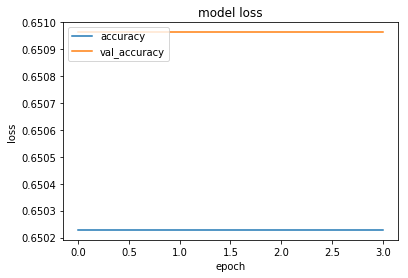

ES STEPS: 1 BEST SCORE: 0.6529 
ES STEPS: 2 BEST SCORE: 0.6529 
ES STEPS: 3 BEST SCORE: 0.6558 
ES STEPS: 4 BEST SCORE: 0.6558 
ES STEPS: 5 BEST SCORE: 0.6558 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 85us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 2/10
4157/4157 [==============================] - 0s 89us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 3/10
4157/4157 [==============================] - 0s 90us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 4/10
4157/4157 [==============================] - 0s 87us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


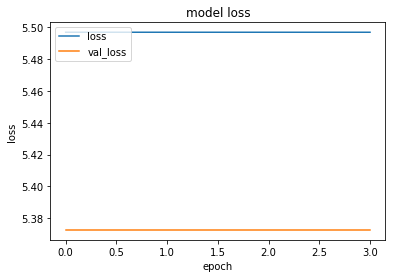

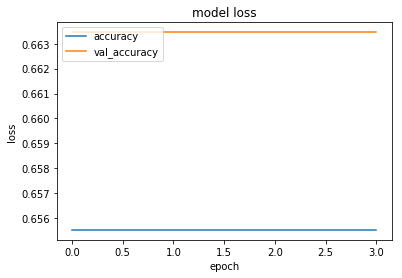

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


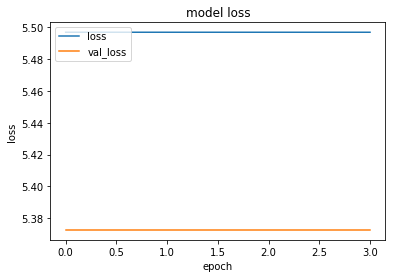

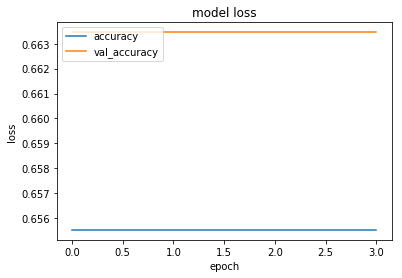

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 4/10
4157/4157 [==============================] - 0s 85us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


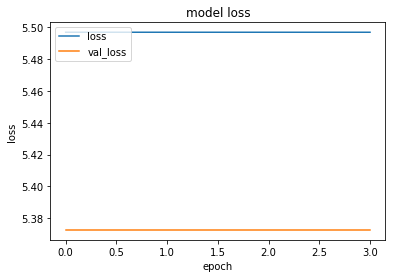

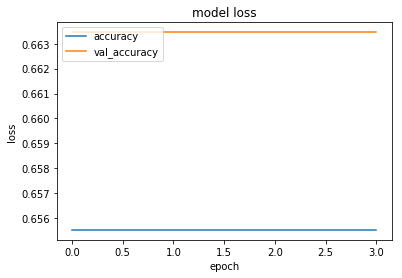

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 96us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 2/10
4157/4157 [==============================] - 0s 91us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 3/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 4/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


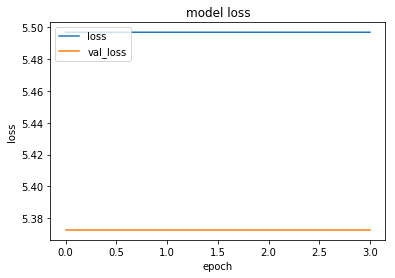

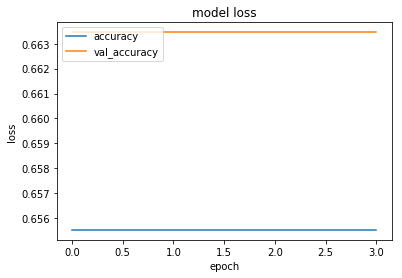

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 2/10
4157/4157 [==============================] - 0s 90us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


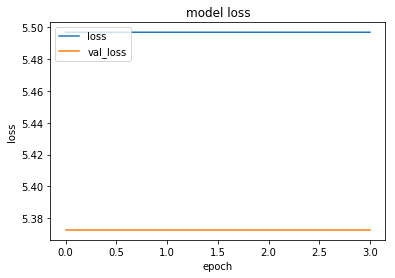

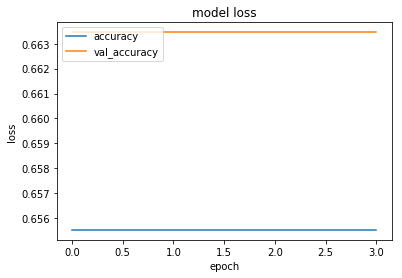

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


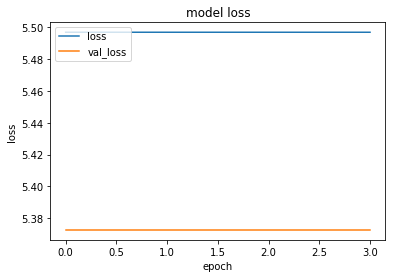

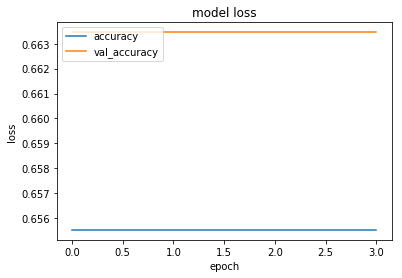

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 2/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


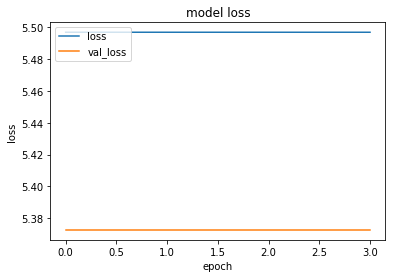

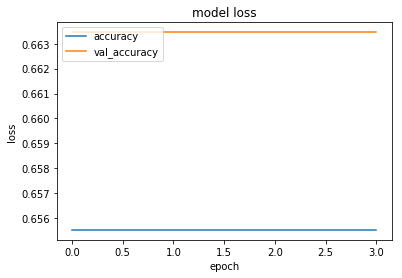

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


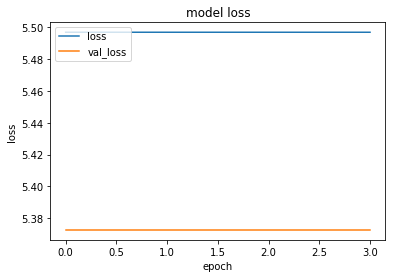

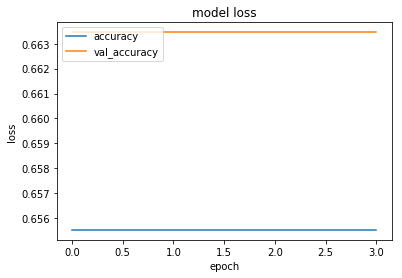

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


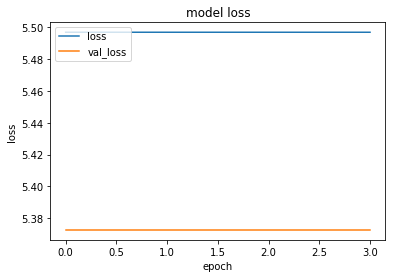

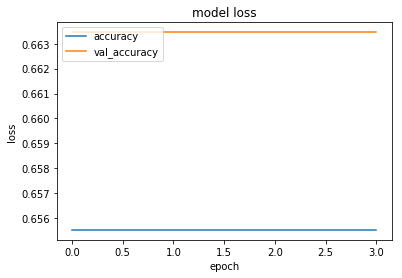

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4969 - acc: 0.6555 - val_loss: 5.3727 - val_acc: 0.6635
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


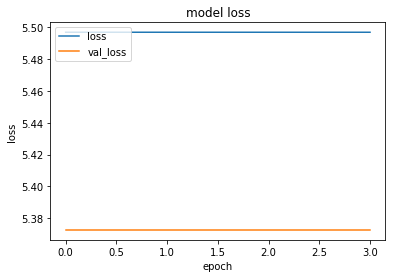

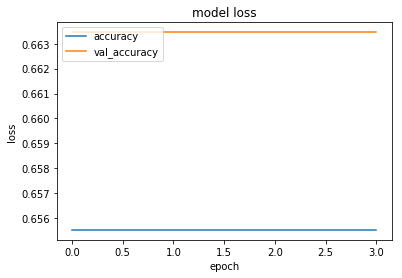

ES STEPS: 1 BEST SCORE: 0.6639 
ES STEPS: 2 BEST SCORE: 0.6639 
ES STEPS: 3 BEST SCORE: 0.6639 
ES STEPS: 4 BEST SCORE: 0.6639 
ES STEPS: 5 BEST SCORE: 0.6639 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 84us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 84us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


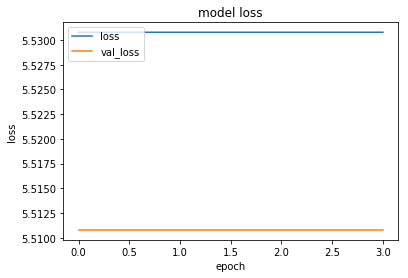

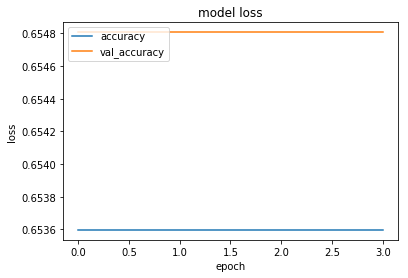

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


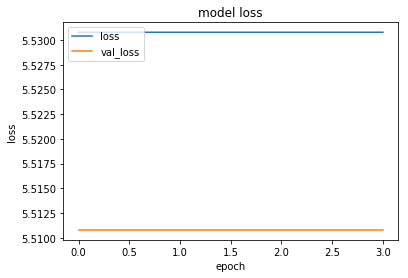

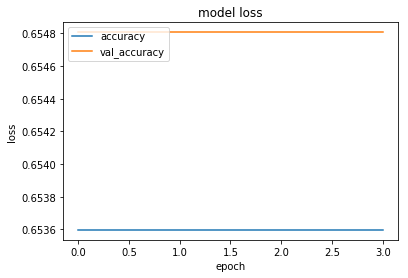

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


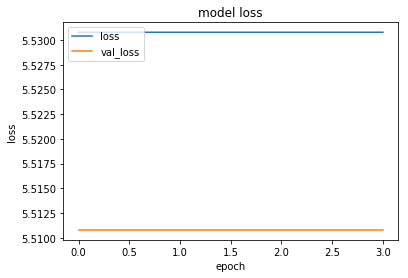

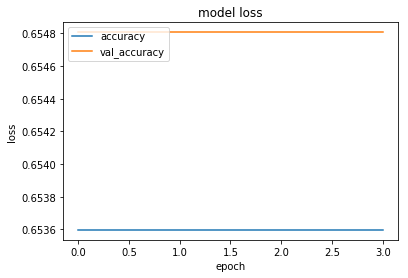

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


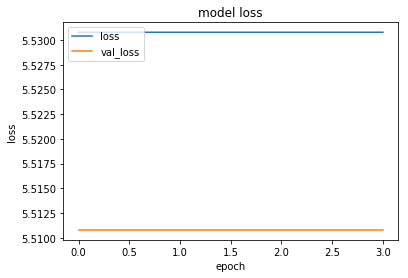

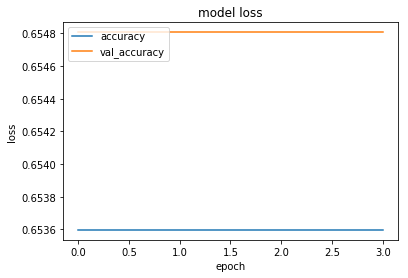

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


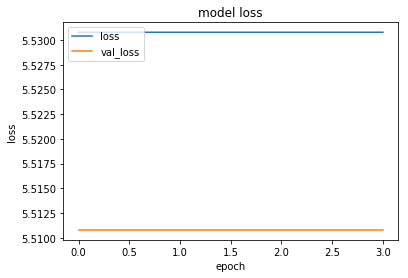

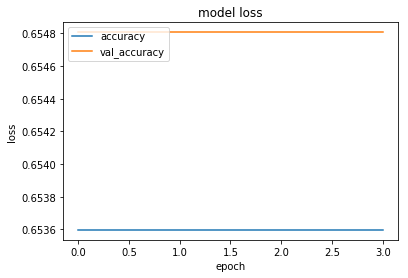

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


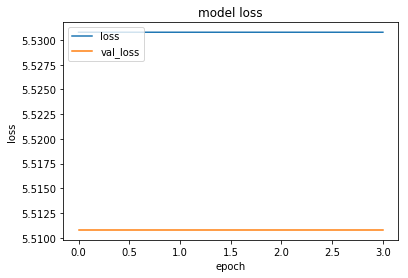

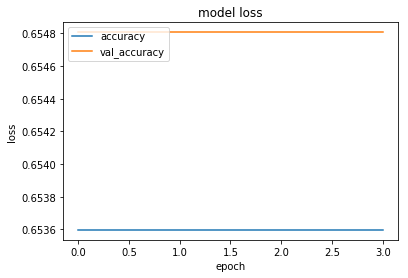

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


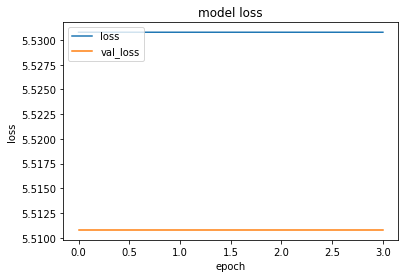

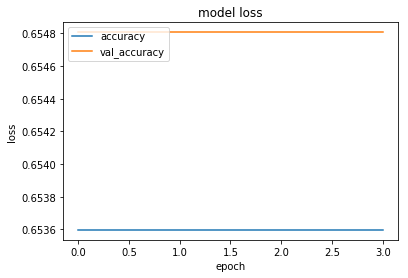

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


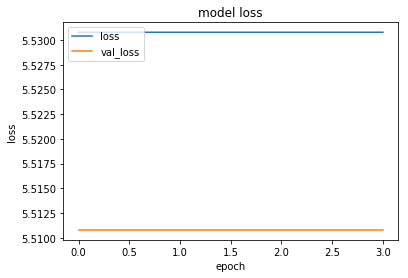

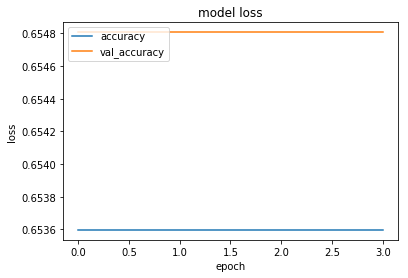

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


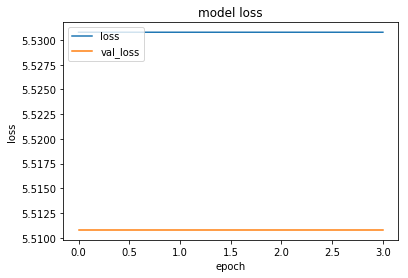

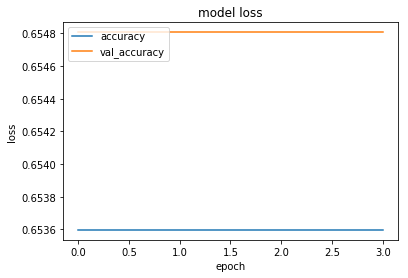

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.5308 - acc: 0.6536 - val_loss: 5.5108 - val_acc: 0.6548
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


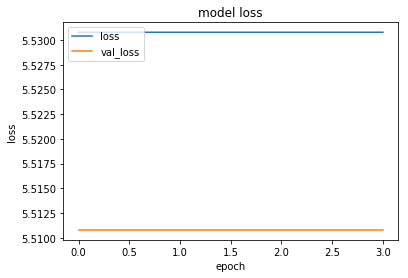

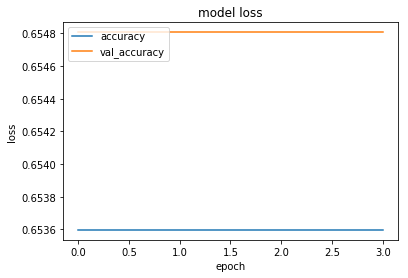

ES STEPS: 1 BEST SCORE: 0.6543 
ES STEPS: 2 BEST SCORE: 0.6632 
ES STEPS: 3 BEST SCORE: 0.6632 
ES STEPS: 4 BEST SCORE: 0.6632 
ES STEPS: 5 BEST SCORE: 0.6632 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


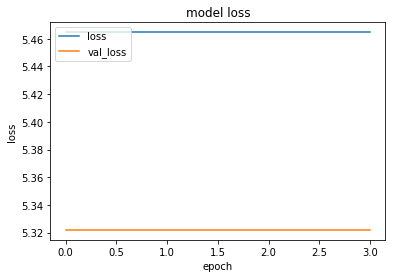

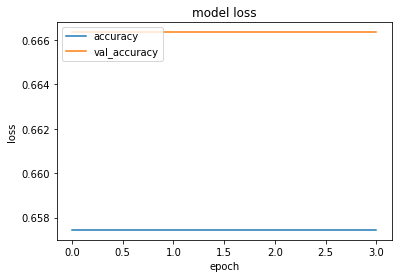

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


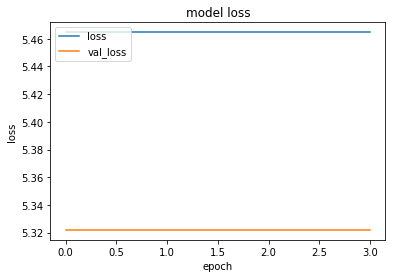

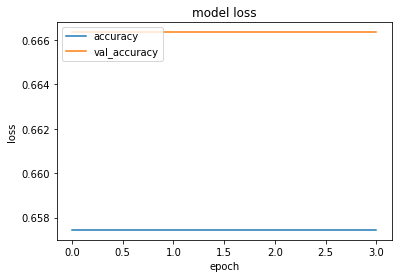

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


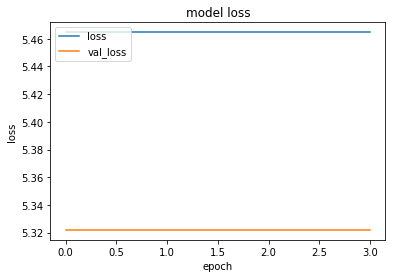

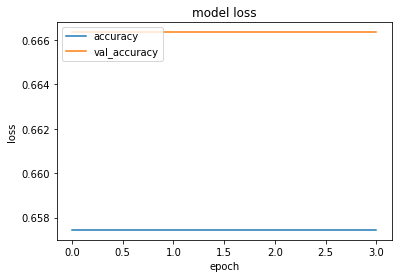

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 85us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


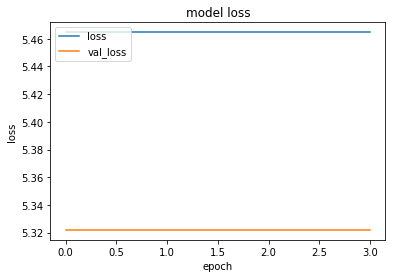

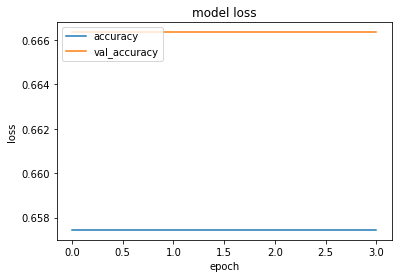

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 84us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


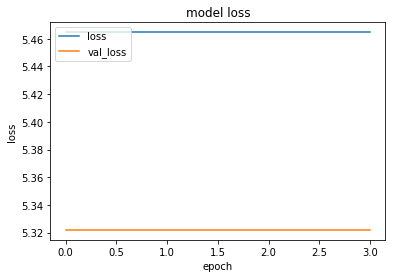

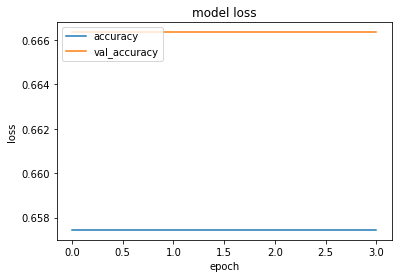

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


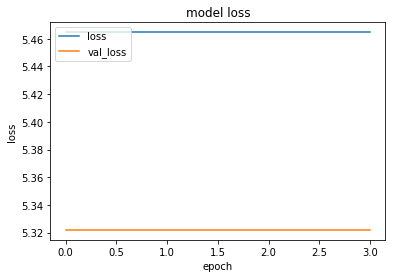

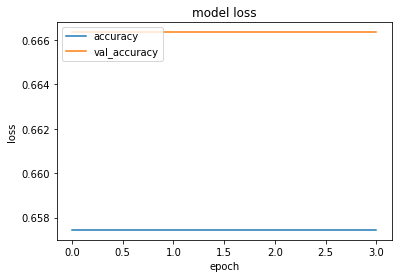

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


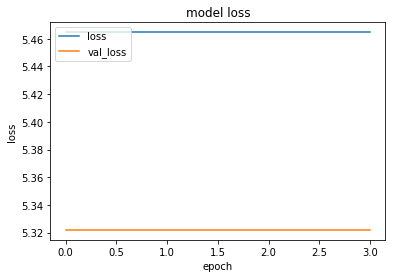

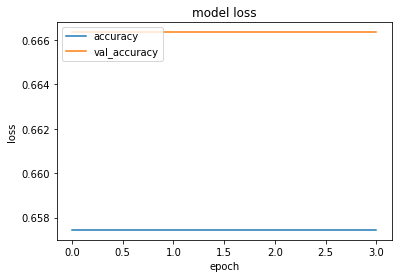

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


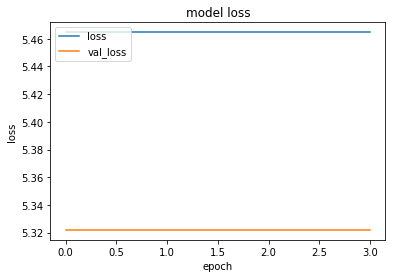

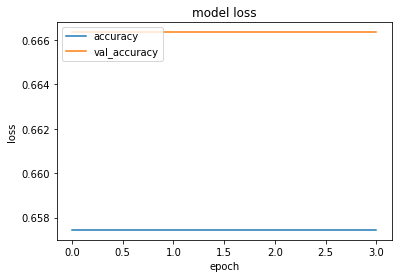

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


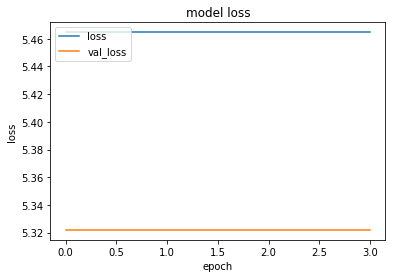

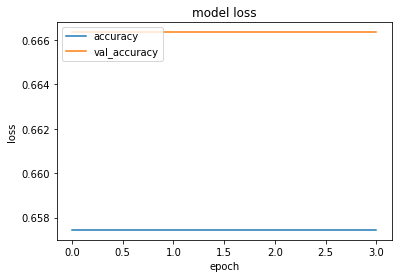

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4647 - acc: 0.6574 - val_loss: 5.3219 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


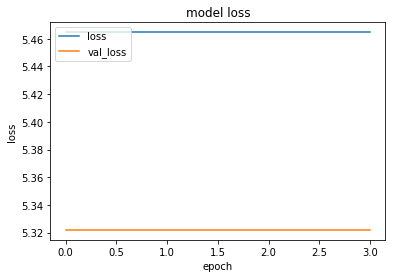

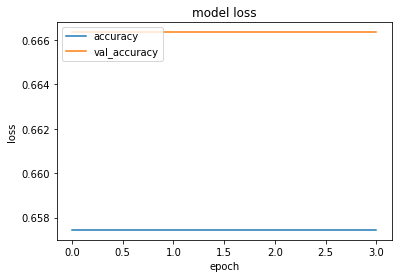

ES STEPS: 1 BEST SCORE: 0.6574 
ES STEPS: 2 BEST SCORE: 0.6611 
ES STEPS: 3 BEST SCORE: 0.6635 
ES STEPS: 4 BEST SCORE: 0.6635 
ES STEPS: 5 BEST SCORE: 0.6635 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


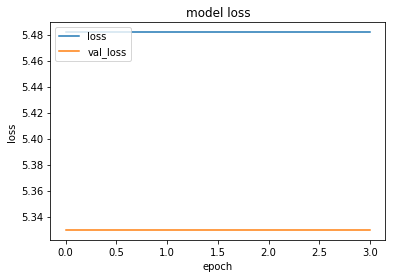

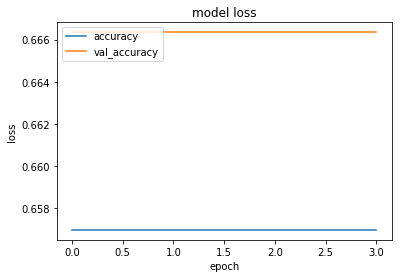

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


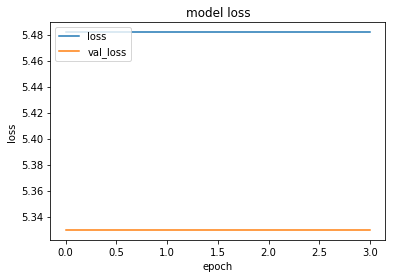

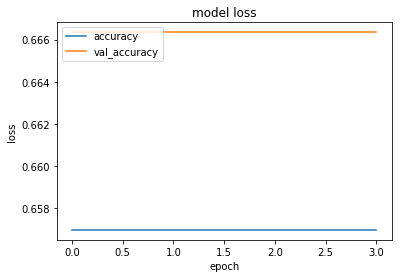

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


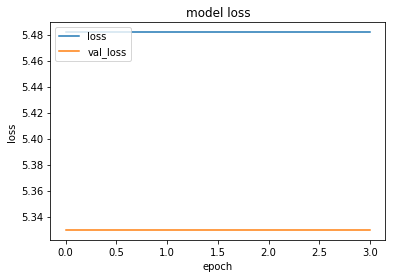

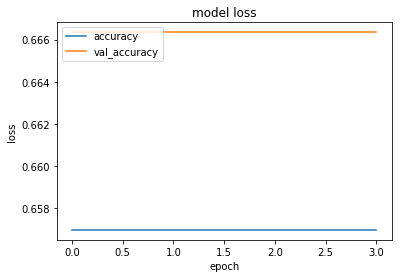

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


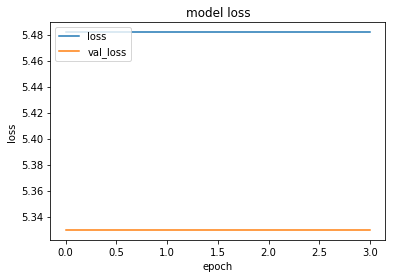

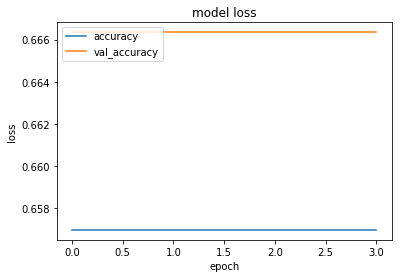

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


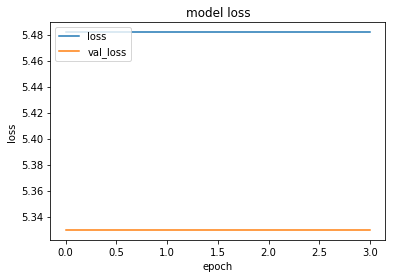

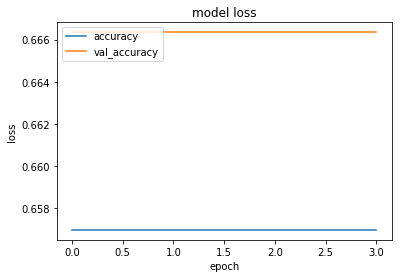

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


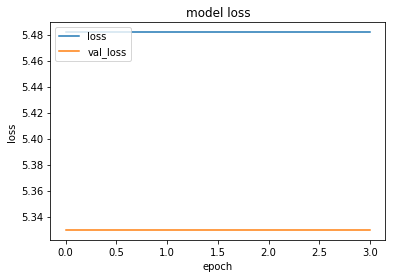

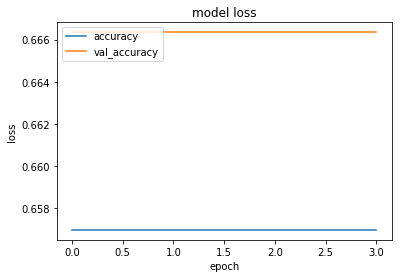

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


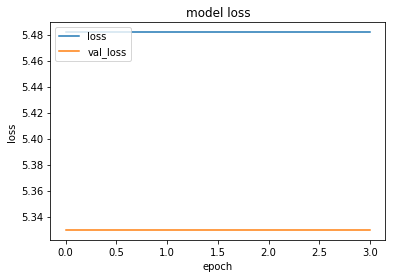

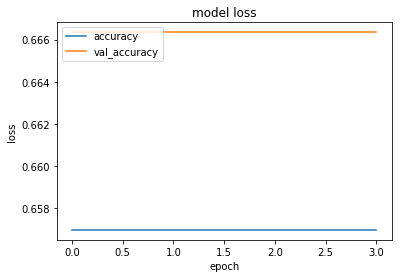

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


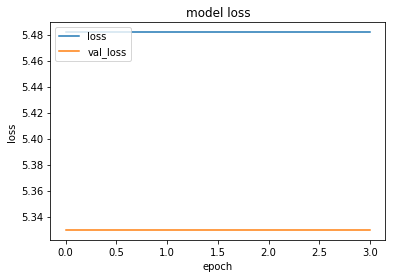

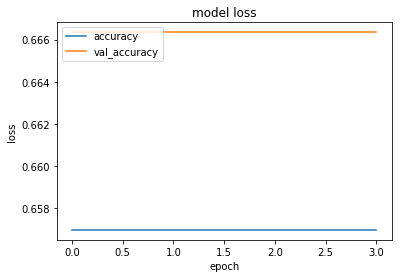

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


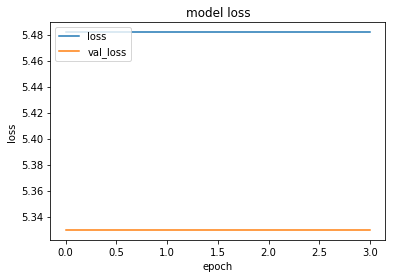

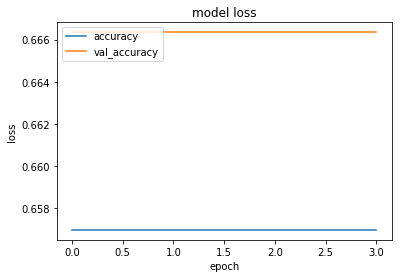

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4817 - acc: 0.6570 - val_loss: 5.3297 - val_acc: 0.6663
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


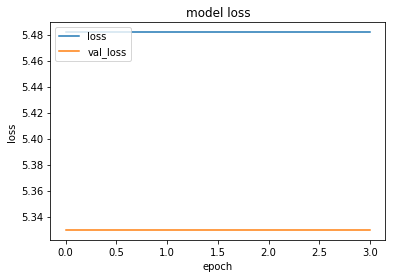

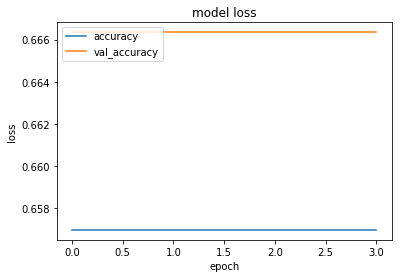

ES STEPS: 1 BEST SCORE: 0.6649 
ES STEPS: 2 BEST SCORE: 0.6649 
ES STEPS: 3 BEST SCORE: 0.6649 
ES STEPS: 4 BEST SCORE: 0.6666 
ES STEPS: 5 BEST SCORE: 0.6666 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


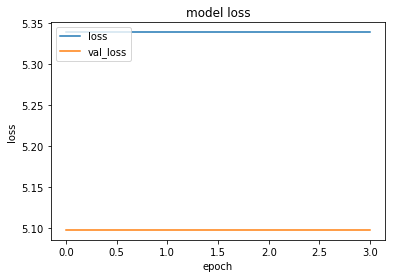

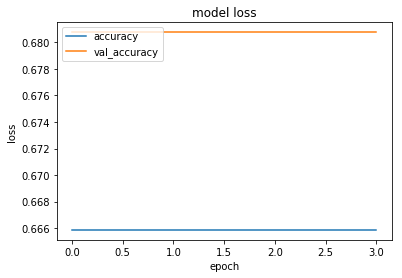

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


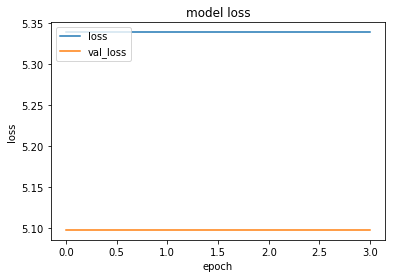

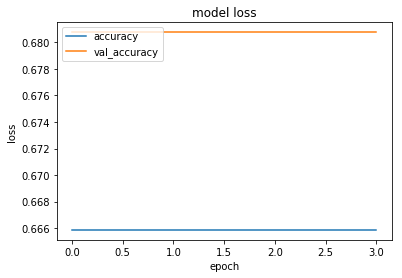

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 4/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


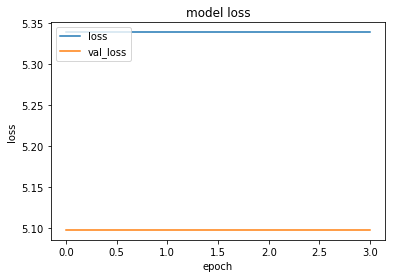

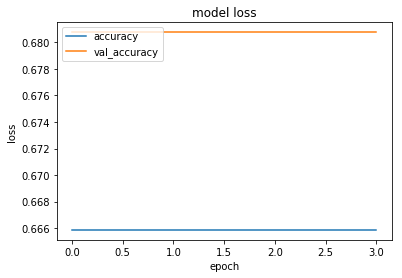

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


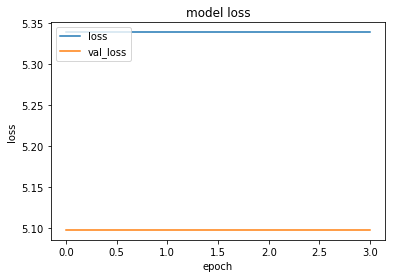

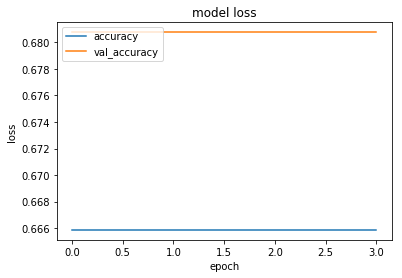

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


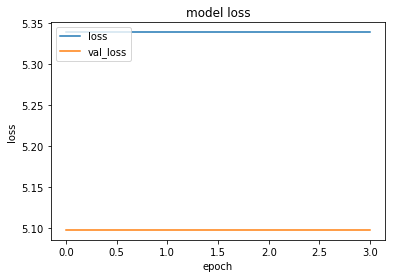

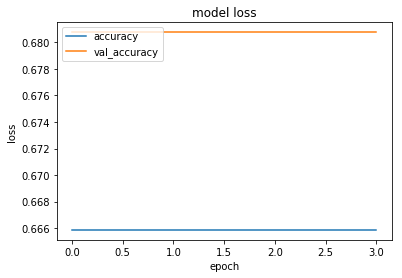

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


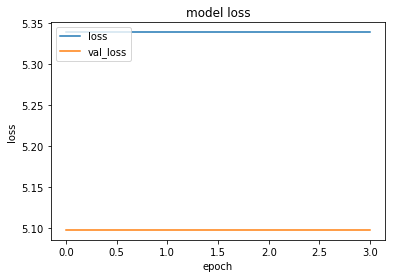

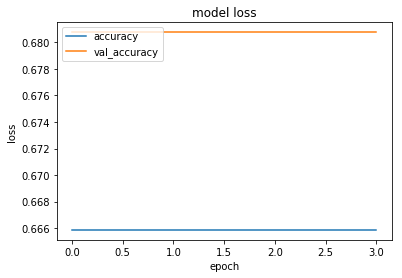

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 4/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


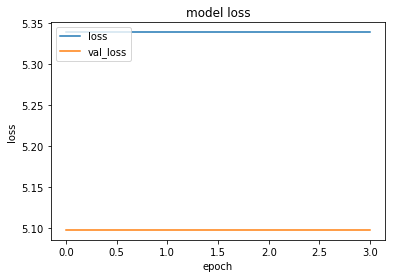

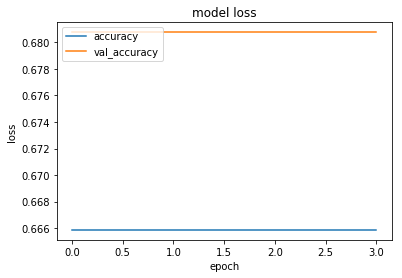

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 85us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


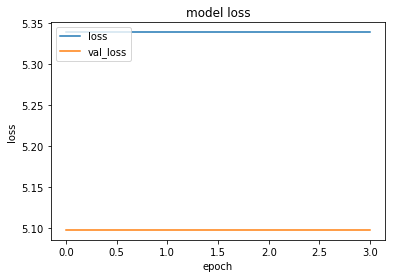

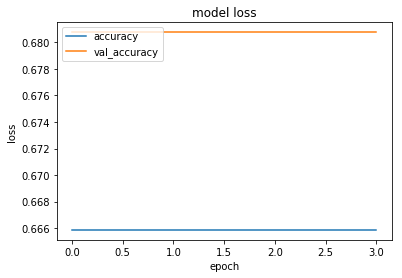

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


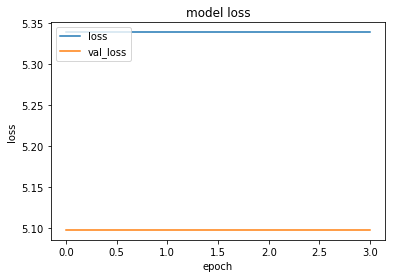

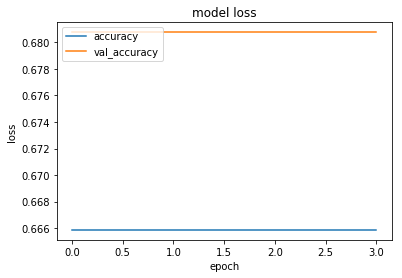

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3385 - acc: 0.6659 - val_loss: 5.0983 - val_acc: 0.6808
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


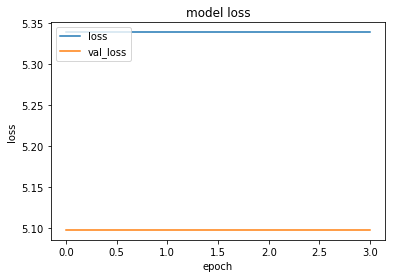

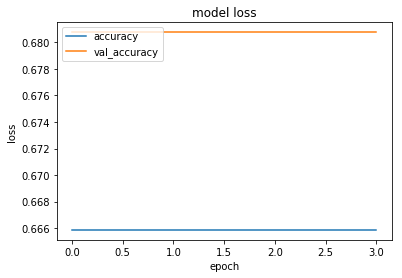

ES STEPS: 1 BEST SCORE: 0.6663 
ES STEPS: 2 BEST SCORE: 0.6663 
ES STEPS: 3 BEST SCORE: 0.6663 
ES STEPS: 4 BEST SCORE: 0.6663 
ES STEPS: 5 BEST SCORE: 0.6663 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


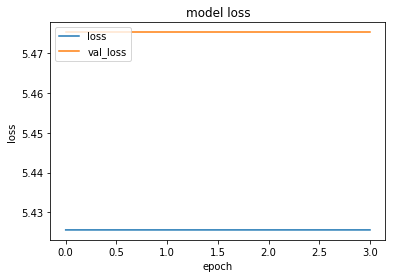

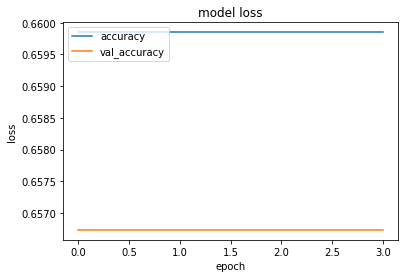

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


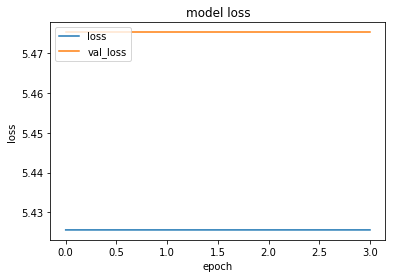

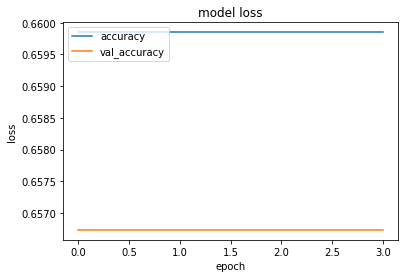

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


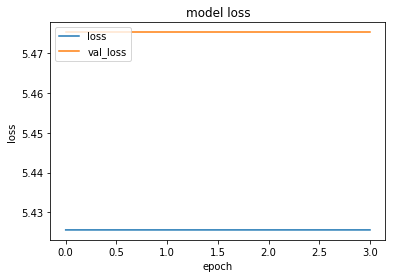

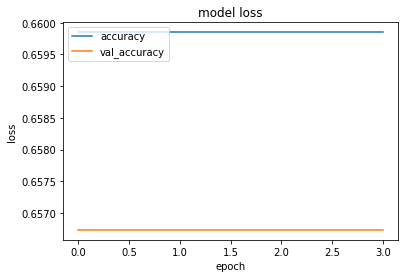

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


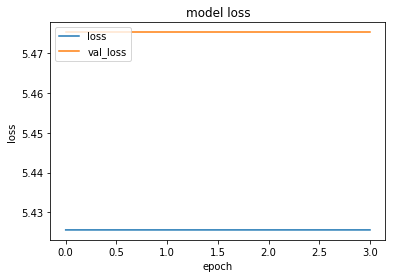

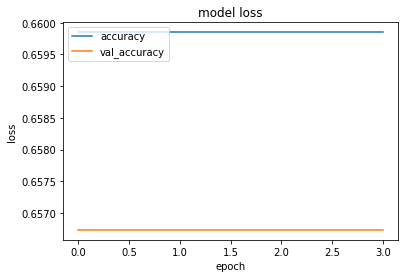

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


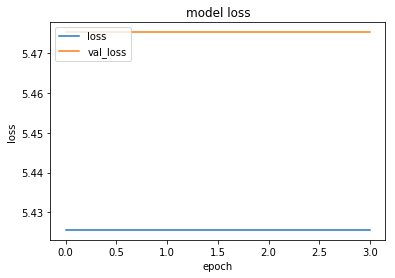

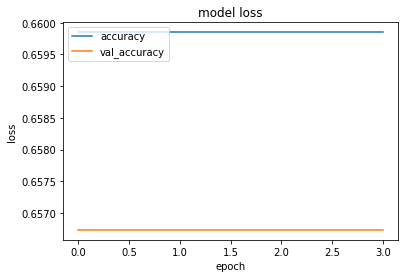

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


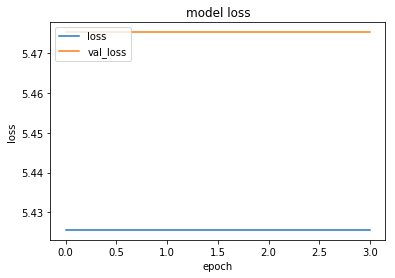

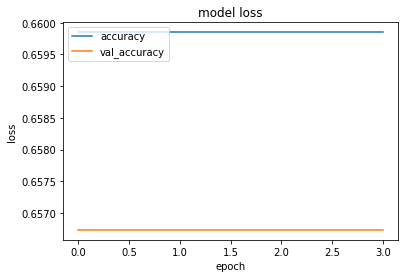

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 3/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


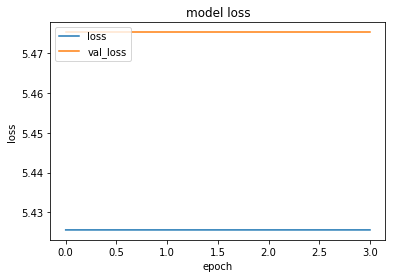

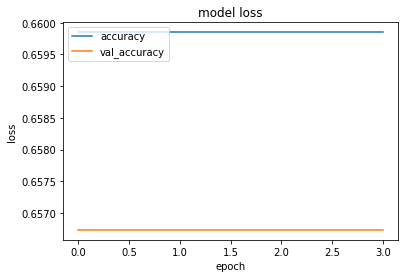

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


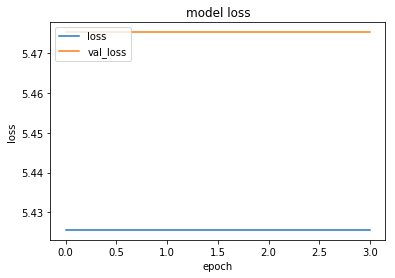

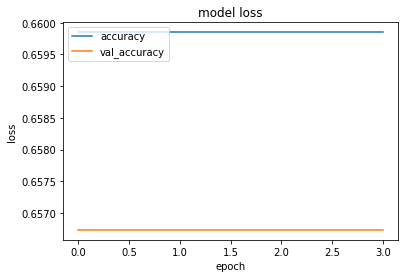

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


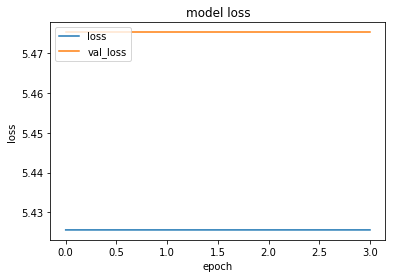

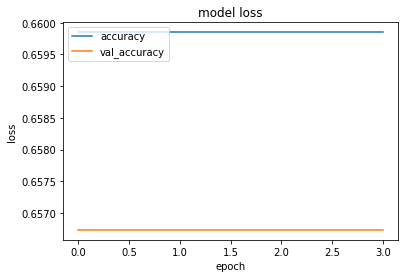

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.4256 - acc: 0.6599 - val_loss: 5.4752 - val_acc: 0.6567
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


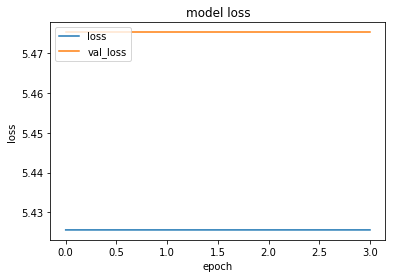

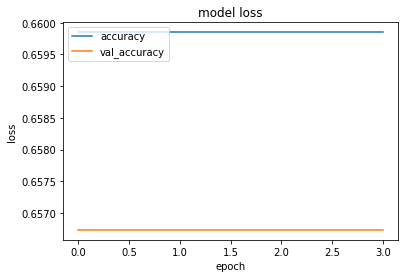

ES STEPS: 1 BEST SCORE: 0.6671 
ES STEPS: 2 BEST SCORE: 0.6721 
ES STEPS: 3 BEST SCORE: 0.6721 
ES STEPS: 4 BEST SCORE: 0.6721 
ES STEPS: 5 BEST SCORE: 0.6721 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


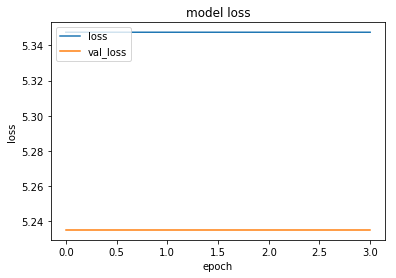

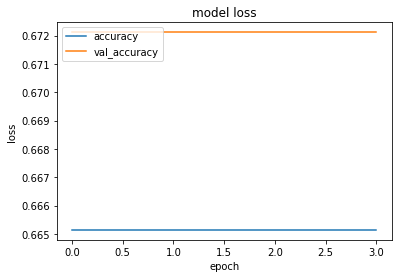

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


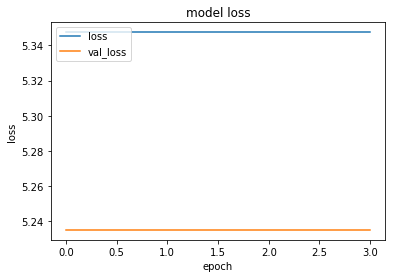

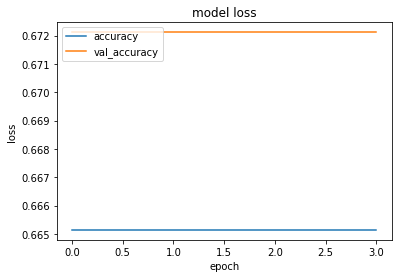

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 2/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 3/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


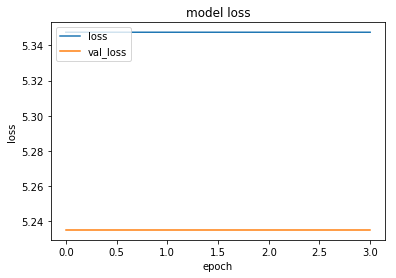

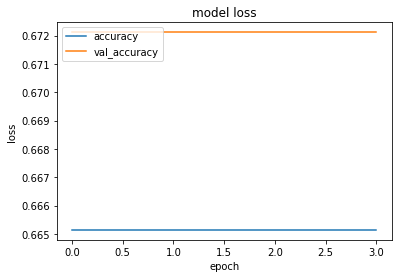

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 3/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


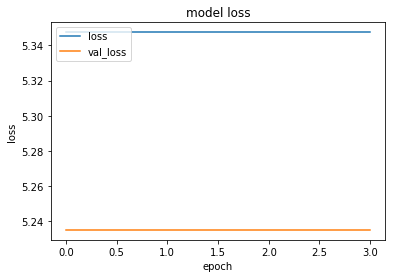

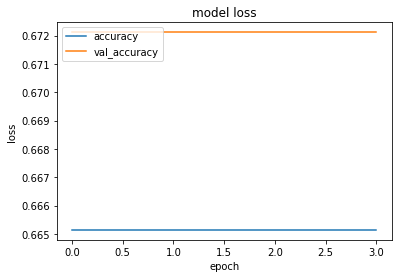

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


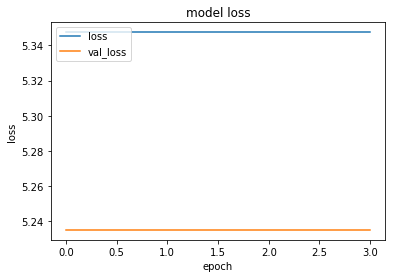

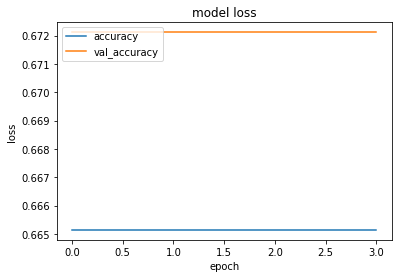

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


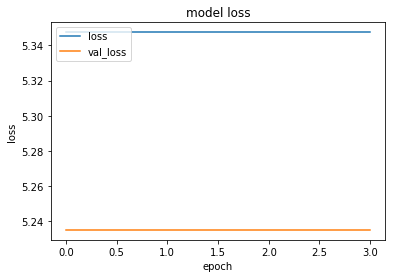

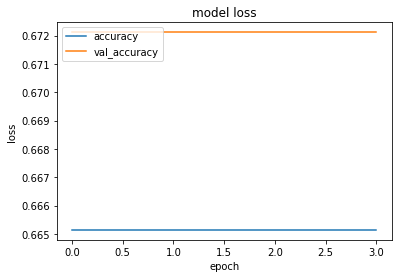

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 3/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


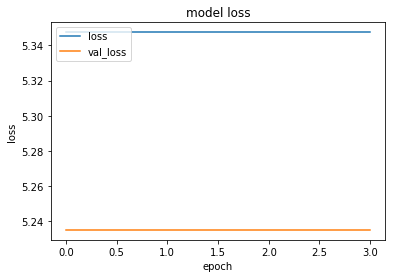

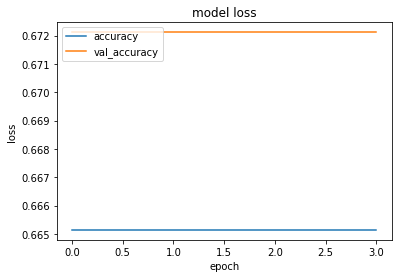

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


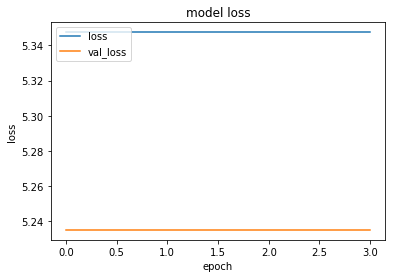

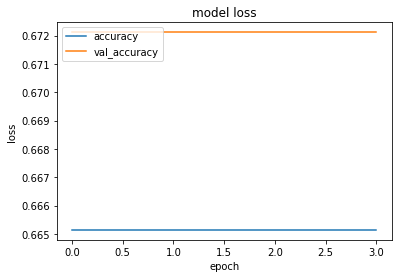

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


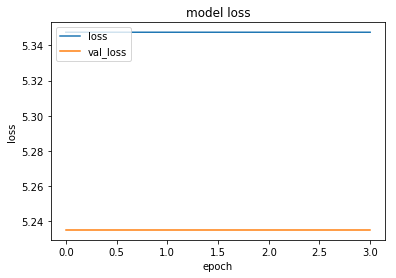

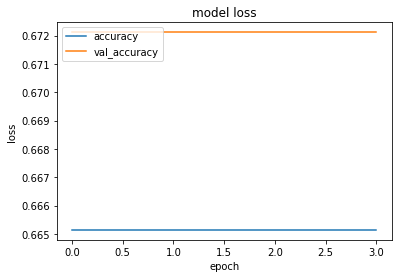

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 2/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Epoch 4/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.3475 - acc: 0.6651 - val_loss: 5.2350 - val_acc: 0.6721
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


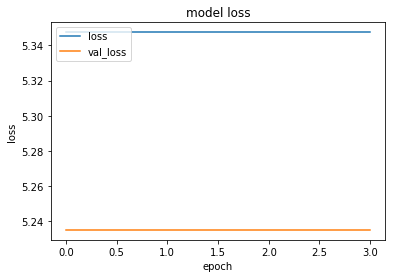

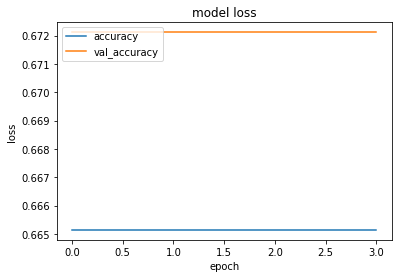

ES STEPS: 1 BEST SCORE: 0.6685 
ES STEPS: 2 BEST SCORE: 0.6685 
ES STEPS: 3 BEST SCORE: 0.6685 
ES STEPS: 4 BEST SCORE: 0.6685 
ES STEPS: 5 BEST SCORE: 0.6685 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1937 - acc: 0.6526 - val_loss: 5.1839 - val_acc: 0.6587
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1840 - acc: 0.6526 - val_loss: 5.1784 - val_acc: 0.6587
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1774 - acc: 0.6526 - val_loss: 5.1741 - val_acc: 0.6587
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1721 - acc: 0.6526 - val_loss: 5.1705 - val_acc: 0.6587
Epoch 5/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.1674 - acc: 0.6526 - val_loss: 5.1673 - val_acc: 0.6587
Epoch 6/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1632 - acc: 0.65

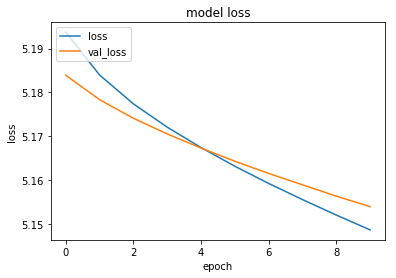

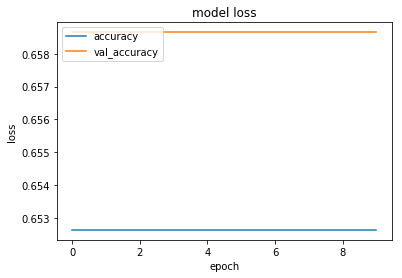

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1454 - acc: 0.6526 - val_loss: 5.1517 - val_acc: 0.6587
Epoch 2/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1422 - acc: 0.6526 - val_loss: 5.1494 - val_acc: 0.6587
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1392 - acc: 0.6526 - val_loss: 5.1472 - val_acc: 0.6587
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1361 - acc: 0.6526 - val_loss: 5.1450 - val_acc: 0.6587
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1332 - acc: 0.6526 - val_loss: 5.1429 - val_acc: 0.6587
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1304 - acc: 0.6526 - val_loss: 5.1409 - val_acc: 0.6587
Epoch 7/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.1276 - acc: 0.6526 - val_loss: 5.1389 - val_acc: 0.6587
Epoch 8

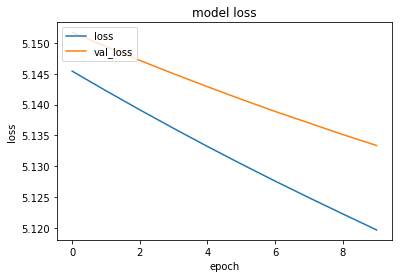

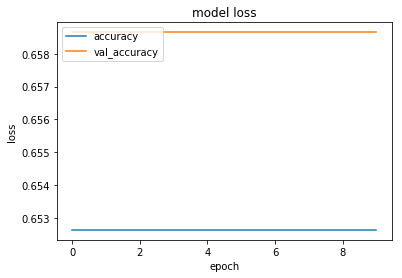

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.1456 - acc: 0.6526 - val_loss: 5.1518 - val_acc: 0.6587
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1426 - acc: 0.6526 - val_loss: 5.1497 - val_acc: 0.6587
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1397 - acc: 0.6526 - val_loss: 5.1475 - val_acc: 0.6587
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1368 - acc: 0.6526 - val_loss: 5.1455 - val_acc: 0.6587
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1340 - acc: 0.6526 - val_loss: 5.1435 - val_acc: 0.6587
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1313 - acc: 0.6526 - val_loss: 5.1415 - val_acc: 0.6587
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1286 - acc: 0.6526 - val_loss: 5.1396 - val_acc: 0.6587
Epoch 8

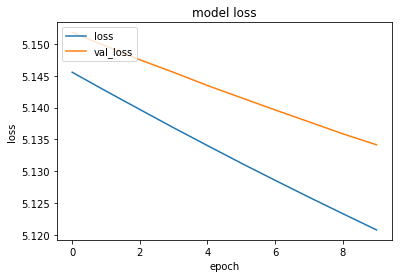

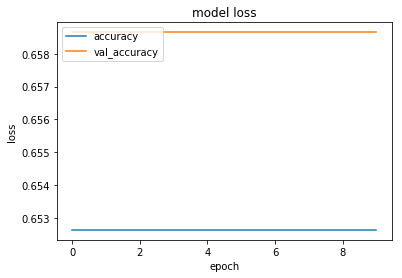

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1456 - acc: 0.6526 - val_loss: 5.1518 - val_acc: 0.6587
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1427 - acc: 0.6526 - val_loss: 5.1497 - val_acc: 0.6587
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1398 - acc: 0.6526 - val_loss: 5.1477 - val_acc: 0.6587
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1370 - acc: 0.6526 - val_loss: 5.1456 - val_acc: 0.6587
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1342 - acc: 0.6526 - val_loss: 5.1436 - val_acc: 0.6587
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1314 - acc: 0.6526 - val_loss: 5.1417 - val_acc: 0.6587
Epoch 7/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1287 - acc: 0.6526 - val_loss: 5.1397 - val_acc: 0.6587
Epoch 8

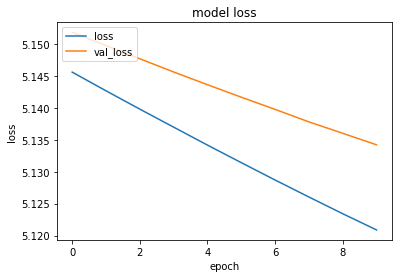

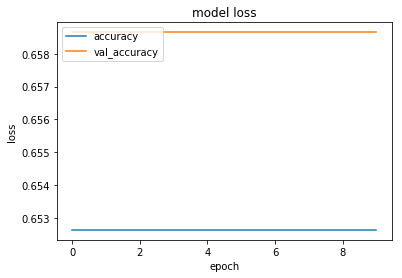

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.1456 - acc: 0.6526 - val_loss: 5.1519 - val_acc: 0.6587
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1427 - acc: 0.6526 - val_loss: 5.1498 - val_acc: 0.6587
Epoch 3/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.1399 - acc: 0.6526 - val_loss: 5.1477 - val_acc: 0.6587
Epoch 4/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1371 - acc: 0.6526 - val_loss: 5.1457 - val_acc: 0.6587
Epoch 5/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1343 - acc: 0.6526 - val_loss: 5.1437 - val_acc: 0.6587
Epoch 6/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.1316 - acc: 0.6526 - val_loss: 5.1417 - val_acc: 0.6587
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1289 - acc: 0.6526 - val_loss: 5.1399 - val_acc: 0.6587
Epoch 8

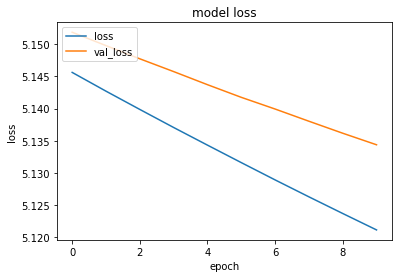

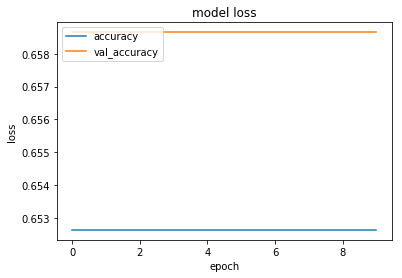

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1456 - acc: 0.6526 - val_loss: 5.1519 - val_acc: 0.6587
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1428 - acc: 0.6526 - val_loss: 5.1498 - val_acc: 0.6587
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1399 - acc: 0.6526 - val_loss: 5.1477 - val_acc: 0.6587
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1371 - acc: 0.6526 - val_loss: 5.1458 - val_acc: 0.6587
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1344 - acc: 0.6526 - val_loss: 5.1438 - val_acc: 0.6587
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1316 - acc: 0.6526 - val_loss: 5.1418 - val_acc: 0.6587
Epoch 7/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1289 - acc: 0.6526 - val_loss: 5.1399 - val_acc: 0.6587
Epoch 8

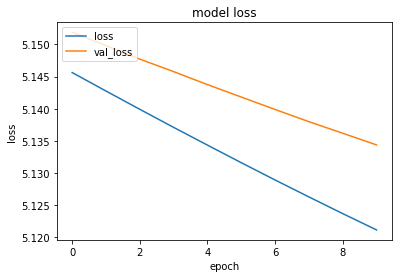

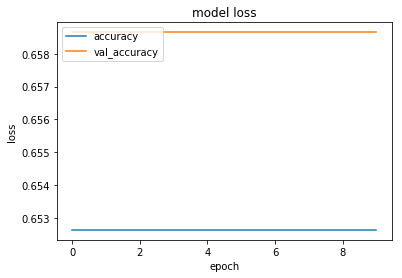

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1456 - acc: 0.6526 - val_loss: 5.1519 - val_acc: 0.6587
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1427 - acc: 0.6526 - val_loss: 5.1497 - val_acc: 0.6587
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1399 - acc: 0.6526 - val_loss: 5.1477 - val_acc: 0.6587
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1371 - acc: 0.6526 - val_loss: 5.1457 - val_acc: 0.6587
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1343 - acc: 0.6526 - val_loss: 5.1437 - val_acc: 0.6587
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1316 - acc: 0.6526 - val_loss: 5.1418 - val_acc: 0.6587
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1289 - acc: 0.6526 - val_loss: 5.1399 - val_acc: 0.6587
Epoch 8

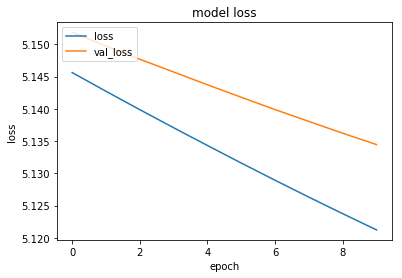

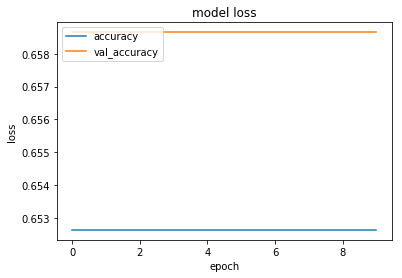

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.1456 - acc: 0.6526 - val_loss: 5.1519 - val_acc: 0.6587
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1427 - acc: 0.6526 - val_loss: 5.1498 - val_acc: 0.6587
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1399 - acc: 0.6526 - val_loss: 5.1477 - val_acc: 0.6587
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1371 - acc: 0.6526 - val_loss: 5.1458 - val_acc: 0.6587
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1344 - acc: 0.6526 - val_loss: 5.1438 - val_acc: 0.6587
Epoch 6/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1317 - acc: 0.6526 - val_loss: 5.1419 - val_acc: 0.6587
Epoch 7/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.1290 - acc: 0.6526 - val_loss: 5.1399 - val_acc: 0.6587
Epoch 8

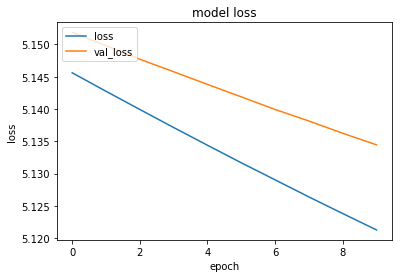

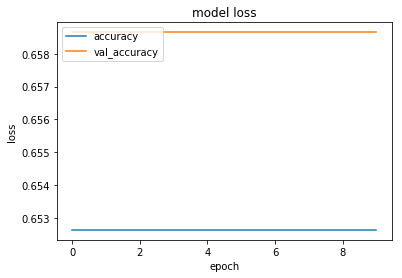

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1457 - acc: 0.6526 - val_loss: 5.1519 - val_acc: 0.6587
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1428 - acc: 0.6526 - val_loss: 5.1498 - val_acc: 0.6587
Epoch 3/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.1400 - acc: 0.6526 - val_loss: 5.1478 - val_acc: 0.6587
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1372 - acc: 0.6526 - val_loss: 5.1459 - val_acc: 0.6587
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1344 - acc: 0.6526 - val_loss: 5.1438 - val_acc: 0.6587
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1317 - acc: 0.6526 - val_loss: 5.1419 - val_acc: 0.6587
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1290 - acc: 0.6526 - val_loss: 5.1400 - val_acc: 0.6587
Epoch 8

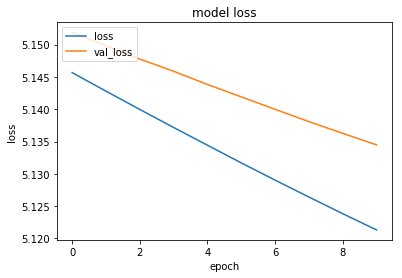

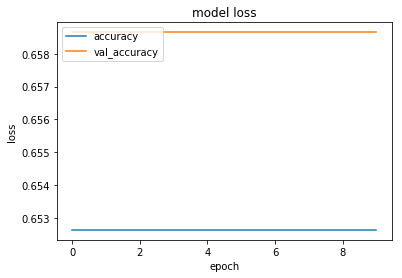

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 84us/step - loss: 5.1457 - acc: 0.6526 - val_loss: 5.1519 - val_acc: 0.6587
Epoch 2/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.1428 - acc: 0.6526 - val_loss: 5.1498 - val_acc: 0.6587
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1399 - acc: 0.6526 - val_loss: 5.1478 - val_acc: 0.6587
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1371 - acc: 0.6526 - val_loss: 5.1457 - val_acc: 0.6587
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1343 - acc: 0.6526 - val_loss: 5.1438 - val_acc: 0.6587
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1315 - acc: 0.6526 - val_loss: 5.1418 - val_acc: 0.6587
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1288 - acc: 0.6526 - val_loss: 5.1398 - val_acc: 0.6587
Epoch 8

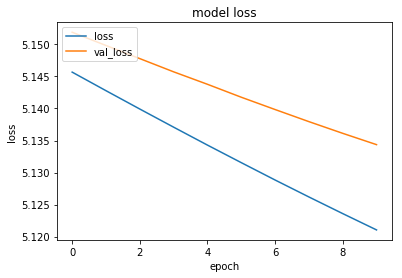

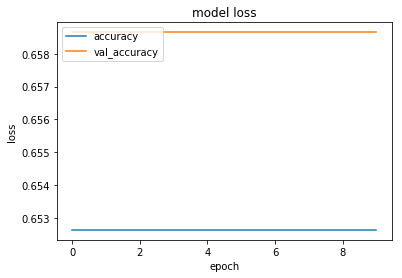

ES STEPS: 1 BEST SCORE: 0.6546 
ES STEPS: 2 BEST SCORE: 0.6550 
ES STEPS: 3 BEST SCORE: 0.6550 
ES STEPS: 4 BEST SCORE: 0.6558 
ES STEPS: 5 BEST SCORE: 0.6558 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.2043 - acc: 0.6558 - val_loss: 5.1248 - val_acc: 0.6644
Epoch 2/10
4157/4157 [==============================] - 0s 75us/step - loss: 5.2023 - acc: 0.6558 - val_loss: 5.1232 - val_acc: 0.6644
Epoch 3/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.2003 - acc: 0.6558 - val_loss: 5.1217 - val_acc: 0.6644
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1984 - acc: 0.6558 - val_loss: 5.1201 - val_acc: 0.6644
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1964 - acc: 0.6558 - val_loss: 5.1186 - val_acc: 0.6644
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1944 - acc: 0.65

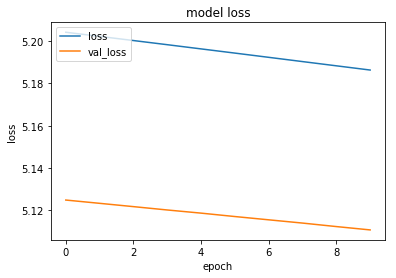

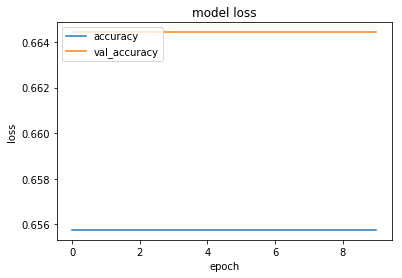

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.1844 - acc: 0.6558 - val_loss: 5.1091 - val_acc: 0.6644
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1824 - acc: 0.6558 - val_loss: 5.1075 - val_acc: 0.6644
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1804 - acc: 0.6558 - val_loss: 5.1058 - val_acc: 0.6644
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1783 - acc: 0.6558 - val_loss: 5.1044 - val_acc: 0.6644
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1763 - acc: 0.6558 - val_loss: 5.1027 - val_acc: 0.6644
Epoch 6/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1743 - acc: 0.6558 - val_loss: 5.1011 - val_acc: 0.6644
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1723 - acc: 0.6558 - val_loss: 5.0996 - val_acc: 0.6644
Epoch 8

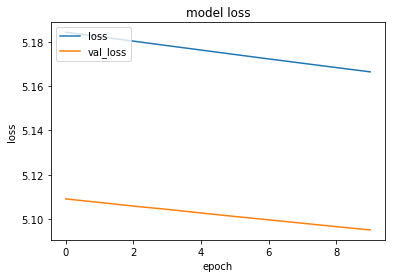

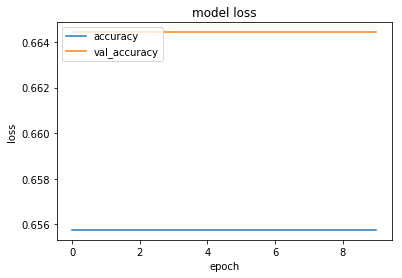

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1843 - acc: 0.6558 - val_loss: 5.1089 - val_acc: 0.6644
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1822 - acc: 0.6558 - val_loss: 5.1073 - val_acc: 0.6644
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1801 - acc: 0.6558 - val_loss: 5.1057 - val_acc: 0.6644
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1780 - acc: 0.6558 - val_loss: 5.1040 - val_acc: 0.6644
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1759 - acc: 0.6558 - val_loss: 5.1024 - val_acc: 0.6644
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1738 - acc: 0.6558 - val_loss: 5.1007 - val_acc: 0.6644
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1718 - acc: 0.6558 - val_loss: 5.0992 - val_acc: 0.6644
Epoch 8

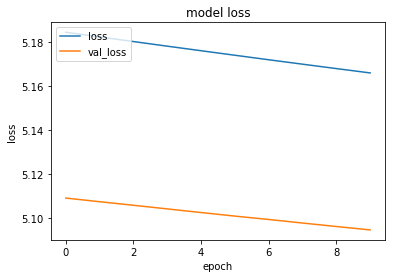

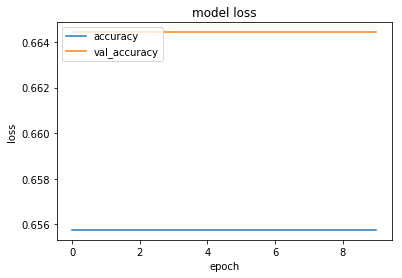

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1843 - acc: 0.6558 - val_loss: 5.1090 - val_acc: 0.6644
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1822 - acc: 0.6558 - val_loss: 5.1073 - val_acc: 0.6644
Epoch 3/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1800 - acc: 0.6558 - val_loss: 5.1056 - val_acc: 0.6644
Epoch 4/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.1779 - acc: 0.6558 - val_loss: 5.1039 - val_acc: 0.6644
Epoch 5/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1758 - acc: 0.6558 - val_loss: 5.1023 - val_acc: 0.6644
Epoch 6/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.1738 - acc: 0.6558 - val_loss: 5.1008 - val_acc: 0.6644
Epoch 7/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1717 - acc: 0.6558 - val_loss: 5.0991 - val_acc: 0.6644
Epoch 8

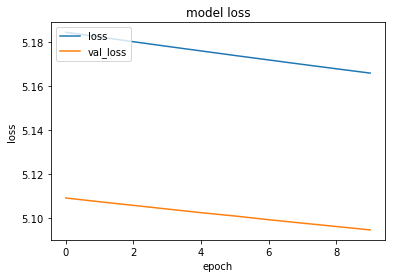

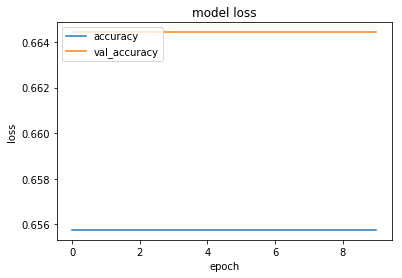

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1843 - acc: 0.6558 - val_loss: 5.1090 - val_acc: 0.6644
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1821 - acc: 0.6558 - val_loss: 5.1072 - val_acc: 0.6644
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1800 - acc: 0.6558 - val_loss: 5.1055 - val_acc: 0.6644
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1778 - acc: 0.6558 - val_loss: 5.1039 - val_acc: 0.6644
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1757 - acc: 0.6558 - val_loss: 5.1023 - val_acc: 0.6644
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1737 - acc: 0.6558 - val_loss: 5.1007 - val_acc: 0.6644
Epoch 7/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.1716 - acc: 0.6558 - val_loss: 5.0991 - val_acc: 0.6644
Epoch 8

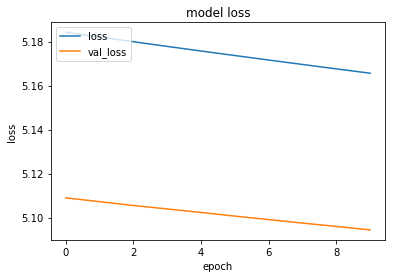

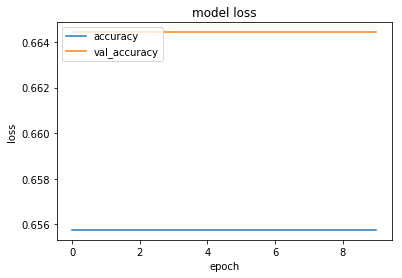

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1843 - acc: 0.6558 - val_loss: 5.1089 - val_acc: 0.6644
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1822 - acc: 0.6558 - val_loss: 5.1073 - val_acc: 0.6644
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1801 - acc: 0.6558 - val_loss: 5.1056 - val_acc: 0.6644
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 5.1780 - acc: 0.6558 - val_loss: 5.1040 - val_acc: 0.6644
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 5.1759 - acc: 0.6558 - val_loss: 5.1024 - val_acc: 0.6644
Epoch 6/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.1738 - acc: 0.6558 - val_loss: 5.1008 - val_acc: 0.6644
Epoch 7/10
4157/4157 [==============================] - 0s 79us/step - loss: 5.1718 - acc: 0.6558 - val_loss: 5.0992 - val_acc: 0.6644
Epoch 8

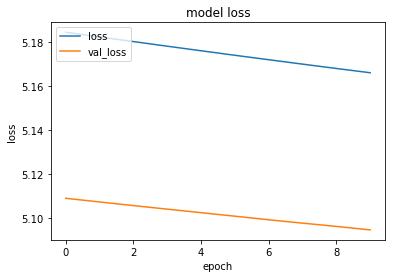

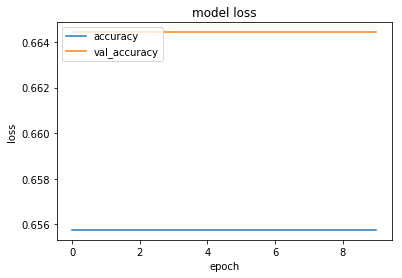

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 86us/step - loss: 5.1843 - acc: 0.6558 - val_loss: 5.1090 - val_acc: 0.6644
Epoch 2/10
4157/4157 [==============================] - 0s 84us/step - loss: 5.1822 - acc: 0.6558 - val_loss: 5.1073 - val_acc: 0.6644
Epoch 3/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1801 - acc: 0.6558 - val_loss: 5.1057 - val_acc: 0.6644
Epoch 4/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1780 - acc: 0.6558 - val_loss: 5.1040 - val_acc: 0.6644
Epoch 5/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.1760 - acc: 0.6558 - val_loss: 5.1024 - val_acc: 0.6644
Epoch 6/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1739 - acc: 0.6558 - val_loss: 5.1008 - val_acc: 0.6644
Epoch 7/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1719 - acc: 0.6558 - val_loss: 5.0992 - val_acc: 0.6644
Epoch 8

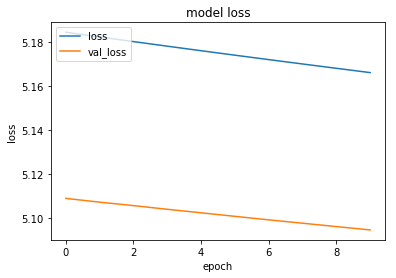

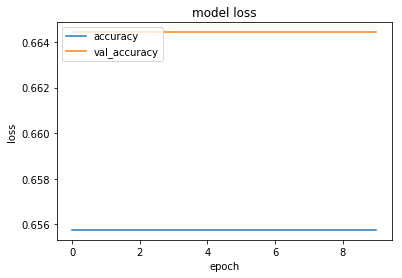

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1843 - acc: 0.6558 - val_loss: 5.1089 - val_acc: 0.6644
Epoch 2/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1822 - acc: 0.6558 - val_loss: 5.1073 - val_acc: 0.6644
Epoch 3/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1801 - acc: 0.6558 - val_loss: 5.1056 - val_acc: 0.6644
Epoch 4/10
4157/4157 [==============================] - 0s 88us/step - loss: 5.1780 - acc: 0.6558 - val_loss: 5.1040 - val_acc: 0.6644
Epoch 5/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1759 - acc: 0.6558 - val_loss: 5.1024 - val_acc: 0.6644
Epoch 6/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.1739 - acc: 0.6558 - val_loss: 5.1009 - val_acc: 0.6644
Epoch 7/10
4157/4157 [==============================] - 0s 85us/step - loss: 5.1719 - acc: 0.6558 - val_loss: 5.0992 - val_acc: 0.6644
Epoch 8

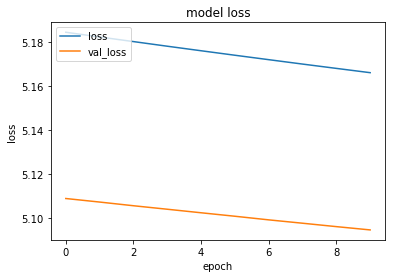

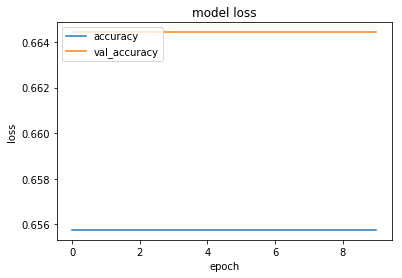

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 89us/step - loss: 5.1843 - acc: 0.6558 - val_loss: 5.1090 - val_acc: 0.6644
Epoch 2/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.1822 - acc: 0.6558 - val_loss: 5.1073 - val_acc: 0.6644
Epoch 3/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.1801 - acc: 0.6558 - val_loss: 5.1056 - val_acc: 0.6644
Epoch 4/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1780 - acc: 0.6558 - val_loss: 5.1041 - val_acc: 0.6644
Epoch 5/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1760 - acc: 0.6558 - val_loss: 5.1024 - val_acc: 0.6644
Epoch 6/10
4157/4157 [==============================] - 0s 81us/step - loss: 5.1739 - acc: 0.6558 - val_loss: 5.1008 - val_acc: 0.6644
Epoch 7/10
4157/4157 [==============================] - 0s 84us/step - loss: 5.1719 - acc: 0.6558 - val_loss: 5.0993 - val_acc: 0.6644
Epoch 8

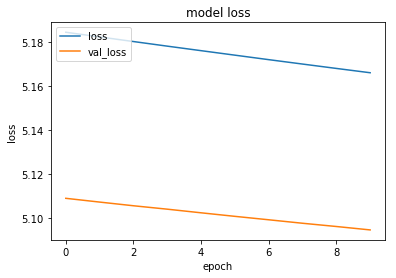

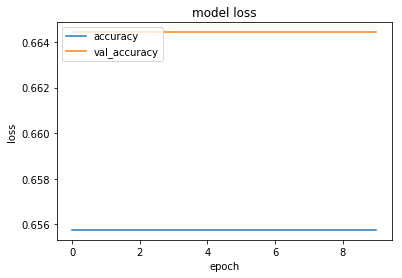

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1843 - acc: 0.6558 - val_loss: 5.1089 - val_acc: 0.6644
Epoch 2/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1821 - acc: 0.6558 - val_loss: 5.1072 - val_acc: 0.6644
Epoch 3/10
4157/4157 [==============================] - 0s 83us/step - loss: 5.1800 - acc: 0.6558 - val_loss: 5.1056 - val_acc: 0.6644
Epoch 4/10
4157/4157 [==============================] - 0s 82us/step - loss: 5.1779 - acc: 0.6558 - val_loss: 5.1039 - val_acc: 0.6644
Epoch 5/10
4157/4157 [==============================] - 0s 80us/step - loss: 5.1758 - acc: 0.6558 - val_loss: 5.1023 - val_acc: 0.6644
Epoch 6/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1737 - acc: 0.6558 - val_loss: 5.1007 - val_acc: 0.6644
Epoch 7/10
4157/4157 [==============================] - 0s 78us/step - loss: 5.1717 - acc: 0.6558 - val_loss: 5.0991 - val_acc: 0.6644
Epoch 8

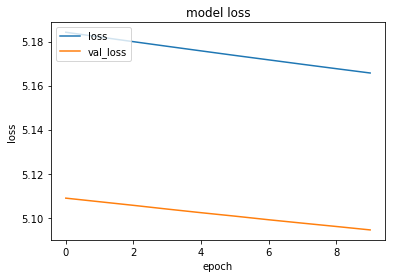

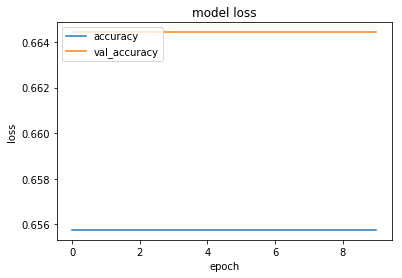

ES STEPS: 1 BEST SCORE: 0.6594 
ES STEPS: 2 BEST SCORE: 0.6625 
ES STEPS: 3 BEST SCORE: 0.6639 
ES STEPS: 4 BEST SCORE: 0.6639 
ES STEPS: 5 BEST SCORE: 0.6639 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 82us/step - loss: 4.9663 - acc: 0.6618 - val_loss: 4.9129 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.9646 - acc: 0.6618 - val_loss: 4.9113 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.9629 - acc: 0.6618 - val_loss: 4.9099 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 81us/step - loss: 4.9613 - acc: 0.6618 - val_loss: 4.9086 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 82us/step - loss: 4.9599 - acc: 0.6618 - val_loss: 4.9073 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 86us/step - loss: 4.9586 - acc: 0.66

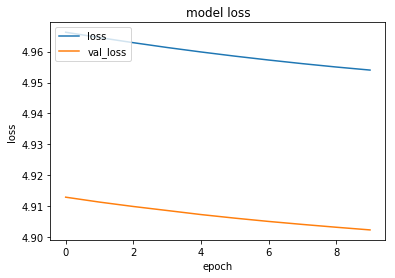

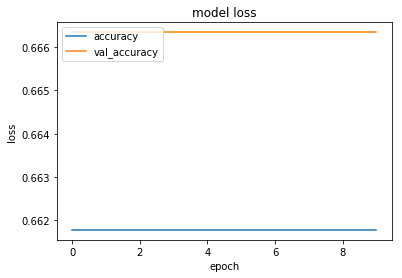

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.9531 - acc: 0.6618 - val_loss: 4.9017 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 81us/step - loss: 4.9523 - acc: 0.6618 - val_loss: 4.9010 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 83us/step - loss: 4.9515 - acc: 0.6618 - val_loss: 4.9003 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9508 - acc: 0.6618 - val_loss: 4.8998 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 80us/step - loss: 4.9502 - acc: 0.6618 - val_loss: 4.8994 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.9496 - acc: 0.6618 - val_loss: 4.8989 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 82us/step - loss: 4.9491 - acc: 0.6618 - val_loss: 4.8986 - val_acc: 0.6663
Epoch 8

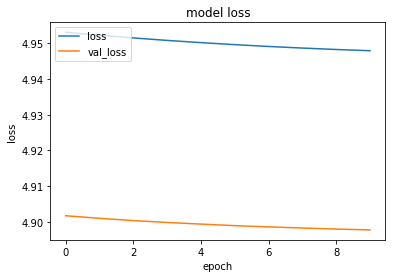

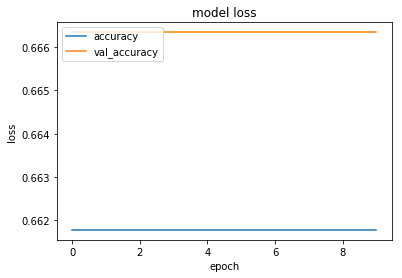

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.9531 - acc: 0.6618 - val_loss: 4.9016 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 80us/step - loss: 4.9521 - acc: 0.6618 - val_loss: 4.9008 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9513 - acc: 0.6618 - val_loss: 4.9002 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.9506 - acc: 0.6618 - val_loss: 4.8996 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9499 - acc: 0.6618 - val_loss: 4.8991 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9493 - acc: 0.6618 - val_loss: 4.8987 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.9488 - acc: 0.6618 - val_loss: 4.8983 - val_acc: 0.6663
Epoch 8

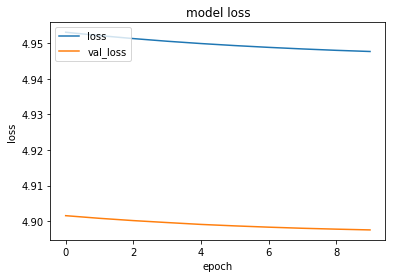

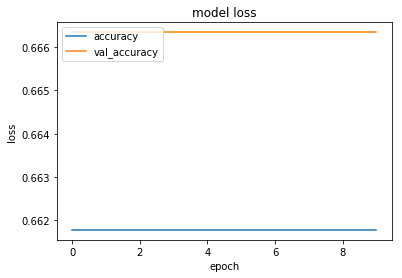

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 82us/step - loss: 4.9530 - acc: 0.6618 - val_loss: 4.9015 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9520 - acc: 0.6618 - val_loss: 4.9007 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9512 - acc: 0.6618 - val_loss: 4.9001 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.9504 - acc: 0.6618 - val_loss: 4.8995 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.9498 - acc: 0.6618 - val_loss: 4.8990 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 74us/step - loss: 4.9492 - acc: 0.6618 - val_loss: 4.8986 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 81us/step - loss: 4.9487 - acc: 0.6618 - val_loss: 4.8983 - val_acc: 0.6663
Epoch 8

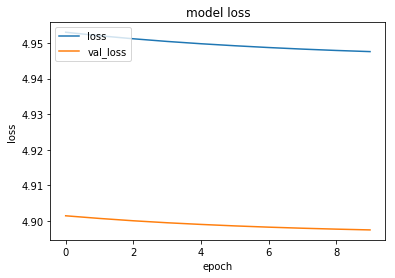

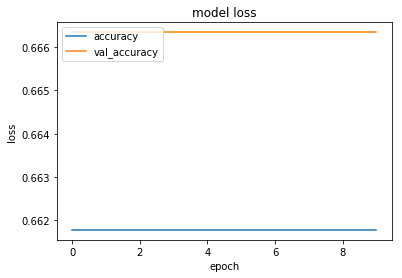

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.9531 - acc: 0.6618 - val_loss: 4.9015 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.9521 - acc: 0.6618 - val_loss: 4.9008 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 81us/step - loss: 4.9512 - acc: 0.6618 - val_loss: 4.9001 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.9504 - acc: 0.6618 - val_loss: 4.8995 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 74us/step - loss: 4.9498 - acc: 0.6618 - val_loss: 4.8990 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.9492 - acc: 0.6618 - val_loss: 4.8986 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9487 - acc: 0.6618 - val_loss: 4.8983 - val_acc: 0.6663
Epoch 8

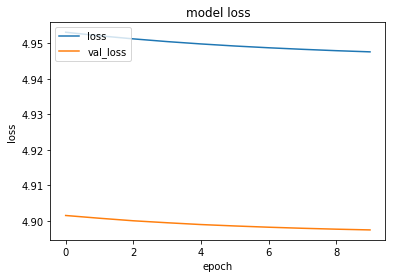

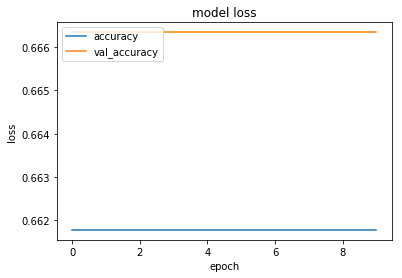

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.9530 - acc: 0.6618 - val_loss: 4.9015 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9520 - acc: 0.6618 - val_loss: 4.9007 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 74us/step - loss: 4.9512 - acc: 0.6618 - val_loss: 4.9000 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.9504 - acc: 0.6618 - val_loss: 4.8995 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 74us/step - loss: 4.9497 - acc: 0.6618 - val_loss: 4.8990 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9492 - acc: 0.6618 - val_loss: 4.8985 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 81us/step - loss: 4.9487 - acc: 0.6618 - val_loss: 4.8982 - val_acc: 0.6663
Epoch 8

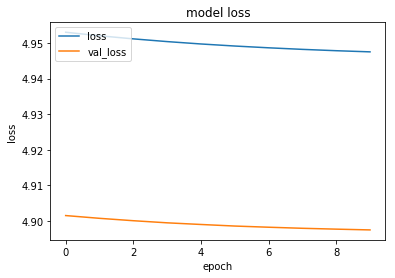

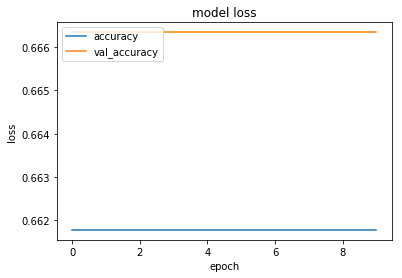

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.9530 - acc: 0.6618 - val_loss: 4.9015 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 74us/step - loss: 4.9520 - acc: 0.6618 - val_loss: 4.9007 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 80us/step - loss: 4.9511 - acc: 0.6618 - val_loss: 4.9000 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.9504 - acc: 0.6618 - val_loss: 4.8995 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 81us/step - loss: 4.9498 - acc: 0.6618 - val_loss: 4.8990 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 89us/step - loss: 4.9492 - acc: 0.6618 - val_loss: 4.8986 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 85us/step - loss: 4.9487 - acc: 0.6618 - val_loss: 4.8982 - val_acc: 0.6663
Epoch 8

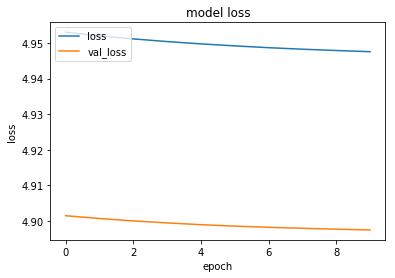

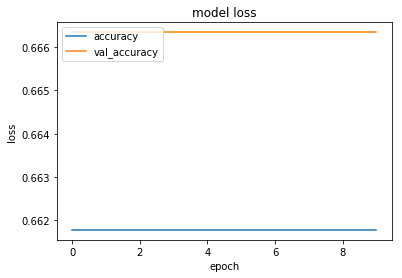

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.9530 - acc: 0.6618 - val_loss: 4.9014 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9520 - acc: 0.6618 - val_loss: 4.9007 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9512 - acc: 0.6618 - val_loss: 4.9000 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.9504 - acc: 0.6618 - val_loss: 4.8995 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.9498 - acc: 0.6618 - val_loss: 4.8990 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.9492 - acc: 0.6618 - val_loss: 4.8986 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9487 - acc: 0.6618 - val_loss: 4.8982 - val_acc: 0.6663
Epoch 8

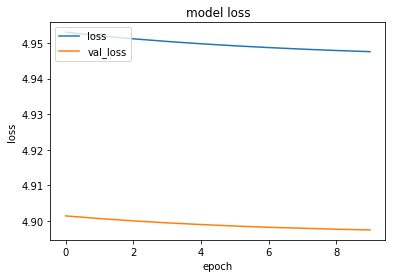

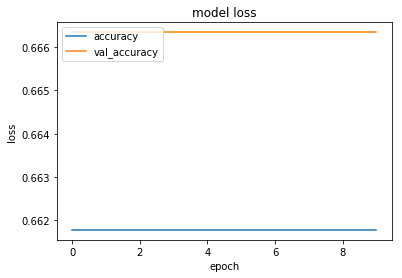

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.9530 - acc: 0.6618 - val_loss: 4.9014 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.9520 - acc: 0.6618 - val_loss: 4.9007 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.9511 - acc: 0.6618 - val_loss: 4.9000 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.9504 - acc: 0.6618 - val_loss: 4.8995 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.9497 - acc: 0.6618 - val_loss: 4.8990 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9492 - acc: 0.6618 - val_loss: 4.8986 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.9487 - acc: 0.6618 - val_loss: 4.8982 - val_acc: 0.6663
Epoch 8

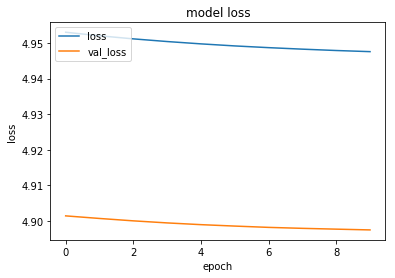

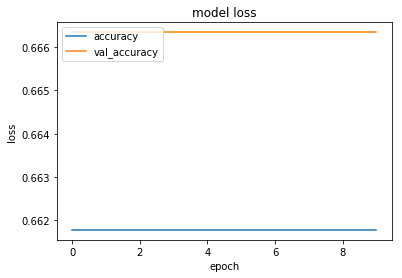

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.9530 - acc: 0.6618 - val_loss: 4.9015 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9521 - acc: 0.6618 - val_loss: 4.9007 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9512 - acc: 0.6618 - val_loss: 4.9001 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9505 - acc: 0.6618 - val_loss: 4.8995 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.9498 - acc: 0.6618 - val_loss: 4.8991 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9493 - acc: 0.6618 - val_loss: 4.8986 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.9488 - acc: 0.6618 - val_loss: 4.8983 - val_acc: 0.6663
Epoch 8

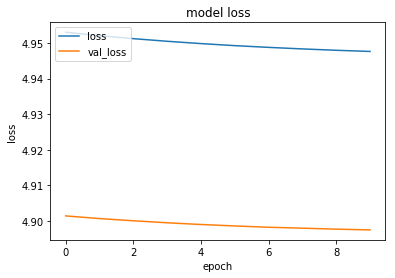

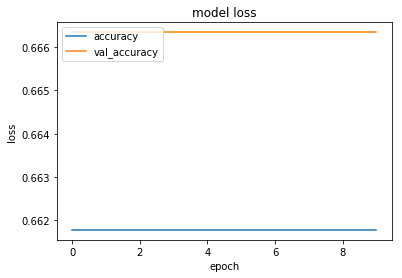

ES STEPS: 1 BEST SCORE: 0.6637 
ES STEPS: 2 BEST SCORE: 0.6637 
ES STEPS: 3 BEST SCORE: 0.6637 
ES STEPS: 4 BEST SCORE: 0.6637 
ES STEPS: 5 BEST SCORE: 0.6637 
Stop: Reach max_steps
Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.6582 - acc: 0.6558 - val_loss: 4.6575 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6498 - acc: 0.6558 - val_loss: 4.6521 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.6431 - acc: 0.6558 - val_loss: 4.6478 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6375 - acc: 0.6558 - val_loss: 4.6441 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6328 - acc: 0.6558 - val_loss: 4.6410 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.6287 - acc: 0.65

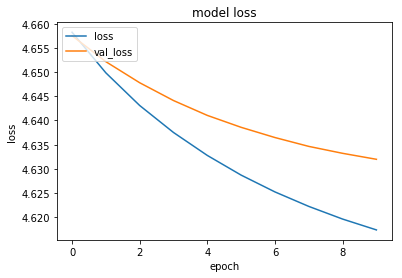

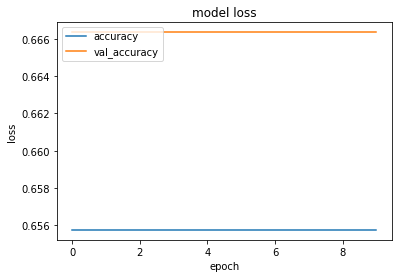

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 81us/step - loss: 4.6155 - acc: 0.6558 - val_loss: 4.6310 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6138 - acc: 0.6558 - val_loss: 4.6303 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6124 - acc: 0.6558 - val_loss: 4.6296 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 73us/step - loss: 4.6112 - acc: 0.6558 - val_loss: 4.6292 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 80us/step - loss: 4.6102 - acc: 0.6558 - val_loss: 4.6288 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6094 - acc: 0.6558 - val_loss: 4.6286 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.6086 - acc: 0.6558 - val_loss: 4.6284 - val_acc: 0.6663
Epoch 8

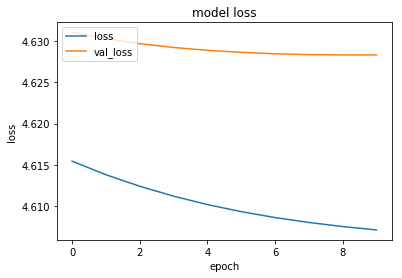

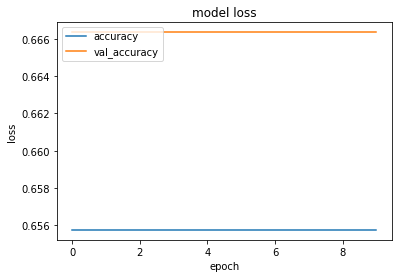

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.6153 - acc: 0.6558 - val_loss: 4.6309 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 81us/step - loss: 4.6135 - acc: 0.6558 - val_loss: 4.6301 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.6120 - acc: 0.6558 - val_loss: 4.6295 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.6108 - acc: 0.6558 - val_loss: 4.6290 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.6098 - acc: 0.6558 - val_loss: 4.6287 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.6090 - acc: 0.6558 - val_loss: 4.6285 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.6083 - acc: 0.6558 - val_loss: 4.6284 - val_acc: 0.6663
Epoch 8

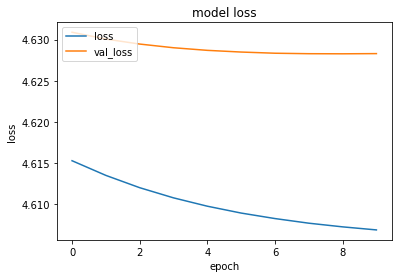

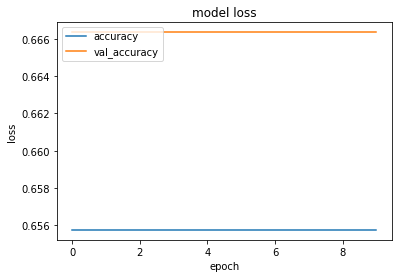

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 82us/step - loss: 4.6153 - acc: 0.6558 - val_loss: 4.6309 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6134 - acc: 0.6558 - val_loss: 4.6300 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6119 - acc: 0.6558 - val_loss: 4.6294 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6107 - acc: 0.6558 - val_loss: 4.6290 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6096 - acc: 0.6558 - val_loss: 4.6286 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.6088 - acc: 0.6558 - val_loss: 4.6284 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6081 - acc: 0.6558 - val_loss: 4.6283 - val_acc: 0.6663
Epoch 8

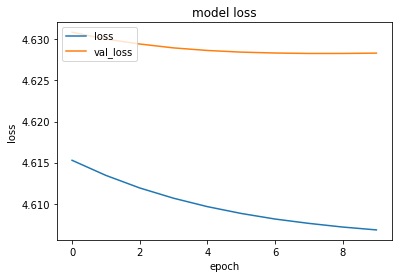

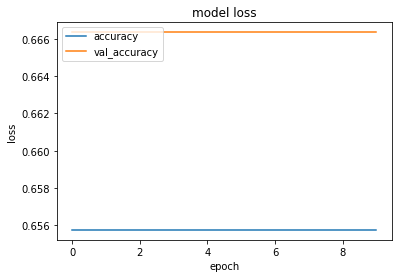

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.6153 - acc: 0.6558 - val_loss: 4.6309 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6134 - acc: 0.6558 - val_loss: 4.6300 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.6119 - acc: 0.6558 - val_loss: 4.6294 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6106 - acc: 0.6558 - val_loss: 4.6289 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6096 - acc: 0.6558 - val_loss: 4.6286 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.6088 - acc: 0.6558 - val_loss: 4.6284 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 74us/step - loss: 4.6081 - acc: 0.6558 - val_loss: 4.6283 - val_acc: 0.6663
Epoch 8

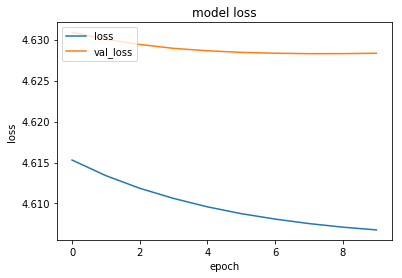

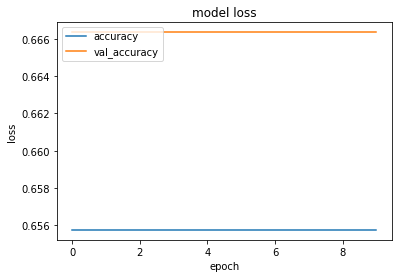

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.6154 - acc: 0.6558 - val_loss: 4.6309 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 73us/step - loss: 4.6135 - acc: 0.6558 - val_loss: 4.6301 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.6119 - acc: 0.6558 - val_loss: 4.6294 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6107 - acc: 0.6558 - val_loss: 4.6290 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.6096 - acc: 0.6558 - val_loss: 4.6286 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.6088 - acc: 0.6558 - val_loss: 4.6284 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 82us/step - loss: 4.6081 - acc: 0.6558 - val_loss: 4.6283 - val_acc: 0.6663
Epoch 8

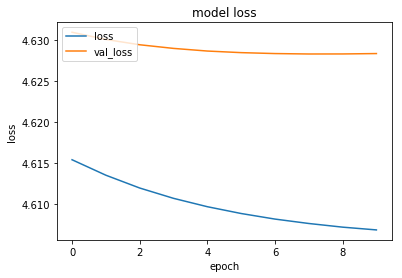

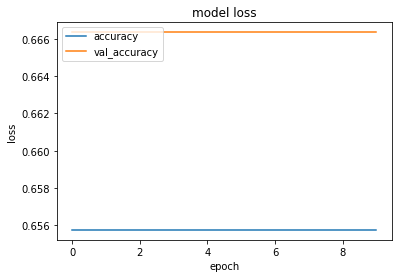

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6154 - acc: 0.6558 - val_loss: 4.6310 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.6135 - acc: 0.6558 - val_loss: 4.6301 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6119 - acc: 0.6558 - val_loss: 4.6294 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 74us/step - loss: 4.6106 - acc: 0.6558 - val_loss: 4.6290 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.6096 - acc: 0.6558 - val_loss: 4.6286 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6088 - acc: 0.6558 - val_loss: 4.6284 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.6081 - acc: 0.6558 - val_loss: 4.6283 - val_acc: 0.6663
Epoch 8

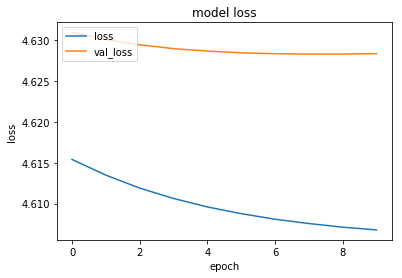

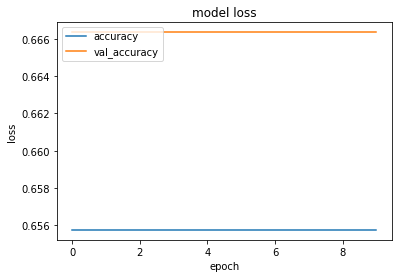

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 81us/step - loss: 4.6154 - acc: 0.6558 - val_loss: 4.6309 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6134 - acc: 0.6558 - val_loss: 4.6301 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6119 - acc: 0.6558 - val_loss: 4.6294 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.6106 - acc: 0.6558 - val_loss: 4.6289 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.6096 - acc: 0.6558 - val_loss: 4.6286 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 73us/step - loss: 4.6088 - acc: 0.6558 - val_loss: 4.6284 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.6081 - acc: 0.6558 - val_loss: 4.6283 - val_acc: 0.6663
Epoch 8

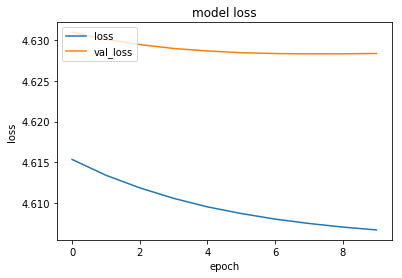

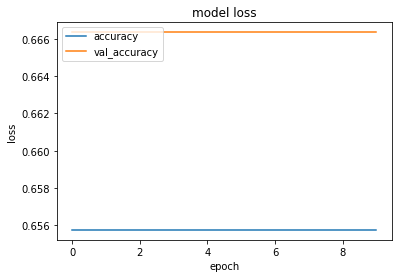

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.6153 - acc: 0.6558 - val_loss: 4.6308 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6133 - acc: 0.6558 - val_loss: 4.6300 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.6118 - acc: 0.6558 - val_loss: 4.6294 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6105 - acc: 0.6558 - val_loss: 4.6289 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.6095 - acc: 0.6558 - val_loss: 4.6286 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.6087 - acc: 0.6558 - val_loss: 4.6284 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6080 - acc: 0.6558 - val_loss: 4.6283 - val_acc: 0.6663
Epoch 8

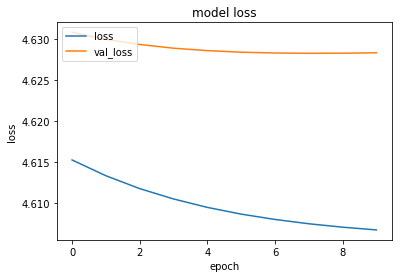

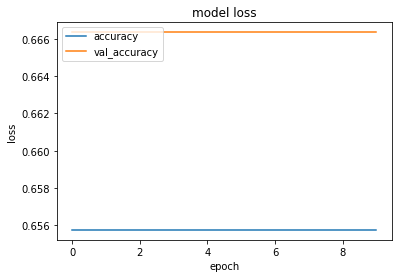

Train on 4157 samples, validate on 1040 samples
Epoch 1/10
4157/4157 [==============================] - 0s 79us/step - loss: 4.6153 - acc: 0.6558 - val_loss: 4.6309 - val_acc: 0.6663
Epoch 2/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.6134 - acc: 0.6558 - val_loss: 4.6300 - val_acc: 0.6663
Epoch 3/10
4157/4157 [==============================] - 0s 76us/step - loss: 4.6118 - acc: 0.6558 - val_loss: 4.6294 - val_acc: 0.6663
Epoch 4/10
4157/4157 [==============================] - 0s 73us/step - loss: 4.6106 - acc: 0.6558 - val_loss: 4.6289 - val_acc: 0.6663
Epoch 5/10
4157/4157 [==============================] - 0s 78us/step - loss: 4.6096 - acc: 0.6558 - val_loss: 4.6286 - val_acc: 0.6663
Epoch 6/10
4157/4157 [==============================] - 0s 77us/step - loss: 4.6087 - acc: 0.6558 - val_loss: 4.6284 - val_acc: 0.6663
Epoch 7/10
4157/4157 [==============================] - 0s 75us/step - loss: 4.6081 - acc: 0.6558 - val_loss: 4.6283 - val_acc: 0.6663
Epoch 8

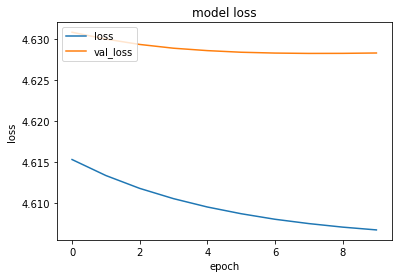

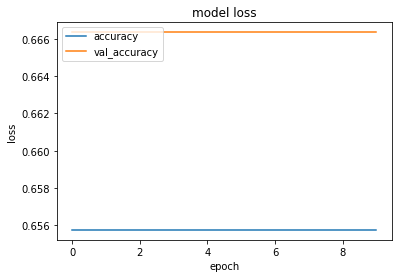

ES STEPS: 1 BEST SCORE: 0.6615 
ES STEPS: 2 BEST SCORE: 0.6644 
ES STEPS: 3 BEST SCORE: 0.6644 
ES STEPS: 4 BEST SCORE: 0.6644 
ES STEPS: 5 BEST SCORE: 0.6685 
Stop: Reach max_steps
Our accuracy is 66.38%
Our AUC is 57.89%


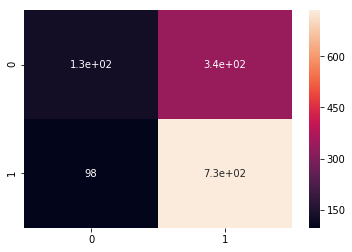

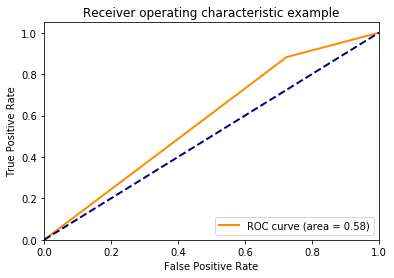

In [13]:
# Initialize
model = ModelCompile()
weights = model.get_weights() 
MyES = ES(model, X_train, y_train, InitialSigma = 0.1, ParentsSize = 15, ChildSize = 100, tao = 0.5)   
weights, ES_Optimized_ObjVal, P_Best10_Weights, P_Best10_Sigma  = MyES.run(weights, useOLSReg =False, max_steps=3, verbose = 1)

# Optimize
GlobalBestAccuracy = 0
NoImproveTimes = 0
while True:
  # Gradient-based Optimize
  for i, i_Weights in enumerate(P_Best10_Weights): 
      i_Weights = P_Best10_Weights[0]
      temp_flatten_weight = MyES._UnflattenWeights(WeightsStrucure = MyES.WeightsStrucure, ModifiedWeights = i_Weights)
      model, weights = ModelFit(model=model, weights=temp_flatten_weight)
      _, temp_unflatten_weight = MyES._FlattenWeights(weights) 
      P_Best10_Weights[i] = np.array(temp_unflatten_weight) 
  # ES
  weights, ES_Optimized_ObjVal, P_Best10_Weights, P_Best10_Sigma = MyES.run(weights, max_steps=5, verbose = 1,
                                                                            Population_Parents_Weights=P_Best10_Weights, 
                                                                            Population_Parents_Sigma=P_Best10_Sigma)
  # Stop Criteria
  if ES_Optimized_ObjVal > GlobalBestAccuracy:
    GlobalBestAccuracy = ES_Optimized_ObjVal
    NoImproveTimes = 0
  else: 
    NoImproveTimes = NoImproveTimes + 1
    if NoImproveTimes == 5:
      break
    
Performance(model)